In [1]:
!nvidia-smi

Fri Aug 21 14:42:03 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
import torch 
import torch.nn as nn
import torchvision
import numpy as np 
import random
import os
import glob
import copy
from tqdm import tqdm as tqdm
from torchsummary import summary

seed = 42
random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
np.random.seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.manual_seed(seed)

best_model = None
best_loss = 0.
best_test_loss = 0.
best_test_acc = 0.
best_pred_labels = []
true_labels = []

pred_labels = []
test_acc = 0.
test_loss = 0.

# device = torch.device('cuda:0')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# train class samples 
print('Normal Samples in Training Data')
!ls -l /content/drive/"My Drive"/NDP_Data/chest_xray/train/NORMAL | wc -l
print('Pneumonia Samples in Training Data')
!ls -l /content/drive/"My Drive"/NDP_Data/chest_xray/train/PNEUMONIA | wc -l

Normal Samples in Training Data
1342
Pneumonia Samples in Training Data
3876


In [5]:
# Validation samples
print('Normal Samples in Validation Data')
!ls -l /content/drive/"My Drive"/NDP_Data/chest_xray/val/NORMAL | wc -l
print('Pneumonia Samples in Validation Data')
!ls -l /content/drive/"My Drive"/NDP_Data/chest_xray/val/PNEUMONIA | wc -l

Normal Samples in Validation Data
9
Pneumonia Samples in Validation Data
9


In [6]:
# Testing samples
print('Normal Samples in Testing Data')
!ls -l /content/drive/"My Drive"/NDP_Data/chest_xray/test/NORMAL | wc -l
print('Pneumonia Samples in Testing Data')
!ls -l /content/drive/"My Drive"/NDP_Data/chest_xray/test/PNEUMONIA | wc -l

Normal Samples in Testing Data
235
Pneumonia Samples in Testing Data
391


In [7]:
# Copying to Non DP data(train, val and test) to local to process/run faster during training & inference

!cp -R /content/drive/"My Drive"/NDP_Data/chest_xray/train ./

!cp -R /content/drive/"My Drive"/NDP_Data/chest_xray/val ./

!cp -R /content/drive/"My Drive"/NDP_Data/chest_xray/test ./

In [8]:
!ls -lrt

total 20
drwxr-xr-x 1 root root 4096 Jul 30 16:30 sample_data
drwx------ 4 root root 4096 Aug 21 14:42 drive
drwx------ 4 root root 4096 Aug 21 14:55 train
drwx------ 4 root root 4096 Aug 21 15:14 val
drwx------ 4 root root 4096 Aug 21 15:15 test


In [9]:
!ls -l ./train/NORMAL | wc -l

!ls -l ./train/PNEUMONIA | wc -l

1342
3876


In [10]:
!ls -l ./val/NORMAL | wc -l

!ls -l ./val/PNEUMONIA | wc -l

9
9


In [11]:
!ls -l ./test/NORMAL | wc -l

!ls -l ./test/PNEUMONIA | wc -l

235
391


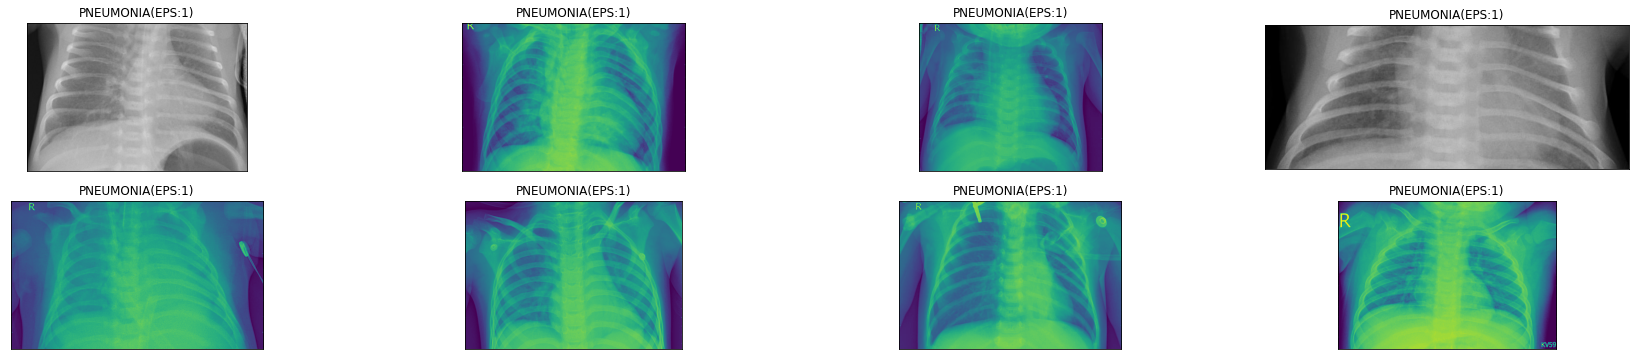

In [12]:
import matplotlib.pyplot as plt
from PIL import Image

fig = plt.figure(figsize=(30, 6))
base_dir = './train'
# display 8 PNEUMONIA images(train) for Epsilon :1
train_imgs = os.listdir(base_dir+"/PNEUMONIA")
for idx, img in enumerate(np.random.choice(train_imgs, 8)):
    ax = fig.add_subplot(2, 8//2, idx+1, xticks=[], yticks=[])
    im = Image.open(base_dir+"/PNEUMONIA/" + img)
    plt.imshow(im)
    ax.set_title('PNEUMONIA(EPS:1)')

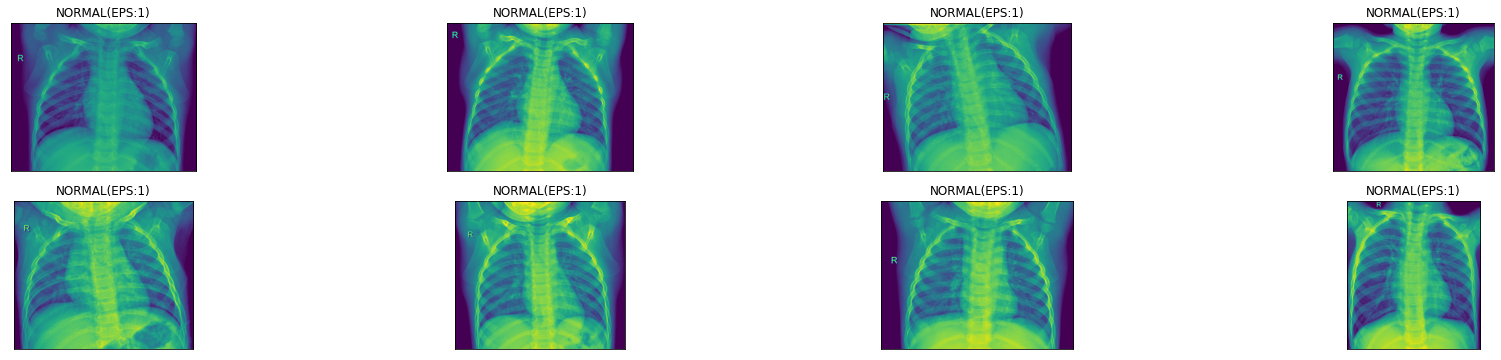

In [13]:
fig = plt.figure(figsize=(30, 6))
base_dir = './train'
# display 8 NORMAL images(train) for Epsilon :1
train_imgs = os.listdir(base_dir+"/NORMAL")
for idx, img in enumerate(np.random.choice(train_imgs, 8)):
    ax = fig.add_subplot(2, 8//2, idx+1, xticks=[], yticks=[])
    im = Image.open(base_dir+"/NORMAL/" + img)
    plt.imshow(im)
    ax.set_title('NORMAL(EPS:1)')

In [14]:
class ChestXRay(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        sample, target = super().__getitem__(index)
        path, _ = self.samples[index]
        
        target = 0
        if 'PNEUMONIA' in path:
            target = 1
        
        return sample, target
       

In [15]:
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.RandomAffine(0, translate=(0, 0.1), scale=(1, 1.10)),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

train_dataset = ChestXRay('./train/', transform=train_transforms)
val_dataset = ChestXRay('./val/', transform=train_transforms)
test_dataset = ChestXRay('./test/', transform=transforms)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=4, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

In [16]:
model = torchvision.models.resnet18(pretrained=True)
model.fc = torch.nn.Linear(in_features=512, out_features=2)
model = model.to(device)
model

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [17]:
summary(model.cuda(), [(3,224,224,)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [18]:
def deactivate_batchnorm(m):
    if isinstance(m, nn.BatchNorm2d):
        m.reset_parameters()
        m.eval()
        #m.affine = False
        #m.track_running_stats = False
        with torch.no_grad():
            m.weight.fill_(1.0)
            m.bias.zero_()

In [19]:
def clip_grad(parameters, max_norm, norm_type=2):
    parameters = list(filter(lambda p: p.grad is not None, parameters))
    total_norm = 0
    for p in parameters:
        param_norm = p.grad.data.norm(norm_type)
        total_norm += param_norm.item() ** norm_type

In [20]:
def train_dp(model, trainloader, criterion, optimizer, lr_scheduler, phase='train'):
    """
    Differentially Private version of the training procedure
    :param trainloader:
    :param model:
    :param optimizer:
    :param epoch:
    :return:
    """
    model.train()
    model.apply(deactivate_batchnorm)
    running_loss = 0.0
    epoch_loss = 0.
    epoch_acc = 0.
    
    batch_num = 0.
    samples_num = 0.
    
    true_labels = []
    pred_labels = []
    num_microbatches = 32
    #S = 1
    S = 0.3
    z = 5.002 # n=5218, batch_size=128, noise_multiplier=5.002, epochs=50, delta=1e-4. This gives DP-SGD with sampling rate = 2.45% and noise_multiplier = 5.002 iterated over 2039 steps satisfies differential privacy with eps = 0.994 and delta = 0.0001.
              # The optimal RDP order is 20.0.
    sigma = z * S
    for batch_idx, data in tqdm(enumerate(trainloader, 0), leave=True):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        #print(loss.shape)
        running_loss += torch.mean(loss).item()

        true_labels.append(labels.detach().cpu())
        pred_labels.append(preds.detach().cpu())

        losses = torch.mean(loss.reshape(num_microbatches, -1), dim=1)
        saved_var = dict()
        for tensor_name, tensor in model.named_parameters():
            saved_var[tensor_name] = torch.zeros_like(tensor)

        for j in losses:
            j.backward(retain_graph=True)
            torch.nn.utils.clip_grad_norm_(model.parameters(), S)
            for tensor_name, tensor in model.named_parameters():
                new_grad = tensor.grad
                saved_var[tensor_name].add_(new_grad)
            model.zero_grad()

        for tensor_name, tensor in model.named_parameters():
            if device.type =='cuda':
                noise = torch.cuda.FloatTensor(tensor.grad.shape).normal_(0, sigma)
                #noise = torch.FloatTensor(tensor.grad.shape).normal_(0, sigma)
            else:
                noise = torch.FloatTensor(tensor.grad.shape).normal_(0, sigma)
            saved_var[tensor_name].add_(noise)
            tensor.grad = saved_var[tensor_name] / num_microbatches
        optimizer.step()

        #print(f'\r{phase} batch [{batch_idx}/{len(trainloader)}]: loss {loss}', end='', flush=True)
        print(f'\r{phase} batch [{batch_idx}/{len(trainloader)}]: loss {torch.mean(loss).item()}', end='', flush=True)
        epoch_loss += torch.mean(loss.detach().cpu()).item()
        epoch_acc += torch.sum(preds == labels.data)
        batch_num += 1
        samples_num += len(labels)

        '''if i > 0 and i % 20 == 0:
            #             logger.info('[%d, %5d] loss: %.3f' %
            #                   (epoch + 1, i + 1, running_loss / 2000))
            plot(epoch * len(trainloader) + i, running_loss, 'Train Loss')
            running_loss = 0.0'''
    #print("RETURNING........")
    return epoch_loss / batch_num, epoch_acc / samples_num, torch.cat(true_labels).numpy(), torch.cat(pred_labels).numpy()      

In [21]:
def test(model, testloader, criterion, optimizer, lr_scheduler, phase='test'):
    model.eval()
    model.apply(deactivate_batchnorm)
    #correct = 0
    #total = 0

    epoch_loss = 0.
    epoch_acc = 0.
    
    batch_num = 0.
    samples_num = 0.
    
    true_labels = []
    pred_labels = []

    with torch.no_grad():
        for batch_idx, data in  enumerate(testloader):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            #_, predicted = torch.max(outputs.data, 1)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            true_labels.append(labels.detach().cpu())
            pred_labels.append(preds.detach().cpu())

            # print(f'\r{phase} batch [{batch_idx}/{len(testloader)}]: loss {loss}', end='', flush=True)
            print(f'\r{phase} batch [{batch_idx}/{len(testloader)}]: loss {torch.mean(loss).item()}', end='', flush=True)
            epoch_loss += torch.mean(loss.detach().cpu()).item()
            epoch_acc += torch.sum(preds == labels.data)
            batch_num += 1
            samples_num += len(labels)

            #total += labels.size(0)
            #correct += (predicted == labels).sum().item()
        #print("TESTING.....")
        return epoch_loss / batch_num, epoch_acc / samples_num, torch.cat(true_labels).numpy(), torch.cat(pred_labels).numpy()

In [22]:
criterion = torch.nn.CrossEntropyLoss(reduction='none')
#optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, weight_decay=0.001)
optimizer = torch.optim.SGD([{'params': [param for name, param in model.named_parameters() if 'fc' not in name]}, {'params': model.fc.parameters(), 'lr': 1e-3}], lr=5e-4, weight_decay=0.001)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)

In [23]:
train_losses = []
val_losses = []
test_losses = []

for epoch in range(50):
    print('='*15, f'Epoch: {epoch}')
    
#train_dp(model, trainloader, criterion, optimizer, lr_scheduler, phase='train')
#test(model, testloader, criterion, optimizer, lr_scheduler, phase='test')

    train_loss, train_acc, _, _ = train_dp(model, train_dataloader, criterion, optimizer, lr_scheduler)
    val_loss, val_acc, _, _ = test(model, val_dataloader, criterion, optimizer, lr_scheduler, phase='val')
    test_loss, test_acc, true_labels, pred_labels = test(model, test_dataloader, criterion, optimizer, lr_scheduler, phase='test')
    
    print()
    print(f'Train loss: {train_loss}, Train accuracy: {train_acc}')
    print(f'Val loss: {val_loss}, Val accuracy: {val_acc}')
    print(f'Test loss: {test_loss}, Test accuracy: {test_acc}')
    print()
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    test_losses.append(test_loss)
    
    torch.save({'epoch': epoch, 'model': model.state_dict()}, f'resnet34-mooney-chest-x-ray-{seed}.pt')
    
    if best_model is None or val_loss < best_loss:
        best_model = copy.deepcopy(model)
        best_loss = val_loss
        best_test_loss = test_loss
        best_test_acc = test_acc 
        best_pred_labels = pred_labels
        torch.save({'epoch': epoch, 'model': model.state_dict()}, f'resnet34-mooney-chest-x-ray-best-{seed}.pt')

0it [00:00, ?it/s]

=============== Epoch: 0
train batch [0/41]: loss 0.6756365895271301

1it [00:08,  8.73s/it]

train batch [1/41]: loss 0.6670045256614685

2it [00:17,  8.65s/it]

train batch [2/41]: loss 0.6757327914237976

3it [00:25,  8.66s/it]

train batch [3/41]: loss 0.6796600818634033

4it [00:34,  8.73s/it]

train batch [4/41]: loss 0.6751655340194702

5it [00:43,  8.68s/it]

train batch [5/41]: loss 0.6656583547592163

6it [00:51,  8.58s/it]

train batch [6/41]: loss 0.6745234727859497

7it [01:00,  8.59s/it]

train batch [7/41]: loss 0.6647801399230957

8it [01:08,  8.60s/it]

train batch [8/41]: loss 0.6691332459449768

9it [01:17,  8.60s/it]

train batch [9/41]: loss 0.6699367761611938

10it [01:25,  8.55s/it]

train batch [10/41]: loss 0.6649287343025208

11it [01:34,  8.55s/it]

train batch [11/41]: loss 0.6620036959648132

12it [01:42,  8.53s/it]

train batch [12/41]: loss 0.6755533218383789

13it [01:51,  8.58s/it]

train batch [13/41]: loss 0.6659762859344482

14it [02:00,  8.56s/it]

train batch [14/41]: loss 0.6705985069274902

15it [02:08,  8.55s/it]

train batch [15/41]: loss 0.6738031506538391

16it [02:17,  8.58s/it]

train batch [16/41]: loss 0.6596066951751709

17it [02:25,  8.56s/it]

train batch [17/41]: loss 0.675394594669342

18it [02:34,  8.61s/it]

train batch [18/41]: loss 0.6548388004302979

19it [02:43,  8.57s/it]

train batch [19/41]: loss 0.6600325703620911

20it [02:51,  8.60s/it]

train batch [20/41]: loss 0.6568790674209595

21it [03:00,  8.58s/it]

train batch [21/41]: loss 0.6556774377822876

22it [03:08,  8.54s/it]

train batch [22/41]: loss 0.6692289113998413

23it [03:17,  8.54s/it]

train batch [23/41]: loss 0.6601712703704834

24it [03:25,  8.58s/it]

train batch [24/41]: loss 0.6669852137565613

25it [03:34,  8.60s/it]

train batch [25/41]: loss 0.6651724576950073

26it [03:43,  8.60s/it]

train batch [26/41]: loss 0.6526328921318054

27it [03:51,  8.56s/it]

train batch [27/41]: loss 0.6690294742584229

28it [04:00,  8.58s/it]

train batch [28/41]: loss 0.6541551351547241

29it [04:08,  8.50s/it]

train batch [29/41]: loss 0.6594055891036987

30it [04:17,  8.50s/it]

train batch [30/41]: loss 0.6544671058654785

31it [04:25,  8.53s/it]

train batch [31/41]: loss 0.6633496284484863

32it [04:34,  8.56s/it]

train batch [32/41]: loss 0.6675870418548584

33it [04:42,  8.58s/it]

train batch [33/41]: loss 0.6566153764724731

34it [04:51,  8.56s/it]

train batch [34/41]: loss 0.6569006443023682

35it [04:59,  8.54s/it]

train batch [35/41]: loss 0.6482582092285156

36it [05:08,  8.50s/it]

train batch [36/41]: loss 0.6544336080551147

37it [05:17,  8.57s/it]

train batch [37/41]: loss 0.6475483179092407

38it [05:25,  8.55s/it]

train batch [38/41]: loss 0.6571921110153198

39it [05:34,  8.56s/it]

train batch [39/41]: loss 0.6575831770896912

40it [05:42,  8.56s/it]

train batch [40/41]: loss 0.6717318892478943

41it [05:49,  8.52s/it]

val batch [0/4]: loss 0.7988680601119995

test batch [4/5]: loss 0.6112107038497925
Train loss: 0.6640237191828285, Train accuracy: 0.7429064512252808
Val loss: 0.7096271812915802, Val accuracy: 0.5
Test loss: 0.680011510848999, Test accuracy: 0.625

=============== Epoch: 1


0it [00:00, ?it/s]

train batch [0/41]: loss 0.6622641086578369

1it [00:08,  8.64s/it]

train batch [1/41]: loss 0.6478820443153381

2it [00:16,  8.54s/it]

train batch [2/41]: loss 0.6607707738876343

3it [00:25,  8.55s/it]

train batch [3/41]: loss 0.6597997546195984

4it [00:34,  8.59s/it]

train batch [4/41]: loss 0.6637097597122192

5it [00:42,  8.64s/it]

train batch [5/41]: loss 0.6522120237350464

6it [00:51,  8.63s/it]

train batch [6/41]: loss 0.6638821363449097

7it [01:00,  8.65s/it]

train batch [7/41]: loss 0.643075704574585

8it [01:08,  8.60s/it]

train batch [8/41]: loss 0.6570494174957275

9it [01:17,  8.60s/it]

train batch [9/41]: loss 0.6511163115501404

10it [01:25,  8.59s/it]

train batch [10/41]: loss 0.6350909471511841

11it [01:34,  8.51s/it]

train batch [11/41]: loss 0.6567007303237915

12it [01:42,  8.52s/it]

train batch [12/41]: loss 0.638216495513916

13it [01:51,  8.50s/it]

train batch [13/41]: loss 0.6651843786239624

14it [02:00,  8.62s/it]

train batch [14/41]: loss 0.6717462539672852

15it [02:09,  8.72s/it]

train batch [15/41]: loss 0.6588836312294006

16it [02:17,  8.69s/it]

train batch [16/41]: loss 0.6627255082130432

17it [02:26,  8.74s/it]

train batch [17/41]: loss 0.6480070352554321

18it [02:35,  8.67s/it]

train batch [18/41]: loss 0.6356239914894104

19it [02:43,  8.59s/it]

train batch [19/41]: loss 0.6542627811431885

20it [02:51,  8.57s/it]

train batch [20/41]: loss 0.6448169946670532

21it [03:00,  8.52s/it]

train batch [21/41]: loss 0.6480111479759216

22it [03:08,  8.49s/it]

train batch [22/41]: loss 0.6448769569396973

23it [03:17,  8.44s/it]

train batch [23/41]: loss 0.6451252698898315

24it [03:25,  8.42s/it]

train batch [24/41]: loss 0.652462899684906

25it [03:34,  8.45s/it]

train batch [25/41]: loss 0.6537480354309082

26it [03:42,  8.51s/it]

train batch [26/41]: loss 0.654181957244873

27it [03:51,  8.52s/it]

train batch [27/41]: loss 0.6436664462089539

28it [03:59,  8.48s/it]

train batch [28/41]: loss 0.6625185012817383

29it [04:08,  8.54s/it]

train batch [29/41]: loss 0.6524914503097534

30it [04:16,  8.52s/it]

train batch [30/41]: loss 0.6469964981079102

31it [04:25,  8.56s/it]

train batch [31/41]: loss 0.6505171656608582

32it [04:33,  8.55s/it]

train batch [32/41]: loss 0.6512624621391296

33it [04:42,  8.51s/it]

train batch [33/41]: loss 0.6691890954971313

34it [04:51,  8.55s/it]

train batch [34/41]: loss 0.6428436636924744

35it [04:59,  8.58s/it]

train batch [35/41]: loss 0.6624586582183838

36it [05:08,  8.68s/it]

train batch [36/41]: loss 0.6425241231918335

37it [05:17,  8.61s/it]

train batch [37/41]: loss 0.6298930644989014

38it [05:25,  8.55s/it]

train batch [38/41]: loss 0.6592773199081421

39it [05:34,  8.58s/it]

train batch [39/41]: loss 0.6328409910202026

40it [05:42,  8.52s/it]

train batch [40/41]: loss 0.6586489677429199

41it [05:49,  8.51s/it]

val batch [0/4]: loss 0.8428077697753906

test batch [4/5]: loss 0.5825406312942505

0it [00:00, ?it/s]


Train loss: 0.6521111217940726, Train accuracy: 0.7429064512252808
Val loss: 0.717014491558075, Val accuracy: 0.5
Test loss: 0.6758905172348022, Test accuracy: 0.625

=============== Epoch: 2
train batch [0/41]: loss 0.6324055790901184

1it [00:08,  8.64s/it]

train batch [1/41]: loss 0.6276466846466064

2it [00:17,  8.57s/it]

train batch [2/41]: loss 0.6488649845123291

3it [00:25,  8.56s/it]

train batch [3/41]: loss 0.6476328372955322

4it [00:34,  8.57s/it]

train batch [4/41]: loss 0.6520934104919434

5it [00:42,  8.56s/it]

train batch [5/41]: loss 0.6584283113479614

6it [00:51,  8.55s/it]

train batch [6/41]: loss 0.6443642377853394

7it [00:59,  8.60s/it]

train batch [7/41]: loss 0.6658689975738525

8it [01:08,  8.66s/it]

train batch [8/41]: loss 0.6497291326522827

9it [01:17,  8.63s/it]

train batch [9/41]: loss 0.6446309685707092

10it [01:25,  8.62s/it]

train batch [10/41]: loss 0.6361424922943115

11it [01:34,  8.59s/it]

train batch [11/41]: loss 0.6519026756286621

12it [01:42,  8.57s/it]

train batch [12/41]: loss 0.6474879384040833

13it [01:51,  8.58s/it]

train batch [13/41]: loss 0.6507492661476135

14it [02:00,  8.60s/it]

train batch [14/41]: loss 0.6501643061637878

15it [02:08,  8.61s/it]

train batch [15/41]: loss 0.6425501704216003

16it [02:17,  8.64s/it]

train batch [16/41]: loss 0.6629409193992615

17it [02:26,  8.64s/it]

train batch [17/41]: loss 0.6323952674865723

18it [02:34,  8.64s/it]

train batch [18/41]: loss 0.6245217323303223

19it [02:43,  8.58s/it]

train batch [19/41]: loss 0.648172914981842

20it [02:51,  8.58s/it]

train batch [20/41]: loss 0.6330251693725586

21it [03:00,  8.56s/it]

train batch [21/41]: loss 0.6390436887741089

22it [03:08,  8.55s/it]

train batch [22/41]: loss 0.6387613415718079

23it [03:17,  8.60s/it]

train batch [23/41]: loss 0.6434059143066406

24it [03:26,  8.58s/it]

train batch [24/41]: loss 0.6174574494361877

25it [03:34,  8.52s/it]

train batch [25/41]: loss 0.6144338846206665

26it [03:42,  8.50s/it]

train batch [26/41]: loss 0.6689919829368591

27it [03:51,  8.56s/it]

train batch [27/41]: loss 0.6350196599960327

28it [04:00,  8.56s/it]

train batch [28/41]: loss 0.6509371995925903

29it [04:08,  8.57s/it]

train batch [29/41]: loss 0.6360013484954834

30it [04:17,  8.55s/it]

train batch [30/41]: loss 0.637601375579834

31it [04:25,  8.54s/it]

train batch [31/41]: loss 0.6482932567596436

32it [04:34,  8.57s/it]

train batch [32/41]: loss 0.6468601822853088

33it [04:43,  8.59s/it]

train batch [33/41]: loss 0.6388776898384094

34it [04:51,  8.60s/it]

train batch [34/41]: loss 0.6269913911819458

35it [05:00,  8.58s/it]

train batch [35/41]: loss 0.6266014575958252

36it [05:08,  8.56s/it]

train batch [36/41]: loss 0.6342496871948242

37it [05:17,  8.51s/it]

train batch [37/41]: loss 0.6231628060340881

38it [05:25,  8.54s/it]

train batch [38/41]: loss 0.6323583722114563

39it [05:34,  8.54s/it]

train batch [39/41]: loss 0.6151751279830933

40it [05:42,  8.51s/it]

train batch [40/41]: loss 0.6311111450195312

41it [05:49,  8.52s/it]

val batch [0/4]: loss 0.8850517272949219

test batch [4/5]: loss 0.5567214488983154

0it [00:00, ?it/s]


Train loss: 0.6404159272589335, Train accuracy: 0.7429064512252808
Val loss: 0.7179572433233261, Val accuracy: 0.5
Test loss: 0.672394335269928, Test accuracy: 0.625

=============== Epoch: 3
train batch [0/41]: loss 0.6204145550727844

1it [00:08,  8.43s/it]

train batch [1/41]: loss 0.6426651477813721

2it [00:17,  8.50s/it]

train batch [2/41]: loss 0.6224567890167236

3it [00:25,  8.50s/it]

train batch [3/41]: loss 0.6536822319030762

4it [00:34,  8.59s/it]

train batch [4/41]: loss 0.6369010210037231

5it [00:42,  8.59s/it]

train batch [5/41]: loss 0.6363476514816284

6it [00:51,  8.60s/it]

train batch [6/41]: loss 0.616461992263794

7it [01:00,  8.55s/it]

train batch [7/41]: loss 0.6437116265296936

8it [01:08,  8.60s/it]

train batch [8/41]: loss 0.61564040184021

9it [01:17,  8.56s/it]

train batch [9/41]: loss 0.6149659156799316

10it [01:25,  8.50s/it]

train batch [10/41]: loss 0.6387588381767273

11it [01:34,  8.55s/it]

train batch [11/41]: loss 0.6230946779251099

12it [01:42,  8.56s/it]

train batch [12/41]: loss 0.6349495649337769

13it [01:51,  8.56s/it]

train batch [13/41]: loss 0.6177017688751221

14it [01:59,  8.55s/it]

train batch [14/41]: loss 0.6070278882980347

15it [02:08,  8.52s/it]

train batch [15/41]: loss 0.6330996155738831

16it [02:17,  8.56s/it]

train batch [16/41]: loss 0.6230111122131348

17it [02:25,  8.54s/it]

train batch [17/41]: loss 0.6191222667694092

18it [02:34,  8.53s/it]

train batch [18/41]: loss 0.6233094930648804

19it [02:42,  8.54s/it]

train batch [19/41]: loss 0.618868350982666

20it [02:51,  8.53s/it]

train batch [20/41]: loss 0.610328197479248

21it [02:59,  8.49s/it]

train batch [21/41]: loss 0.6351258158683777

22it [03:08,  8.55s/it]

train batch [22/41]: loss 0.6332798600196838

23it [03:16,  8.56s/it]

train batch [23/41]: loss 0.639443039894104

24it [03:25,  8.59s/it]

train batch [24/41]: loss 0.6199826002120972

25it [03:33,  8.55s/it]

train batch [25/41]: loss 0.6343376040458679

26it [03:42,  8.56s/it]

train batch [26/41]: loss 0.6357758045196533

27it [03:50,  8.52s/it]

train batch [27/41]: loss 0.6260819435119629

28it [03:59,  8.51s/it]

train batch [28/41]: loss 0.6527647972106934

29it [04:08,  8.55s/it]

train batch [29/41]: loss 0.6516801714897156

30it [04:16,  8.66s/it]

train batch [30/41]: loss 0.6545184850692749

31it [04:25,  8.66s/it]

train batch [31/41]: loss 0.6230753064155579

32it [04:34,  8.59s/it]

train batch [32/41]: loss 0.650412380695343

33it [04:42,  8.59s/it]

train batch [33/41]: loss 0.6604205369949341

34it [04:51,  8.63s/it]

train batch [34/41]: loss 0.6356421709060669

35it [05:00,  8.64s/it]

train batch [35/41]: loss 0.6108272671699524

36it [05:08,  8.56s/it]

train batch [36/41]: loss 0.6133483052253723

37it [05:16,  8.53s/it]

train batch [37/41]: loss 0.601779043674469

38it [05:25,  8.49s/it]

train batch [38/41]: loss 0.652531623840332

39it [05:33,  8.54s/it]

train batch [39/41]: loss 0.6215372085571289

40it [05:42,  8.55s/it]

train batch [40/41]: loss 0.6286906003952026

41it [05:48,  8.51s/it]

val batch [0/4]: loss 0.9334008693695068

test batch [4/5]: loss 0.5329817533493042

0it [00:00, ?it/s]


Train loss: 0.6300920495172826, Train accuracy: 0.7429064512252808
Val loss: 0.7243632674217224, Val accuracy: 0.5
Test loss: 0.6701834678649903, Test accuracy: 0.625

=============== Epoch: 4
train batch [0/41]: loss 0.6334083080291748

1it [00:08,  8.44s/it]

train batch [1/41]: loss 0.6143237352371216

2it [00:17,  8.53s/it]

train batch [2/41]: loss 0.6404415369033813

3it [00:25,  8.53s/it]

train batch [3/41]: loss 0.5909061431884766

4it [00:34,  8.50s/it]

train batch [4/41]: loss 0.6310368776321411

5it [00:42,  8.56s/it]

train batch [5/41]: loss 0.6103711128234863

6it [00:51,  8.53s/it]

train batch [6/41]: loss 0.6185892820358276

7it [00:59,  8.54s/it]

train batch [7/41]: loss 0.6012555956840515

8it [01:08,  8.55s/it]

train batch [8/41]: loss 0.6003415584564209

9it [01:16,  8.54s/it]

train batch [9/41]: loss 0.6513754725456238

10it [01:25,  8.58s/it]

train batch [10/41]: loss 0.6103947162628174

11it [01:34,  8.55s/it]

train batch [11/41]: loss 0.6216280460357666

12it [01:42,  8.55s/it]

train batch [12/41]: loss 0.6277698874473572

13it [01:51,  8.58s/it]

train batch [13/41]: loss 0.6198775768280029

14it [02:00,  8.62s/it]

train batch [14/41]: loss 0.6144629716873169

15it [02:08,  8.63s/it]

train batch [15/41]: loss 0.6143788695335388

16it [02:17,  8.62s/it]

train batch [16/41]: loss 0.6414942145347595

17it [02:25,  8.63s/it]

train batch [17/41]: loss 0.6448386907577515

18it [02:34,  8.63s/it]

train batch [18/41]: loss 0.5919743180274963

19it [02:42,  8.57s/it]

train batch [19/41]: loss 0.6069021224975586

20it [02:51,  8.53s/it]

train batch [20/41]: loss 0.6373634934425354

21it [02:59,  8.52s/it]

train batch [21/41]: loss 0.5866154432296753

22it [03:08,  8.46s/it]

train batch [22/41]: loss 0.6295893788337708

23it [03:16,  8.54s/it]

train batch [23/41]: loss 0.6052231788635254

24it [03:25,  8.50s/it]

train batch [24/41]: loss 0.6424369812011719

25it [03:34,  8.57s/it]

train batch [25/41]: loss 0.6474723219871521

26it [03:42,  8.61s/it]

train batch [26/41]: loss 0.5782809853553772

27it [03:51,  8.53s/it]

train batch [27/41]: loss 0.6262525916099548

28it [03:59,  8.55s/it]

train batch [28/41]: loss 0.6278754472732544

29it [04:08,  8.59s/it]

train batch [29/41]: loss 0.623231828212738

30it [04:16,  8.58s/it]

train batch [30/41]: loss 0.6367117166519165

31it [04:25,  8.58s/it]

train batch [31/41]: loss 0.6422470808029175

32it [04:34,  8.58s/it]

train batch [32/41]: loss 0.6072141528129578

33it [04:42,  8.55s/it]

train batch [33/41]: loss 0.6074239015579224

34it [04:51,  8.53s/it]

train batch [34/41]: loss 0.6053848266601562

35it [04:59,  8.54s/it]

train batch [35/41]: loss 0.6374770998954773

36it [05:08,  8.56s/it]

train batch [36/41]: loss 0.6284204721450806

37it [05:16,  8.54s/it]

train batch [37/41]: loss 0.6121175289154053

38it [05:25,  8.58s/it]

train batch [38/41]: loss 0.6252962350845337

39it [05:34,  8.58s/it]

train batch [39/41]: loss 0.6307273507118225

40it [05:42,  8.63s/it]

train batch [40/41]: loss 0.6686254739761353

41it [05:49,  8.52s/it]

val batch [1/4]: loss 0.9476509094238281

test batch [4/5]: loss 0.5096538066864014

0it [00:00, ?it/s]


Train loss: 0.621750203574576, Train accuracy: 0.7429064512252808
Val loss: 0.7350205481052399, Val accuracy: 0.5
Test loss: 0.6684715270996093, Test accuracy: 0.625

=============== Epoch: 5
train batch [0/41]: loss 0.6228154897689819

1it [00:08,  8.60s/it]

train batch [1/41]: loss 0.6073290109634399

2it [00:17,  8.58s/it]

train batch [2/41]: loss 0.6273921728134155

3it [00:25,  8.61s/it]

train batch [3/41]: loss 0.620403528213501

4it [00:34,  8.58s/it]

train batch [4/41]: loss 0.6186776161193848

5it [00:42,  8.53s/it]

train batch [5/41]: loss 0.6301459074020386

6it [00:51,  8.53s/it]

train batch [6/41]: loss 0.5658200979232788

7it [00:59,  8.42s/it]

train batch [7/41]: loss 0.6092113852500916

8it [01:08,  8.47s/it]

train batch [8/41]: loss 0.6250627040863037

9it [01:16,  8.55s/it]

train batch [9/41]: loss 0.6212835311889648

10it [01:25,  8.57s/it]

train batch [10/41]: loss 0.6235787868499756

11it [01:33,  8.56s/it]

train batch [11/41]: loss 0.5761829614639282

12it [01:42,  8.50s/it]

train batch [12/41]: loss 0.6060413122177124

13it [01:50,  8.48s/it]

train batch [13/41]: loss 0.6152979135513306

14it [01:59,  8.55s/it]

train batch [14/41]: loss 0.6172377467155457

15it [02:07,  8.56s/it]

train batch [15/41]: loss 0.6323085427284241

16it [02:16,  8.57s/it]

train batch [16/41]: loss 0.6603030562400818

17it [02:25,  8.62s/it]

train batch [17/41]: loss 0.6088988780975342

18it [02:33,  8.62s/it]

train batch [18/41]: loss 0.627791166305542

19it [02:42,  8.65s/it]

train batch [19/41]: loss 0.5788945555686951

20it [02:50,  8.54s/it]

train batch [20/41]: loss 0.5945053100585938

21it [02:59,  8.55s/it]

train batch [21/41]: loss 0.6102280020713806

22it [03:08,  8.56s/it]

train batch [22/41]: loss 0.5970076322555542

23it [03:16,  8.52s/it]

train batch [23/41]: loss 0.5927894115447998

24it [03:25,  8.52s/it]

train batch [24/41]: loss 0.6098040342330933

25it [03:33,  8.48s/it]

train batch [25/41]: loss 0.6522802114486694

26it [03:42,  8.54s/it]

train batch [26/41]: loss 0.5976256132125854

27it [03:50,  8.54s/it]

train batch [27/41]: loss 0.6059396862983704

28it [03:59,  8.54s/it]

train batch [28/41]: loss 0.626922607421875

29it [04:07,  8.56s/it]

train batch [29/41]: loss 0.6074898838996887

30it [04:16,  8.53s/it]

train batch [30/41]: loss 0.6332654356956482

31it [04:24,  8.56s/it]

train batch [31/41]: loss 0.6259973049163818

32it [04:33,  8.57s/it]

train batch [32/41]: loss 0.6582920551300049

33it [04:42,  8.61s/it]

train batch [33/41]: loss 0.6260972023010254

34it [04:50,  8.62s/it]

train batch [34/41]: loss 0.6049800515174866

35it [04:59,  8.55s/it]

train batch [35/41]: loss 0.5830841660499573

36it [05:07,  8.52s/it]

train batch [36/41]: loss 0.6012122631072998

37it [05:16,  8.53s/it]

train batch [37/41]: loss 0.5990797281265259

38it [05:24,  8.55s/it]

train batch [38/41]: loss 0.6397519707679749

39it [05:33,  8.55s/it]

train batch [39/41]: loss 0.5837924480438232

40it [05:41,  8.48s/it]

train batch [40/41]: loss 0.5933271646499634

41it [05:48,  8.49s/it]

val batch [1/4]: loss 0.9810659289360046

test batch [4/5]: loss 0.4876985549926758

0it [00:00, ?it/s]


Train loss: 0.6131255713904776, Train accuracy: 0.7429064512252808
Val loss: 0.7396910041570663, Val accuracy: 0.5
Test loss: 0.6673257112503052, Test accuracy: 0.625

=============== Epoch: 6
train batch [0/41]: loss 0.6152396202087402

1it [00:08,  8.61s/it]

train batch [1/41]: loss 0.6298832893371582

2it [00:17,  8.61s/it]

train batch [2/41]: loss 0.6148437261581421

3it [00:25,  8.61s/it]

train batch [3/41]: loss 0.5883787870407104

4it [00:34,  8.61s/it]

train batch [4/41]: loss 0.6175848841667175

5it [00:42,  8.60s/it]

train batch [5/41]: loss 0.6320480108261108

6it [00:51,  8.61s/it]

train batch [6/41]: loss 0.5731524229049683

7it [00:59,  8.51s/it]

train batch [7/41]: loss 0.5880608558654785

8it [01:08,  8.46s/it]

train batch [8/41]: loss 0.6411849856376648

9it [01:16,  8.50s/it]

train batch [9/41]: loss 0.6027920246124268

10it [01:25,  8.49s/it]

train batch [10/41]: loss 0.6398906707763672

11it [01:33,  8.55s/it]

train batch [11/41]: loss 0.5994731187820435

12it [01:42,  8.55s/it]

train batch [12/41]: loss 0.590673565864563

13it [01:51,  8.55s/it]

train batch [13/41]: loss 0.617987871170044

14it [01:59,  8.59s/it]

train batch [14/41]: loss 0.5961456298828125

15it [02:08,  8.55s/it]

train batch [15/41]: loss 0.6063816547393799

16it [02:16,  8.59s/it]

train batch [16/41]: loss 0.6195892691612244

17it [02:25,  8.58s/it]

train batch [17/41]: loss 0.5940243601799011

18it [02:33,  8.56s/it]

train batch [18/41]: loss 0.601753294467926

19it [02:42,  8.55s/it]

train batch [19/41]: loss 0.623320460319519

20it [02:51,  8.60s/it]

train batch [20/41]: loss 0.6349245309829712

21it [02:59,  8.60s/it]

train batch [21/41]: loss 0.6257981061935425

22it [03:08,  8.61s/it]

train batch [22/41]: loss 0.5881538391113281

23it [03:17,  8.61s/it]

train batch [23/41]: loss 0.5906704664230347

24it [03:25,  8.57s/it]

train batch [24/41]: loss 0.6035133600234985

25it [03:33,  8.52s/it]

train batch [25/41]: loss 0.6068699359893799

26it [03:42,  8.52s/it]

train batch [26/41]: loss 0.6186031699180603

27it [03:50,  8.52s/it]

train batch [27/41]: loss 0.5874366164207458

28it [03:59,  8.51s/it]

train batch [28/41]: loss 0.5795172452926636

29it [04:07,  8.50s/it]

train batch [29/41]: loss 0.6047428250312805

30it [04:16,  8.49s/it]

train batch [30/41]: loss 0.6189491152763367

31it [04:24,  8.49s/it]

train batch [31/41]: loss 0.6033934950828552

32it [04:33,  8.51s/it]

train batch [32/41]: loss 0.5840156078338623

33it [04:41,  8.49s/it]

train batch [33/41]: loss 0.5860872268676758

34it [04:50,  8.49s/it]

train batch [34/41]: loss 0.6314637660980225

35it [04:59,  8.58s/it]

train batch [35/41]: loss 0.6098865270614624

36it [05:07,  8.57s/it]

train batch [36/41]: loss 0.6194103956222534

37it [05:16,  8.56s/it]

train batch [37/41]: loss 0.5700844526290894

38it [05:24,  8.50s/it]

train batch [38/41]: loss 0.5704424977302551

39it [05:32,  8.45s/it]

train batch [39/41]: loss 0.5646726489067078

40it [05:41,  8.46s/it]

train batch [40/41]: loss 0.6478286385536194

41it [05:47,  8.49s/it]

val batch [1/4]: loss 1.0199720859527588

test batch [4/5]: loss 0.4686601459980011

0it [00:00, ?it/s]


Train loss: 0.6058261772481407, Train accuracy: 0.7429064512252808
Val loss: 0.7534359097480774, Val accuracy: 0.5
Test loss: 0.6666991889476777, Test accuracy: 0.625

=============== Epoch: 7
train batch [0/41]: loss 0.584488034248352

1it [00:08,  8.43s/it]

train batch [1/41]: loss 0.569326639175415

2it [00:16,  8.38s/it]

train batch [2/41]: loss 0.6196115016937256

3it [00:25,  8.45s/it]

train batch [3/41]: loss 0.6058738231658936

4it [00:33,  8.49s/it]

train batch [4/41]: loss 0.6399943828582764

5it [00:42,  8.53s/it]

train batch [5/41]: loss 0.5803862810134888

6it [00:51,  8.54s/it]

train batch [6/41]: loss 0.5524064302444458

7it [00:59,  8.53s/it]

train batch [7/41]: loss 0.5896399021148682

8it [01:08,  8.51s/it]

train batch [8/41]: loss 0.5877342224121094

9it [01:16,  8.44s/it]

train batch [9/41]: loss 0.621313214302063

10it [01:24,  8.49s/it]

train batch [10/41]: loss 0.5798810124397278

11it [01:33,  8.48s/it]

train batch [11/41]: loss 0.616580069065094

12it [01:42,  8.53s/it]

train batch [12/41]: loss 0.6176000237464905

13it [01:50,  8.59s/it]

train batch [13/41]: loss 0.5764415264129639

14it [01:59,  8.58s/it]

train batch [14/41]: loss 0.6180864572525024

15it [02:07,  8.60s/it]

train batch [15/41]: loss 0.6042120456695557

16it [02:16,  8.57s/it]

train batch [16/41]: loss 0.6319212317466736

17it [02:25,  8.57s/it]

train batch [17/41]: loss 0.6344046592712402

18it [02:33,  8.60s/it]

train batch [18/41]: loss 0.5954947471618652

19it [02:42,  8.58s/it]

train batch [19/41]: loss 0.5848205089569092

20it [02:50,  8.55s/it]

train batch [20/41]: loss 0.5883079767227173

21it [02:59,  8.53s/it]

train batch [21/41]: loss 0.6399893760681152

22it [03:07,  8.58s/it]

train batch [22/41]: loss 0.6342664957046509

23it [03:16,  8.59s/it]

train batch [23/41]: loss 0.6108448505401611

24it [03:25,  8.57s/it]

train batch [24/41]: loss 0.6153485774993896

25it [03:33,  8.58s/it]

train batch [25/41]: loss 0.58439040184021

26it [03:42,  8.56s/it]

train batch [26/41]: loss 0.5945109128952026

27it [03:50,  8.51s/it]

train batch [27/41]: loss 0.5680351257324219

28it [03:58,  8.47s/it]

train batch [28/41]: loss 0.6015117764472961

29it [04:07,  8.45s/it]

train batch [29/41]: loss 0.6207913756370544

30it [04:16,  8.54s/it]

train batch [30/41]: loss 0.5855296850204468

31it [04:24,  8.51s/it]

train batch [31/41]: loss 0.599126935005188

32it [04:33,  8.50s/it]

train batch [32/41]: loss 0.5960621237754822

33it [04:41,  8.49s/it]

train batch [33/41]: loss 0.6028914451599121

34it [04:50,  8.51s/it]

train batch [34/41]: loss 0.5564165711402893

35it [04:58,  8.46s/it]

train batch [35/41]: loss 0.5927251577377319

36it [05:06,  8.47s/it]

train batch [36/41]: loss 0.5990225076675415

37it [05:15,  8.51s/it]

train batch [37/41]: loss 0.596493661403656

38it [05:23,  8.49s/it]

train batch [38/41]: loss 0.588642954826355

39it [05:32,  8.50s/it]

train batch [39/41]: loss 0.5776970982551575

40it [05:40,  8.49s/it]

train batch [40/41]: loss 0.5989030599594116

41it [05:47,  8.47s/it]

val batch [1/4]: loss 1.0409047603607178

test batch [4/5]: loss 0.4528409540653229

0it [00:00, ?it/s]


Train loss: 0.5990664580973183, Train accuracy: 0.7429064512252808
Val loss: 0.7536738812923431, Val accuracy: 0.5
Test loss: 0.6661621153354644, Test accuracy: 0.625

=============== Epoch: 8
train batch [0/41]: loss 0.5950605869293213

1it [00:08,  8.56s/it]

train batch [1/41]: loss 0.593154788017273

2it [00:17,  8.54s/it]

train batch [2/41]: loss 0.6045070290565491

3it [00:25,  8.56s/it]

train batch [3/41]: loss 0.5547447800636292

4it [00:34,  8.52s/it]

train batch [4/41]: loss 0.6210770606994629

5it [00:42,  8.57s/it]

train batch [5/41]: loss 0.5759109258651733

6it [00:51,  8.54s/it]

train batch [6/41]: loss 0.5839202404022217

7it [00:59,  8.50s/it]

train batch [7/41]: loss 0.6006537675857544

8it [01:08,  8.53s/it]

train batch [8/41]: loss 0.5667012929916382

9it [01:16,  8.51s/it]

train batch [9/41]: loss 0.5788122415542603

10it [01:25,  8.49s/it]

train batch [10/41]: loss 0.609965443611145

11it [01:33,  8.53s/it]

train batch [11/41]: loss 0.6256212592124939

12it [01:42,  8.54s/it]

train batch [12/41]: loss 0.5889529585838318

13it [01:50,  8.52s/it]

train batch [13/41]: loss 0.637231707572937

14it [01:59,  8.58s/it]

train batch [14/41]: loss 0.5867545008659363

15it [02:08,  8.58s/it]

train batch [15/41]: loss 0.6004686951637268

16it [02:16,  8.57s/it]

train batch [16/41]: loss 0.5926914215087891

17it [02:25,  8.53s/it]

train batch [17/41]: loss 0.614513635635376

18it [02:33,  8.54s/it]

train batch [18/41]: loss 0.5761401653289795

19it [02:41,  8.48s/it]

train batch [19/41]: loss 0.5427337884902954

20it [02:50,  8.42s/it]

train batch [20/41]: loss 0.5560416579246521

21it [02:58,  8.42s/it]

train batch [21/41]: loss 0.5645123720169067

22it [03:07,  8.40s/it]

train batch [22/41]: loss 0.6095250844955444

23it [03:15,  8.44s/it]

train batch [23/41]: loss 0.6302058696746826

24it [03:24,  8.48s/it]

train batch [24/41]: loss 0.5921849012374878

25it [03:32,  8.46s/it]

train batch [25/41]: loss 0.5728276968002319

26it [03:40,  8.44s/it]

train batch [26/41]: loss 0.6117180585861206

27it [03:49,  8.46s/it]

train batch [27/41]: loss 0.5761798620223999

28it [03:57,  8.45s/it]

train batch [28/41]: loss 0.5910922288894653

29it [04:06,  8.46s/it]

train batch [29/41]: loss 0.624861478805542

30it [04:14,  8.47s/it]

train batch [30/41]: loss 0.6007683277130127

31it [04:23,  8.50s/it]

train batch [31/41]: loss 0.5775585174560547

32it [04:31,  8.46s/it]

train batch [32/41]: loss 0.5838533639907837

33it [04:40,  8.50s/it]

train batch [33/41]: loss 0.6100651025772095

34it [04:48,  8.52s/it]

train batch [34/41]: loss 0.5769273638725281

35it [04:57,  8.54s/it]

train batch [35/41]: loss 0.6195724606513977

36it [05:06,  8.55s/it]

train batch [36/41]: loss 0.6242356300354004

37it [05:14,  8.55s/it]

train batch [37/41]: loss 0.5890887379646301

38it [05:23,  8.52s/it]

train batch [38/41]: loss 0.5948401689529419

39it [05:31,  8.53s/it]

train batch [39/41]: loss 0.5845301747322083

40it [05:40,  8.51s/it]

train batch [40/41]: loss 0.5721060037612915

41it [05:46,  8.45s/it]

val batch [1/4]: loss 1.057612657546997

test batch [4/5]: loss 0.4376920163631439

0it [00:00, ?it/s]


Train loss: 0.5929831964213673, Train accuracy: 0.7429064512252808
Val loss: 0.7559516504406929, Val accuracy: 0.5
Test loss: 0.6653606832027436, Test accuracy: 0.625

=============== Epoch: 9
train batch [0/41]: loss 0.5328993797302246

1it [00:08,  8.34s/it]

train batch [1/41]: loss 0.5991447567939758

2it [00:16,  8.40s/it]

train batch [2/41]: loss 0.6289938688278198

3it [00:25,  8.44s/it]

train batch [3/41]: loss 0.6060750484466553

4it [00:34,  8.50s/it]

train batch [4/41]: loss 0.6019588112831116

5it [00:42,  8.49s/it]

train batch [5/41]: loss 0.5643497705459595

6it [00:51,  8.49s/it]

train batch [6/41]: loss 0.5865349173545837

7it [00:59,  8.48s/it]

train batch [7/41]: loss 0.5563181638717651

8it [01:08,  8.52s/it]

train batch [8/41]: loss 0.6317557692527771

9it [01:16,  8.57s/it]

train batch [9/41]: loss 0.5890347361564636

10it [01:25,  8.53s/it]

train batch [10/41]: loss 0.556119978427887

11it [01:33,  8.47s/it]

train batch [11/41]: loss 0.5988296270370483

12it [01:42,  8.49s/it]

train batch [12/41]: loss 0.605587363243103

13it [01:50,  8.52s/it]

train batch [13/41]: loss 0.5407817363739014

14it [01:59,  8.48s/it]

train batch [14/41]: loss 0.5999326705932617

15it [02:07,  8.51s/it]

train batch [15/41]: loss 0.6106138229370117

16it [02:16,  8.50s/it]

train batch [16/41]: loss 0.5859658122062683

17it [02:24,  8.54s/it]

train batch [17/41]: loss 0.535391628742218

18it [02:33,  8.51s/it]

train batch [18/41]: loss 0.6124345064163208

19it [02:41,  8.50s/it]

train batch [19/41]: loss 0.5736000537872314

20it [02:50,  8.46s/it]

train batch [20/41]: loss 0.5987293720245361

21it [02:58,  8.50s/it]

train batch [21/41]: loss 0.5593679547309875

22it [03:07,  8.54s/it]

train batch [22/41]: loss 0.6342604160308838

23it [03:15,  8.53s/it]

train batch [23/41]: loss 0.561499297618866

24it [03:24,  8.49s/it]

train batch [24/41]: loss 0.6374275088310242

25it [03:32,  8.54s/it]

train batch [25/41]: loss 0.5918223261833191

26it [03:41,  8.54s/it]

train batch [26/41]: loss 0.5786615610122681

27it [03:49,  8.49s/it]

train batch [27/41]: loss 0.5477319955825806

28it [03:58,  8.46s/it]

train batch [28/41]: loss 0.5795646905899048

29it [04:06,  8.43s/it]

train batch [29/41]: loss 0.586600124835968

30it [04:15,  8.49s/it]

train batch [30/41]: loss 0.5728934407234192

31it [04:23,  8.53s/it]

train batch [31/41]: loss 0.5808670520782471

32it [04:32,  8.48s/it]

train batch [32/41]: loss 0.6285805106163025

33it [04:40,  8.57s/it]

train batch [33/41]: loss 0.5804729461669922

34it [04:49,  8.52s/it]

train batch [34/41]: loss 0.5647463798522949

35it [04:57,  8.53s/it]

train batch [35/41]: loss 0.5493464469909668

36it [05:06,  8.48s/it]

train batch [36/41]: loss 0.5736370086669922

37it [05:14,  8.44s/it]

train batch [37/41]: loss 0.6020444631576538

38it [05:23,  8.48s/it]

train batch [38/41]: loss 0.604730486869812

39it [05:31,  8.50s/it]

train batch [39/41]: loss 0.5684217214584351

40it [05:39,  8.46s/it]

train batch [40/41]: loss 0.643116295337677

41it [05:46,  8.46s/it]

val batch [1/4]: loss 1.0909403562545776

test batch [4/5]: loss 0.4191761910915375

0it [00:00, ?it/s]


Train loss: 0.5868498697513487, Train accuracy: 0.7429064512252808
Val loss: 0.7679610848426819, Val accuracy: 0.5
Test loss: 0.6645474195480346, Test accuracy: 0.625

=============== Epoch: 10
train batch [0/41]: loss 0.5605167150497437

1it [00:08,  8.38s/it]

train batch [1/41]: loss 0.5903728008270264

2it [00:16,  8.40s/it]

train batch [2/41]: loss 0.5841353535652161

3it [00:25,  8.43s/it]

train batch [3/41]: loss 0.5955003499984741

4it [00:33,  8.42s/it]

train batch [4/41]: loss 0.6003679037094116

5it [00:42,  8.48s/it]

train batch [5/41]: loss 0.5781689286231995

6it [00:50,  8.48s/it]

train batch [6/41]: loss 0.5459980964660645

7it [00:59,  8.47s/it]

train batch [7/41]: loss 0.5628207325935364

8it [01:07,  8.48s/it]

train batch [8/41]: loss 0.5751451849937439

9it [01:16,  8.55s/it]

train batch [9/41]: loss 0.5987729430198669

10it [01:24,  8.52s/it]

train batch [10/41]: loss 0.5647015571594238

11it [01:33,  8.53s/it]

train batch [11/41]: loss 0.5808232426643372

12it [01:41,  8.52s/it]

train batch [12/41]: loss 0.5880979299545288

13it [01:50,  8.52s/it]

train batch [13/41]: loss 0.549092173576355

14it [01:59,  8.51s/it]

train batch [14/41]: loss 0.5552129745483398

15it [02:07,  8.47s/it]

train batch [15/41]: loss 0.5770293474197388

16it [02:16,  8.53s/it]

train batch [16/41]: loss 0.5564346313476562

17it [02:24,  8.52s/it]

train batch [17/41]: loss 0.6297550201416016

18it [02:33,  8.57s/it]

train batch [18/41]: loss 0.5886589288711548

19it [02:41,  8.58s/it]

train batch [19/41]: loss 0.5731052160263062

20it [02:50,  8.53s/it]

train batch [20/41]: loss 0.5787444114685059

21it [02:58,  8.50s/it]

train batch [21/41]: loss 0.5995948314666748

22it [03:07,  8.49s/it]

train batch [22/41]: loss 0.5741923451423645

23it [03:15,  8.50s/it]

train batch [23/41]: loss 0.5950638055801392

24it [03:24,  8.48s/it]

train batch [24/41]: loss 0.5701547265052795

25it [03:32,  8.48s/it]

train batch [25/41]: loss 0.5940608978271484

26it [03:41,  8.54s/it]

train batch [26/41]: loss 0.6211049556732178

27it [03:49,  8.52s/it]

train batch [27/41]: loss 0.5516908764839172

28it [03:58,  8.47s/it]

train batch [28/41]: loss 0.5352977514266968

29it [04:06,  8.43s/it]

train batch [29/41]: loss 0.5599654912948608

30it [04:15,  8.48s/it]

train batch [30/41]: loss 0.6147573590278625

31it [04:23,  8.51s/it]

train batch [31/41]: loss 0.5926464796066284

32it [04:32,  8.52s/it]

train batch [32/41]: loss 0.6028627753257751

33it [04:40,  8.51s/it]

train batch [33/41]: loss 0.5660483837127686

34it [04:49,  8.51s/it]

train batch [34/41]: loss 0.5448595285415649

35it [04:57,  8.48s/it]

train batch [35/41]: loss 0.6043985486030579

36it [05:05,  8.45s/it]

train batch [36/41]: loss 0.6221451759338379

37it [05:14,  8.51s/it]

train batch [37/41]: loss 0.545243501663208

38it [05:22,  8.47s/it]

train batch [38/41]: loss 0.5789004564285278

39it [05:31,  8.51s/it]

train batch [39/41]: loss 0.5692562460899353

40it [05:40,  8.49s/it]

train batch [40/41]: loss 0.5528967380523682

41it [05:46,  8.45s/it]

val batch [0/4]: loss 1.2282065153121948

test batch [4/5]: loss 0.40327945351600647

0it [00:00, ?it/s]


Train loss: 0.5787462344983729, Train accuracy: 0.7429064512252808
Val loss: 0.7862598299980164, Val accuracy: 0.5
Test loss: 0.6617066025733948, Test accuracy: 0.625

=============== Epoch: 11
train batch [0/41]: loss 0.6146845817565918

1it [00:08,  8.68s/it]

train batch [1/41]: loss 0.5402491092681885

2it [00:17,  8.61s/it]

train batch [2/41]: loss 0.5291109681129456

3it [00:25,  8.56s/it]

train batch [3/41]: loss 0.5976887345314026

4it [00:34,  8.57s/it]

train batch [4/41]: loss 0.5811693668365479

5it [00:42,  8.57s/it]

train batch [5/41]: loss 0.5975569486618042

6it [00:51,  8.61s/it]

train batch [6/41]: loss 0.586057186126709

7it [01:00,  8.61s/it]

train batch [7/41]: loss 0.5720996856689453

8it [01:08,  8.59s/it]

train batch [8/41]: loss 0.6191515922546387

9it [01:17,  8.63s/it]

train batch [9/41]: loss 0.555927038192749

10it [01:25,  8.62s/it]

train batch [10/41]: loss 0.594117283821106

11it [01:34,  8.61s/it]

train batch [11/41]: loss 0.5771870017051697

12it [01:42,  8.57s/it]

train batch [12/41]: loss 0.5127789974212646

13it [01:51,  8.55s/it]

train batch [13/41]: loss 0.5619734525680542

14it [01:59,  8.51s/it]

train batch [14/41]: loss 0.598254919052124

15it [02:08,  8.51s/it]

train batch [15/41]: loss 0.5393489599227905

16it [02:16,  8.46s/it]

train batch [16/41]: loss 0.5232583284378052

17it [02:24,  8.38s/it]

train batch [17/41]: loss 0.587084174156189

18it [02:33,  8.43s/it]

train batch [18/41]: loss 0.5776596069335938

19it [02:42,  8.48s/it]

train batch [19/41]: loss 0.5438189506530762

20it [02:50,  8.46s/it]

train batch [20/41]: loss 0.5503405332565308

21it [02:58,  8.47s/it]

train batch [21/41]: loss 0.5281664133071899

22it [03:07,  8.46s/it]

train batch [22/41]: loss 0.5545539855957031

23it [03:15,  8.41s/it]

train batch [23/41]: loss 0.597957193851471

24it [03:24,  8.42s/it]

train batch [24/41]: loss 0.6353520750999451

25it [03:32,  8.47s/it]

train batch [25/41]: loss 0.5750377178192139

26it [03:41,  8.52s/it]

train batch [26/41]: loss 0.5738177299499512

27it [03:49,  8.50s/it]

train batch [27/41]: loss 0.541478157043457

28it [03:58,  8.49s/it]

train batch [28/41]: loss 0.5527172684669495

29it [04:06,  8.54s/it]

train batch [29/41]: loss 0.5879089832305908

30it [04:15,  8.54s/it]

train batch [30/41]: loss 0.5163778066635132

31it [04:23,  8.51s/it]

train batch [31/41]: loss 0.5328423976898193

32it [04:32,  8.48s/it]

train batch [32/41]: loss 0.5672783851623535

33it [04:40,  8.47s/it]

train batch [33/41]: loss 0.5523614883422852

34it [04:49,  8.41s/it]

train batch [34/41]: loss 0.5982615947723389

35it [04:57,  8.46s/it]

train batch [35/41]: loss 0.5947109460830688

36it [05:06,  8.45s/it]

train batch [36/41]: loss 0.6029843688011169

37it [05:14,  8.51s/it]

train batch [37/41]: loss 0.5442962646484375

38it [05:23,  8.47s/it]

train batch [38/41]: loss 0.5482116937637329

39it [05:31,  8.48s/it]

train batch [39/41]: loss 0.5322074294090271

40it [05:39,  8.46s/it]

train batch [40/41]: loss 0.6103408932685852

41it [05:46,  8.45s/it]

val batch [1/4]: loss 1.1727546453475952

test batch [4/5]: loss 0.3829179108142853

0it [00:00, ?it/s]


Train loss: 0.568448287684743, Train accuracy: 0.7429064512252808
Val loss: 0.7864459082484245, Val accuracy: 0.5
Test loss: 0.6582444489002228, Test accuracy: 0.625

=============== Epoch: 12
train batch [0/41]: loss 0.5428904294967651

1it [00:08,  8.37s/it]

train batch [1/41]: loss 0.5540579557418823

2it [00:17,  8.46s/it]

train batch [2/41]: loss 0.5766122341156006

3it [00:25,  8.42s/it]

train batch [3/41]: loss 0.5501968860626221

4it [00:33,  8.45s/it]

train batch [4/41]: loss 0.48340386152267456

5it [00:42,  8.40s/it]

train batch [5/41]: loss 0.5277315378189087

6it [00:50,  8.43s/it]

train batch [6/41]: loss 0.5361413359642029

7it [00:59,  8.43s/it]

train batch [7/41]: loss 0.5656105279922485

8it [01:07,  8.49s/it]

train batch [8/41]: loss 0.5676510334014893

9it [01:16,  8.49s/it]

train batch [9/41]: loss 0.5254350304603577

10it [01:24,  8.49s/it]

train batch [10/41]: loss 0.5800597667694092

11it [01:33,  8.51s/it]

train batch [11/41]: loss 0.5430465340614319

12it [01:41,  8.50s/it]

train batch [12/41]: loss 0.5258621573448181

13it [01:50,  8.48s/it]

train batch [13/41]: loss 0.5188512802124023

14it [01:58,  8.44s/it]

train batch [14/41]: loss 0.5493220090866089

15it [02:07,  8.47s/it]

train batch [15/41]: loss 0.5659371018409729

16it [02:15,  8.53s/it]

train batch [16/41]: loss 0.5648201704025269

17it [02:24,  8.54s/it]

train batch [17/41]: loss 0.5349602103233337

18it [02:32,  8.53s/it]

train batch [18/41]: loss 0.568723201751709

19it [02:41,  8.51s/it]

train batch [19/41]: loss 0.5259309411048889

20it [02:49,  8.46s/it]

train batch [20/41]: loss 0.4936223328113556

21it [02:57,  8.42s/it]

train batch [21/41]: loss 0.5544528961181641

22it [03:06,  8.46s/it]

train batch [22/41]: loss 0.5718672275543213

23it [03:15,  8.48s/it]

train batch [23/41]: loss 0.5896409153938293

24it [03:23,  8.55s/it]

train batch [24/41]: loss 0.5943551659584045

25it [03:32,  8.57s/it]

train batch [25/41]: loss 0.5235399007797241

26it [03:40,  8.48s/it]

train batch [26/41]: loss 0.5673123598098755

27it [03:49,  8.49s/it]

train batch [27/41]: loss 0.590707540512085

28it [03:58,  8.60s/it]

train batch [28/41]: loss 0.5792763233184814

29it [04:06,  8.61s/it]

train batch [29/41]: loss 0.5473601818084717

30it [04:15,  8.58s/it]

train batch [30/41]: loss 0.5458204746246338

31it [04:23,  8.59s/it]

train batch [31/41]: loss 0.5596828460693359

32it [04:32,  8.52s/it]

train batch [32/41]: loss 0.5888931155204773

33it [04:40,  8.54s/it]

train batch [33/41]: loss 0.5355297327041626

34it [04:49,  8.52s/it]

train batch [34/41]: loss 0.5907465219497681

35it [04:57,  8.50s/it]

train batch [35/41]: loss 0.5539001226425171

36it [05:06,  8.48s/it]

train batch [36/41]: loss 0.6099004745483398

37it [05:14,  8.51s/it]

train batch [37/41]: loss 0.6111207008361816

38it [05:23,  8.54s/it]

train batch [38/41]: loss 0.6228725910186768

39it [05:31,  8.56s/it]

train batch [39/41]: loss 0.5178635120391846

40it [05:40,  8.52s/it]

train batch [40/41]: loss 0.5594872832298279

41it [05:46,  8.46s/it]

val batch [0/4]: loss 1.3005039691925049

test batch [4/5]: loss 0.3605446517467499

0it [00:00, ?it/s]


Train loss: 0.5564682076616985, Train accuracy: 0.7429064512252808
Val loss: 0.779752716422081, Val accuracy: 0.5
Test loss: 0.6543510675430297, Test accuracy: 0.625

=============== Epoch: 13
train batch [0/41]: loss 0.5647084712982178

1it [00:08,  8.56s/it]

train batch [1/41]: loss 0.5531821250915527

2it [00:17,  8.57s/it]

train batch [2/41]: loss 0.5429549813270569

3it [00:25,  8.55s/it]

train batch [3/41]: loss 0.584038496017456

4it [00:34,  8.56s/it]

train batch [4/41]: loss 0.6313366293907166

5it [00:42,  8.59s/it]

train batch [5/41]: loss 0.5479408502578735

6it [00:51,  8.54s/it]

train batch [6/41]: loss 0.5812680125236511

7it [00:59,  8.53s/it]

train batch [7/41]: loss 0.50013267993927

8it [01:08,  8.47s/it]

train batch [8/41]: loss 0.6055986285209656

9it [01:16,  8.51s/it]

train batch [9/41]: loss 0.5160637497901917

10it [01:25,  8.48s/it]

train batch [10/41]: loss 0.5284266471862793

11it [01:33,  8.49s/it]

train batch [11/41]: loss 0.5559189319610596

12it [01:42,  8.51s/it]

train batch [12/41]: loss 0.5447176694869995

13it [01:50,  8.55s/it]

train batch [13/41]: loss 0.530414342880249

14it [01:59,  8.51s/it]

train batch [14/41]: loss 0.553093433380127

15it [02:07,  8.55s/it]

train batch [15/41]: loss 0.5043859481811523

16it [02:16,  8.51s/it]

train batch [16/41]: loss 0.5710581541061401

17it [02:24,  8.47s/it]

train batch [17/41]: loss 0.5426355004310608

18it [02:33,  8.49s/it]

train batch [18/41]: loss 0.552779495716095

19it [02:41,  8.44s/it]

train batch [19/41]: loss 0.5450949668884277

20it [02:50,  8.44s/it]

train batch [20/41]: loss 0.5396425724029541

21it [02:58,  8.43s/it]

train batch [21/41]: loss 0.6306209564208984

22it [03:07,  8.50s/it]

train batch [22/41]: loss 0.49411123991012573

23it [03:15,  8.47s/it]

train batch [23/41]: loss 0.4928610026836395

24it [03:23,  8.46s/it]

train batch [24/41]: loss 0.4966510534286499

25it [03:32,  8.43s/it]

train batch [25/41]: loss 0.5419145822525024

26it [03:40,  8.51s/it]

train batch [26/41]: loss 0.5279663801193237

27it [03:49,  8.50s/it]

train batch [27/41]: loss 0.5571459531784058

28it [03:58,  8.51s/it]

train batch [28/41]: loss 0.5631601810455322

29it [04:06,  8.55s/it]

train batch [29/41]: loss 0.6246029734611511

30it [04:15,  8.61s/it]

train batch [30/41]: loss 0.5560914874076843

31it [04:23,  8.60s/it]

train batch [31/41]: loss 0.48082059621810913

32it [04:32,  8.51s/it]

train batch [32/41]: loss 0.5581042766571045

33it [04:40,  8.55s/it]

train batch [33/41]: loss 0.43963757157325745

34it [04:49,  8.45s/it]

train batch [34/41]: loss 0.5177077054977417

35it [04:57,  8.43s/it]

train batch [35/41]: loss 0.5633220672607422

36it [05:06,  8.45s/it]

train batch [36/41]: loss 0.5287261605262756

37it [05:14,  8.45s/it]

train batch [37/41]: loss 0.5685113072395325

38it [05:23,  8.48s/it]

train batch [38/41]: loss 0.4669156074523926

39it [05:31,  8.42s/it]

train batch [39/41]: loss 0.540570080280304

40it [05:39,  8.45s/it]

train batch [40/41]: loss 0.6274555921554565

41it [05:46,  8.45s/it]

val batch [0/4]: loss 1.403930425643921

test batch [4/5]: loss 0.34410151839256287

0it [00:00, ?it/s]


Train loss: 0.5456655825056681, Train accuracy: 0.7429064512252808
Val loss: 0.8057280331850052, Val accuracy: 0.5
Test loss: 0.6500462114810943, Test accuracy: 0.625

=============== Epoch: 14
train batch [0/41]: loss 0.5230432152748108

1it [00:08,  8.42s/it]

train batch [1/41]: loss 0.5591661334037781

2it [00:16,  8.46s/it]

train batch [2/41]: loss 0.5229825973510742

3it [00:25,  8.48s/it]

train batch [3/41]: loss 0.5466874241828918

4it [00:34,  8.49s/it]

train batch [4/41]: loss 0.5599969625473022

5it [00:42,  8.51s/it]

train batch [5/41]: loss 0.5799747705459595

6it [00:51,  8.57s/it]

train batch [6/41]: loss 0.535885214805603

7it [00:59,  8.52s/it]

train batch [7/41]: loss 0.5693105459213257

8it [01:08,  8.54s/it]

train batch [8/41]: loss 0.5169862508773804

9it [01:16,  8.53s/it]

train batch [9/41]: loss 0.5656709671020508

10it [01:25,  8.52s/it]

train batch [10/41]: loss 0.47320419549942017

11it [01:33,  8.50s/it]

train batch [11/41]: loss 0.5282437205314636

12it [01:42,  8.47s/it]

train batch [12/41]: loss 0.4858197569847107

13it [01:50,  8.46s/it]

train batch [13/41]: loss 0.5409891605377197

14it [01:59,  8.46s/it]

train batch [14/41]: loss 0.6206665635108948

15it [02:07,  8.52s/it]

train batch [15/41]: loss 0.5139995217323303

16it [02:15,  8.44s/it]

train batch [16/41]: loss 0.5797799229621887

17it [02:24,  8.50s/it]

train batch [17/41]: loss 0.5445961356163025

18it [02:32,  8.47s/it]

train batch [18/41]: loss 0.5130831599235535

19it [02:41,  8.46s/it]

train batch [19/41]: loss 0.5879781246185303

20it [02:50,  8.50s/it]

train batch [20/41]: loss 0.5172737836837769

21it [02:58,  8.48s/it]

train batch [21/41]: loss 0.53162682056427

22it [03:06,  8.45s/it]

train batch [22/41]: loss 0.47335854172706604

23it [03:15,  8.42s/it]

train batch [23/41]: loss 0.4900275468826294

24it [03:23,  8.40s/it]

train batch [24/41]: loss 0.4812471866607666

25it [03:32,  8.44s/it]

train batch [25/41]: loss 0.5062828063964844

26it [03:40,  8.43s/it]

train batch [26/41]: loss 0.6034592986106873

27it [03:49,  8.53s/it]

train batch [27/41]: loss 0.5434268712997437

28it [03:57,  8.53s/it]

train batch [28/41]: loss 0.5647034645080566

29it [04:06,  8.55s/it]

train batch [29/41]: loss 0.4714661240577698

30it [04:14,  8.54s/it]

train batch [30/41]: loss 0.5086585283279419

31it [04:23,  8.46s/it]

train batch [31/41]: loss 0.5352463722229004

32it [04:31,  8.45s/it]

train batch [32/41]: loss 0.4999546408653259

33it [04:39,  8.44s/it]

train batch [33/41]: loss 0.5764130353927612

34it [04:48,  8.50s/it]

train batch [34/41]: loss 0.480053573846817

35it [04:56,  8.45s/it]

train batch [35/41]: loss 0.5341504812240601

36it [05:05,  8.46s/it]

train batch [36/41]: loss 0.5646570920944214

37it [05:13,  8.48s/it]

train batch [37/41]: loss 0.5087450742721558

38it [05:22,  8.47s/it]

train batch [38/41]: loss 0.5361875295639038

39it [05:30,  8.48s/it]

train batch [39/41]: loss 0.5477590560913086

40it [05:39,  8.50s/it]

train batch [40/41]: loss 0.6042275428771973

41it [05:46,  8.45s/it]

val batch [1/4]: loss 1.2487595081329346

test batch [4/5]: loss 0.324604868888855

0it [00:00, ?it/s]


Train loss: 0.535292436436909, Train accuracy: 0.7429064512252808
Val loss: 0.8290482759475708, Val accuracy: 0.5
Test loss: 0.648504501581192, Test accuracy: 0.625

=============== Epoch: 15
train batch [0/41]: loss 0.5889246463775635

1it [00:08,  8.74s/it]

train batch [1/41]: loss 0.5451992154121399

2it [00:17,  8.69s/it]

train batch [2/41]: loss 0.48417040705680847

3it [00:25,  8.62s/it]

train batch [3/41]: loss 0.5836222171783447

4it [00:34,  8.62s/it]

train batch [4/41]: loss 0.5580800771713257

5it [00:42,  8.60s/it]

train batch [5/41]: loss 0.5466561317443848

6it [00:51,  8.56s/it]

train batch [6/41]: loss 0.5252439975738525

7it [00:59,  8.54s/it]

train batch [7/41]: loss 0.5383689403533936

8it [01:08,  8.52s/it]

train batch [8/41]: loss 0.49290353059768677

9it [01:16,  8.48s/it]

train batch [9/41]: loss 0.5582539439201355

10it [01:25,  8.48s/it]

train batch [10/41]: loss 0.4636614918708801

11it [01:33,  8.47s/it]

train batch [11/41]: loss 0.5109152793884277

12it [01:42,  8.48s/it]

train batch [12/41]: loss 0.5129877328872681

13it [01:50,  8.47s/it]

train batch [13/41]: loss 0.5526161789894104

14it [01:59,  8.49s/it]

train batch [14/41]: loss 0.5053468942642212

15it [02:07,  8.45s/it]

train batch [15/41]: loss 0.5618685483932495

16it [02:16,  8.48s/it]

train batch [16/41]: loss 0.4942639470100403

17it [02:24,  8.43s/it]

train batch [17/41]: loss 0.5374769568443298

18it [02:33,  8.48s/it]

train batch [18/41]: loss 0.5391442775726318

19it [02:41,  8.48s/it]

train batch [19/41]: loss 0.5027645230293274

20it [02:50,  8.50s/it]

train batch [20/41]: loss 0.5577948689460754

21it [02:58,  8.58s/it]

train batch [21/41]: loss 0.5509628057479858

22it [03:07,  8.55s/it]

train batch [22/41]: loss 0.48851853609085083

23it [03:15,  8.45s/it]

train batch [23/41]: loss 0.5589299201965332

24it [03:24,  8.49s/it]

train batch [24/41]: loss 0.5199123024940491

25it [03:32,  8.50s/it]

train batch [25/41]: loss 0.585181713104248

26it [03:41,  8.51s/it]

train batch [26/41]: loss 0.529649555683136

27it [03:49,  8.50s/it]

train batch [27/41]: loss 0.5343863368034363

28it [03:58,  8.51s/it]

train batch [28/41]: loss 0.5121492147445679

29it [04:06,  8.52s/it]

train batch [29/41]: loss 0.5376654267311096

30it [04:15,  8.53s/it]

train batch [30/41]: loss 0.5370181798934937

31it [04:23,  8.52s/it]

train batch [31/41]: loss 0.49273431301116943

32it [04:32,  8.54s/it]

train batch [32/41]: loss 0.5124630928039551

33it [04:40,  8.48s/it]

train batch [33/41]: loss 0.5172041654586792

34it [04:49,  8.50s/it]

train batch [34/41]: loss 0.5200084447860718

35it [04:57,  8.51s/it]

train batch [35/41]: loss 0.5207492709159851

36it [05:06,  8.56s/it]

train batch [36/41]: loss 0.5290360450744629

37it [05:14,  8.54s/it]

train batch [37/41]: loss 0.5030179023742676

38it [05:23,  8.48s/it]

train batch [38/41]: loss 0.46364840865135193

39it [05:31,  8.45s/it]

train batch [39/41]: loss 0.5346039533615112

40it [05:40,  8.44s/it]

train batch [40/41]: loss 0.5310410261154175

41it [05:46,  8.45s/it]

val batch [1/4]: loss 1.2869882583618164

test batch [4/5]: loss 0.3102913796901703

0it [00:00, ?it/s]


Train loss: 0.5277840102591166, Train accuracy: 0.7429064512252808
Val loss: 0.8315506130456924, Val accuracy: 0.5
Test loss: 0.6465064346790313, Test accuracy: 0.625

=============== Epoch: 16
train batch [0/41]: loss 0.5299638509750366

1it [00:08,  8.41s/it]

train batch [1/41]: loss 0.4833716154098511

2it [00:16,  8.40s/it]

train batch [2/41]: loss 0.4860538840293884

3it [00:25,  8.42s/it]

train batch [3/41]: loss 0.510177493095398

4it [00:33,  8.42s/it]

train batch [4/41]: loss 0.48628315329551697

5it [00:42,  8.43s/it]

train batch [5/41]: loss 0.577826976776123

6it [00:50,  8.47s/it]

train batch [6/41]: loss 0.5033265352249146

7it [00:59,  8.49s/it]

train batch [7/41]: loss 0.4450722634792328

8it [01:07,  8.46s/it]

train batch [8/41]: loss 0.5414266586303711

9it [01:16,  8.45s/it]

train batch [9/41]: loss 0.5386984944343567

10it [01:24,  8.45s/it]

train batch [10/41]: loss 0.5568921566009521

11it [01:33,  8.48s/it]

train batch [11/41]: loss 0.5302501916885376

12it [01:41,  8.49s/it]

train batch [12/41]: loss 0.5213475227355957

13it [01:49,  8.44s/it]

train batch [13/41]: loss 0.5464153289794922

14it [01:58,  8.49s/it]

train batch [14/41]: loss 0.5297757387161255

15it [02:06,  8.47s/it]

train batch [15/41]: loss 0.5421582460403442

16it [02:15,  8.47s/it]

train batch [16/41]: loss 0.5696399211883545

17it [02:23,  8.47s/it]

train batch [17/41]: loss 0.5001111030578613

18it [02:32,  8.51s/it]

train batch [18/41]: loss 0.5431010723114014

19it [02:40,  8.52s/it]

train batch [19/41]: loss 0.5492478013038635

20it [02:49,  8.52s/it]

train batch [20/41]: loss 0.502924919128418

21it [02:58,  8.57s/it]

train batch [21/41]: loss 0.5016112327575684

22it [03:06,  8.51s/it]

train batch [22/41]: loss 0.5177174806594849

23it [03:15,  8.49s/it]

train batch [23/41]: loss 0.509709358215332

24it [03:23,  8.46s/it]

train batch [24/41]: loss 0.4960594177246094

25it [03:31,  8.44s/it]

train batch [25/41]: loss 0.5156853199005127

26it [03:40,  8.47s/it]

train batch [26/41]: loss 0.5466788411140442

27it [03:48,  8.49s/it]

train batch [27/41]: loss 0.5958611965179443

28it [03:57,  8.56s/it]

train batch [28/41]: loss 0.4462552070617676

29it [04:05,  8.49s/it]

train batch [29/41]: loss 0.47376513481140137

30it [04:14,  8.52s/it]

train batch [30/41]: loss 0.5036818385124207

31it [04:23,  8.52s/it]

train batch [31/41]: loss 0.5598359704017639

32it [04:31,  8.60s/it]

train batch [32/41]: loss 0.5207434892654419

33it [04:40,  8.55s/it]

train batch [33/41]: loss 0.5519256591796875

34it [04:48,  8.54s/it]

train batch [34/41]: loss 0.5539725422859192

35it [04:57,  8.55s/it]

train batch [35/41]: loss 0.5040097236633301

36it [05:05,  8.53s/it]

train batch [36/41]: loss 0.4994456470012665

37it [05:14,  8.50s/it]

train batch [37/41]: loss 0.442599892616272

38it [05:22,  8.43s/it]

train batch [38/41]: loss 0.5025043487548828

39it [05:31,  8.46s/it]

train batch [39/41]: loss 0.5185033679008484

40it [05:39,  8.48s/it]

train batch [40/41]: loss 0.5765308141708374

41it [05:46,  8.44s/it]

val batch [1/4]: loss 1.3225998878479004

test batch [4/5]: loss 0.29911983013153076

0it [00:00, ?it/s]


Train loss: 0.5202722251415253, Train accuracy: 0.7429064512252808
Val loss: 0.8520349822938442, Val accuracy: 0.5
Test loss: 0.6447347164154053, Test accuracy: 0.625

=============== Epoch: 17
train batch [0/41]: loss 0.5619440674781799

1it [00:08,  8.64s/it]

train batch [1/41]: loss 0.5338274836540222

2it [00:17,  8.59s/it]

train batch [2/41]: loss 0.5381027460098267

3it [00:25,  8.60s/it]

train batch [3/41]: loss 0.5051692724227905

4it [00:34,  8.57s/it]

train batch [4/41]: loss 0.5317689180374146

5it [00:42,  8.53s/it]

train batch [5/41]: loss 0.4831382632255554

6it [00:50,  8.44s/it]

train batch [6/41]: loss 0.484978586435318

7it [00:59,  8.46s/it]

train batch [7/41]: loss 0.475430428981781

8it [01:07,  8.46s/it]

train batch [8/41]: loss 0.5507901906967163

9it [01:16,  8.48s/it]

train batch [9/41]: loss 0.594468355178833

10it [01:25,  8.54s/it]

train batch [10/41]: loss 0.47726425528526306

11it [01:33,  8.49s/it]

train batch [11/41]: loss 0.519027054309845

12it [01:42,  8.51s/it]

train batch [12/41]: loss 0.4872530400753021

13it [01:50,  8.47s/it]

train batch [13/41]: loss 0.48304739594459534

14it [01:58,  8.42s/it]

train batch [14/41]: loss 0.5166248679161072

15it [02:07,  8.46s/it]

train batch [15/41]: loss 0.48880061507225037

16it [02:15,  8.46s/it]

train batch [16/41]: loss 0.5153713226318359

17it [02:24,  8.47s/it]

train batch [17/41]: loss 0.4959730803966522

18it [02:32,  8.46s/it]

train batch [18/41]: loss 0.5122303366661072

19it [02:41,  8.43s/it]

train batch [19/41]: loss 0.47192853689193726

20it [02:49,  8.41s/it]

train batch [20/41]: loss 0.5105732679367065

21it [02:57,  8.40s/it]

train batch [21/41]: loss 0.48621758818626404

22it [03:06,  8.44s/it]

train batch [22/41]: loss 0.5190157294273376

23it [03:14,  8.42s/it]

train batch [23/41]: loss 0.4456739127635956

24it [03:23,  8.41s/it]

train batch [24/41]: loss 0.5751861333847046

25it [03:31,  8.51s/it]

train batch [25/41]: loss 0.5432251691818237

26it [03:40,  8.55s/it]

train batch [26/41]: loss 0.5143926739692688

27it [03:48,  8.50s/it]

train batch [27/41]: loss 0.5169017314910889

28it [03:57,  8.51s/it]

train batch [28/41]: loss 0.5141007900238037

29it [04:05,  8.53s/it]

train batch [29/41]: loss 0.47873038053512573

30it [04:14,  8.45s/it]

train batch [30/41]: loss 0.5688166618347168

31it [04:22,  8.50s/it]

train batch [31/41]: loss 0.6009519100189209

32it [04:31,  8.56s/it]

train batch [32/41]: loss 0.4960777759552002

33it [04:40,  8.56s/it]

train batch [33/41]: loss 0.47749894857406616

34it [04:48,  8.53s/it]

train batch [34/41]: loss 0.5378488302230835

35it [04:57,  8.56s/it]

train batch [35/41]: loss 0.4717743396759033

36it [05:05,  8.54s/it]

train batch [36/41]: loss 0.5012912750244141

37it [05:14,  8.48s/it]

train batch [37/41]: loss 0.5601343512535095

38it [05:22,  8.50s/it]

train batch [38/41]: loss 0.4727989435195923

39it [05:31,  8.52s/it]

train batch [39/41]: loss 0.5234322547912598

40it [05:39,  8.52s/it]

train batch [40/41]: loss 0.543749988079071

41it [05:46,  8.44s/it]

val batch [1/4]: loss 1.3034617900848389

test batch [4/5]: loss 0.288519948720932

0it [00:00, ?it/s]


Train loss: 0.5142812489009485, Train accuracy: 0.7429064512252808
Val loss: 0.8390205912292004, Val accuracy: 0.5
Test loss: 0.6430956542491912, Test accuracy: 0.625

=============== Epoch: 18
train batch [0/41]: loss 0.5233425498008728

1it [00:08,  8.39s/it]

train batch [1/41]: loss 0.4816024899482727

2it [00:16,  8.39s/it]

train batch [2/41]: loss 0.5475520491600037

3it [00:25,  8.46s/it]

train batch [3/41]: loss 0.5273931622505188

4it [00:33,  8.48s/it]

train batch [4/41]: loss 0.5063680410385132

5it [00:42,  8.48s/it]

train batch [5/41]: loss 0.5183718204498291

6it [00:50,  8.44s/it]

train batch [6/41]: loss 0.5435569286346436

7it [00:59,  8.47s/it]

train batch [7/41]: loss 0.4296031594276428

8it [01:07,  8.43s/it]

train batch [8/41]: loss 0.5593924522399902

9it [01:16,  8.43s/it]

train batch [9/41]: loss 0.5143294334411621

10it [01:24,  8.48s/it]

train batch [10/41]: loss 0.5602086186408997

11it [01:33,  8.52s/it]

train batch [11/41]: loss 0.5394387245178223

12it [01:41,  8.55s/it]

train batch [12/41]: loss 0.47873395681381226

13it [01:50,  8.52s/it]

train batch [13/41]: loss 0.5272998213768005

14it [01:58,  8.48s/it]

train batch [14/41]: loss 0.4750245213508606

15it [02:07,  8.44s/it]

train batch [15/41]: loss 0.5204027891159058

16it [02:15,  8.51s/it]

train batch [16/41]: loss 0.5039767622947693

17it [02:24,  8.54s/it]

train batch [17/41]: loss 0.47640082240104675

18it [02:32,  8.45s/it]

train batch [18/41]: loss 0.4651471674442291

19it [02:40,  8.41s/it]

train batch [19/41]: loss 0.5092876553535461

20it [02:49,  8.41s/it]

train batch [20/41]: loss 0.538260281085968

21it [02:57,  8.49s/it]

train batch [21/41]: loss 0.4166337847709656

22it [03:06,  8.46s/it]

train batch [22/41]: loss 0.49571770429611206

23it [03:14,  8.48s/it]

train batch [23/41]: loss 0.5582839250564575

24it [03:23,  8.53s/it]

train batch [24/41]: loss 0.4957464337348938

25it [03:32,  8.55s/it]

train batch [25/41]: loss 0.5916175842285156

26it [03:40,  8.62s/it]

train batch [26/41]: loss 0.5370854139328003

27it [03:49,  8.60s/it]

train batch [27/41]: loss 0.528276264667511

28it [03:58,  8.60s/it]

train batch [28/41]: loss 0.5526326894760132

29it [04:06,  8.64s/it]

train batch [29/41]: loss 0.48022156953811646

30it [04:15,  8.55s/it]

train batch [30/41]: loss 0.4895828664302826

31it [04:23,  8.50s/it]

train batch [31/41]: loss 0.5147789120674133

32it [04:32,  8.52s/it]

train batch [32/41]: loss 0.47858408093452454

33it [04:40,  8.51s/it]

train batch [33/41]: loss 0.45352697372436523

34it [04:49,  8.49s/it]

train batch [34/41]: loss 0.44616541266441345

35it [04:57,  8.44s/it]

train batch [35/41]: loss 0.5209141373634338

36it [05:05,  8.44s/it]

train batch [36/41]: loss 0.546076238155365

37it [05:14,  8.48s/it]

train batch [37/41]: loss 0.4506382346153259

38it [05:22,  8.46s/it]

train batch [38/41]: loss 0.5046886801719666

39it [05:31,  8.43s/it]

train batch [39/41]: loss 0.4464394450187683

40it [05:39,  8.42s/it]

train batch [40/41]: loss 0.5989134311676025

41it [05:46,  8.44s/it]

val batch [1/4]: loss 1.330445647239685

test batch [4/5]: loss 0.2809140384197235

0it [00:00, ?it/s]


Train loss: 0.508590661171006, Train accuracy: 0.7429064512252808
Val loss: 0.8638306930661201, Val accuracy: 0.5
Test loss: 0.6409418404102325, Test accuracy: 0.625

=============== Epoch: 19
train batch [0/41]: loss 0.6133968830108643

1it [00:08,  8.73s/it]

train batch [1/41]: loss 0.4965733289718628

2it [00:17,  8.65s/it]

train batch [2/41]: loss 0.47528210282325745

3it [00:25,  8.62s/it]

train batch [3/41]: loss 0.5395283102989197

4it [00:34,  8.64s/it]

train batch [4/41]: loss 0.4951940178871155

5it [00:42,  8.60s/it]

train batch [5/41]: loss 0.49379289150238037

6it [00:51,  8.57s/it]

train batch [6/41]: loss 0.5790974497795105

7it [00:59,  8.57s/it]

train batch [7/41]: loss 0.537918746471405

8it [01:08,  8.55s/it]

train batch [8/41]: loss 0.48849543929100037

9it [01:16,  8.48s/it]

train batch [9/41]: loss 0.5198339223861694

10it [01:25,  8.53s/it]

train batch [10/41]: loss 0.4673306345939636

11it [01:33,  8.50s/it]

train batch [11/41]: loss 0.5406730771064758

12it [01:42,  8.51s/it]

train batch [12/41]: loss 0.4288349151611328

13it [01:50,  8.43s/it]

train batch [13/41]: loss 0.5477356910705566

14it [01:59,  8.50s/it]

train batch [14/41]: loss 0.5593883395195007

15it [02:08,  8.62s/it]

train batch [15/41]: loss 0.49356114864349365

16it [02:16,  8.63s/it]

train batch [16/41]: loss 0.5166734457015991

17it [02:25,  8.60s/it]

train batch [17/41]: loss 0.5561477541923523

18it [02:34,  8.59s/it]

train batch [18/41]: loss 0.5028878450393677

19it [02:42,  8.57s/it]

train batch [19/41]: loss 0.48877179622650146

20it [02:50,  8.53s/it]

train batch [20/41]: loss 0.46938925981521606

21it [02:59,  8.51s/it]

train batch [21/41]: loss 0.5364788770675659

22it [03:08,  8.59s/it]

train batch [22/41]: loss 0.48177415132522583

23it [03:16,  8.57s/it]

train batch [23/41]: loss 0.5112457871437073

24it [03:25,  8.50s/it]

train batch [24/41]: loss 0.5311377048492432

25it [03:33,  8.51s/it]

train batch [25/41]: loss 0.5109906196594238

26it [03:41,  8.47s/it]

train batch [26/41]: loss 0.5110079646110535

27it [03:50,  8.46s/it]

train batch [27/41]: loss 0.47688937187194824

28it [03:58,  8.48s/it]

train batch [28/41]: loss 0.5212277173995972

29it [04:07,  8.47s/it]

train batch [29/41]: loss 0.4825168251991272

30it [04:15,  8.44s/it]

train batch [30/41]: loss 0.445986270904541

31it [04:24,  8.42s/it]

train batch [31/41]: loss 0.49745553731918335

32it [04:32,  8.43s/it]

train batch [32/41]: loss 0.471598744392395

33it [04:40,  8.41s/it]

train batch [33/41]: loss 0.5392933487892151

34it [04:49,  8.44s/it]

train batch [34/41]: loss 0.49359050393104553

35it [04:57,  8.45s/it]

train batch [35/41]: loss 0.463331937789917

36it [05:06,  8.41s/it]

train batch [36/41]: loss 0.5522907972335815

37it [05:14,  8.45s/it]

train batch [37/41]: loss 0.3994358777999878

38it [05:22,  8.38s/it]

train batch [38/41]: loss 0.4281170964241028

39it [05:31,  8.34s/it]

train batch [39/41]: loss 0.4294394552707672

40it [05:39,  8.36s/it]

train batch [40/41]: loss 0.525564432144165

41it [05:46,  8.44s/it]

val batch [1/4]: loss 1.3564567565917969

test batch [4/5]: loss 0.27513736486434937

0it [00:00, ?it/s]


Train loss: 0.5029239051225709, Train accuracy: 0.7429064512252808
Val loss: 0.8642121404409409, Val accuracy: 0.5
Test loss: 0.6385816991329193, Test accuracy: 0.625

=============== Epoch: 20
train batch [0/41]: loss 0.579364538192749

1it [00:08,  8.59s/it]

train batch [1/41]: loss 0.44968897104263306

2it [00:16,  8.52s/it]

train batch [2/41]: loss 0.4644257426261902

3it [00:25,  8.48s/it]

train batch [3/41]: loss 0.4936802387237549

4it [00:33,  8.45s/it]

train batch [4/41]: loss 0.5205135345458984

5it [00:42,  8.48s/it]

train batch [5/41]: loss 0.4601013660430908

6it [00:50,  8.43s/it]

train batch [6/41]: loss 0.550100564956665

7it [00:59,  8.51s/it]

train batch [7/41]: loss 0.44753867387771606

8it [01:07,  8.50s/it]

train batch [8/41]: loss 0.5220432281494141

9it [01:16,  8.52s/it]

train batch [9/41]: loss 0.4791807532310486

10it [01:24,  8.47s/it]

train batch [10/41]: loss 0.5385161638259888

11it [01:33,  8.49s/it]

train batch [11/41]: loss 0.47480636835098267

12it [01:41,  8.49s/it]

train batch [12/41]: loss 0.4243646562099457

13it [01:49,  8.41s/it]

train batch [13/41]: loss 0.48771679401397705

14it [01:58,  8.47s/it]

train batch [14/41]: loss 0.5793155431747437

15it [02:07,  8.50s/it]

train batch [15/41]: loss 0.5609694123268127

16it [02:15,  8.55s/it]

train batch [16/41]: loss 0.44034695625305176

17it [02:24,  8.51s/it]

train batch [17/41]: loss 0.4977187216281891

18it [02:32,  8.49s/it]

train batch [18/41]: loss 0.4669385552406311

19it [02:40,  8.44s/it]

train batch [19/41]: loss 0.45576557517051697

20it [02:49,  8.43s/it]

train batch [20/41]: loss 0.5219371318817139

21it [02:57,  8.48s/it]

train batch [21/41]: loss 0.4483697712421417

22it [03:06,  8.43s/it]

train batch [22/41]: loss 0.4940517246723175

23it [03:14,  8.49s/it]

train batch [23/41]: loss 0.4980432093143463

24it [03:23,  8.50s/it]

train batch [24/41]: loss 0.4804408550262451

25it [03:31,  8.48s/it]

train batch [25/41]: loss 0.49010980129241943

26it [03:40,  8.48s/it]

train batch [26/41]: loss 0.5407869219779968

27it [03:48,  8.52s/it]

train batch [27/41]: loss 0.4740714132785797

28it [03:57,  8.49s/it]

train batch [28/41]: loss 0.4795109033584595

29it [04:05,  8.45s/it]

train batch [29/41]: loss 0.4679643213748932

30it [04:14,  8.44s/it]

train batch [30/41]: loss 0.5456753969192505

31it [04:22,  8.50s/it]

train batch [31/41]: loss 0.5155384540557861

32it [04:31,  8.49s/it]

train batch [32/41]: loss 0.5199028253555298

33it [04:39,  8.48s/it]

train batch [33/41]: loss 0.5141141414642334

34it [04:48,  8.50s/it]

train batch [34/41]: loss 0.535738468170166

35it [04:56,  8.55s/it]

train batch [35/41]: loss 0.5285875201225281

36it [05:05,  8.59s/it]

train batch [36/41]: loss 0.4934269189834595

37it [05:14,  8.59s/it]

train batch [37/41]: loss 0.522861123085022

38it [05:22,  8.57s/it]

train batch [38/41]: loss 0.4831642210483551

39it [05:31,  8.54s/it]

train batch [39/41]: loss 0.4828607738018036

40it [05:39,  8.54s/it]

train batch [40/41]: loss 0.48000749945640564

41it [05:46,  8.45s/it]

val batch [1/4]: loss 1.4156837463378906

test batch [4/5]: loss 0.27277082204818726

0it [00:00, ?it/s]


Train loss: 0.49781121495293407, Train accuracy: 0.7429064512252808
Val loss: 0.8888389356434345, Val accuracy: 0.5
Test loss: 0.6351166903972626, Test accuracy: 0.625

=============== Epoch: 21
train batch [0/41]: loss 0.5045537352561951

1it [00:08,  8.45s/it]

train batch [1/41]: loss 0.4536961615085602

2it [00:16,  8.41s/it]

train batch [2/41]: loss 0.4554332196712494

3it [00:25,  8.41s/it]

train batch [3/41]: loss 0.5476949214935303

4it [00:33,  8.44s/it]

train batch [4/41]: loss 0.4454687833786011

5it [00:42,  8.46s/it]

train batch [5/41]: loss 0.5441248416900635

6it [00:50,  8.50s/it]

train batch [6/41]: loss 0.42560890316963196

7it [00:59,  8.42s/it]

train batch [7/41]: loss 0.5062466859817505

8it [01:07,  8.43s/it]

train batch [8/41]: loss 0.525201141834259

9it [01:15,  8.44s/it]

train batch [9/41]: loss 0.48694032430648804

10it [01:24,  8.48s/it]

train batch [10/41]: loss 0.5136811137199402

11it [01:32,  8.46s/it]

train batch [11/41]: loss 0.5870531797409058

12it [01:41,  8.56s/it]

train batch [12/41]: loss 0.5052710175514221

13it [01:50,  8.55s/it]

train batch [13/41]: loss 0.4803852140903473

14it [01:58,  8.51s/it]

train batch [14/41]: loss 0.5251010656356812

15it [02:07,  8.50s/it]

train batch [15/41]: loss 0.43066054582595825

16it [02:15,  8.45s/it]

train batch [16/41]: loss 0.4621521830558777

17it [02:23,  8.45s/it]

train batch [17/41]: loss 0.47845375537872314

18it [02:32,  8.42s/it]

train batch [18/41]: loss 0.4679144322872162

19it [02:40,  8.41s/it]

train batch [19/41]: loss 0.49810272455215454

20it [02:49,  8.43s/it]

train batch [20/41]: loss 0.4418807029724121

21it [02:57,  8.43s/it]

train batch [21/41]: loss 0.4927108883857727

22it [03:06,  8.50s/it]

train batch [22/41]: loss 0.5847699046134949

23it [03:14,  8.56s/it]

train batch [23/41]: loss 0.45288315415382385

24it [03:23,  8.51s/it]

train batch [24/41]: loss 0.4279201030731201

25it [03:31,  8.46s/it]

train batch [25/41]: loss 0.49278128147125244

26it [03:40,  8.47s/it]

train batch [26/41]: loss 0.5340648889541626

27it [03:48,  8.51s/it]

train batch [27/41]: loss 0.48060107231140137

28it [03:57,  8.50s/it]

train batch [28/41]: loss 0.4922042191028595

29it [04:05,  8.52s/it]

train batch [29/41]: loss 0.517292857170105

30it [04:14,  8.57s/it]

train batch [30/41]: loss 0.4682060778141022

31it [04:22,  8.54s/it]

train batch [31/41]: loss 0.47265034914016724

32it [04:31,  8.51s/it]

train batch [32/41]: loss 0.5086589455604553

33it [04:39,  8.52s/it]

train batch [33/41]: loss 0.5465055704116821

34it [04:48,  8.55s/it]

train batch [34/41]: loss 0.48216283321380615

35it [04:57,  8.52s/it]

train batch [35/41]: loss 0.4913080930709839

36it [05:05,  8.52s/it]

train batch [36/41]: loss 0.5237680673599243

37it [05:14,  8.55s/it]

train batch [37/41]: loss 0.5301535129547119

38it [05:22,  8.58s/it]

train batch [38/41]: loss 0.4526073932647705

39it [05:31,  8.55s/it]

train batch [39/41]: loss 0.48388299345970154

40it [05:39,  8.56s/it]

train batch [40/41]: loss 0.5110375881195068

41it [05:46,  8.45s/it]

val batch [1/4]: loss 1.4021492004394531

test batch [4/5]: loss 0.2703138291835785

0it [00:00, ?it/s]


Train loss: 0.4934584018660755, Train accuracy: 0.7429064512252808
Val loss: 0.9098796397447586, Val accuracy: 0.5
Test loss: 0.6323010146617889, Test accuracy: 0.625

=============== Epoch: 22
train batch [0/41]: loss 0.443403959274292

1it [00:08,  8.34s/it]

train batch [1/41]: loss 0.527920663356781

2it [00:16,  8.38s/it]

train batch [2/41]: loss 0.510962963104248

3it [00:25,  8.45s/it]

train batch [3/41]: loss 0.5120199918746948

4it [00:33,  8.48s/it]

train batch [4/41]: loss 0.49570590257644653

5it [00:42,  8.50s/it]

train batch [5/41]: loss 0.46453091502189636

6it [00:51,  8.51s/it]

train batch [6/41]: loss 0.4797927439212799

7it [00:59,  8.47s/it]

train batch [7/41]: loss 0.4635462164878845

8it [01:07,  8.47s/it]

train batch [8/41]: loss 0.514788806438446

9it [01:16,  8.51s/it]

train batch [9/41]: loss 0.4970143437385559

10it [01:25,  8.52s/it]

train batch [10/41]: loss 0.490808367729187

11it [01:33,  8.49s/it]

train batch [11/41]: loss 0.5034764409065247

12it [01:42,  8.54s/it]

train batch [12/41]: loss 0.46708717942237854

13it [01:50,  8.54s/it]

train batch [13/41]: loss 0.3878078758716583

14it [01:58,  8.46s/it]

train batch [14/41]: loss 0.4543193578720093

15it [02:07,  8.48s/it]

train batch [15/41]: loss 0.520012378692627

16it [02:16,  8.55s/it]

train batch [16/41]: loss 0.4136251211166382

17it [02:24,  8.52s/it]

train batch [17/41]: loss 0.5478445291519165

18it [02:33,  8.60s/it]

train batch [18/41]: loss 0.5245373249053955

19it [02:41,  8.59s/it]

train batch [19/41]: loss 0.44615280628204346

20it [02:50,  8.53s/it]

train batch [20/41]: loss 0.502856969833374

21it [02:58,  8.51s/it]

train batch [21/41]: loss 0.5153617858886719

22it [03:07,  8.54s/it]

train batch [22/41]: loss 0.47777724266052246

23it [03:15,  8.52s/it]

train batch [23/41]: loss 0.4999329447746277

24it [03:24,  8.51s/it]

train batch [24/41]: loss 0.5135215520858765

25it [03:32,  8.52s/it]

train batch [25/41]: loss 0.5026671886444092

26it [03:41,  8.49s/it]

train batch [26/41]: loss 0.4768717885017395

27it [03:49,  8.47s/it]

train batch [27/41]: loss 0.4342823028564453

28it [03:58,  8.45s/it]

train batch [28/41]: loss 0.448497474193573

29it [04:06,  8.40s/it]

train batch [29/41]: loss 0.47585684061050415

30it [04:14,  8.37s/it]

train batch [30/41]: loss 0.5287543535232544

31it [04:23,  8.41s/it]

train batch [31/41]: loss 0.5541785955429077

32it [04:31,  8.44s/it]

train batch [32/41]: loss 0.5116860270500183

33it [04:40,  8.47s/it]

train batch [33/41]: loss 0.48651981353759766

34it [04:48,  8.49s/it]

train batch [34/41]: loss 0.4550032615661621

35it [04:57,  8.47s/it]

train batch [35/41]: loss 0.5038658380508423

36it [05:05,  8.46s/it]

train batch [36/41]: loss 0.4948538541793823

37it [05:14,  8.41s/it]

train batch [37/41]: loss 0.5090726017951965

38it [05:22,  8.47s/it]

train batch [38/41]: loss 0.5329228639602661

39it [05:31,  8.48s/it]

train batch [39/41]: loss 0.5340782403945923

40it [05:39,  8.54s/it]

train batch [40/41]: loss 0.3930336833000183

41it [05:46,  8.44s/it]

val batch [1/4]: loss 1.3546570539474487

test batch [4/5]: loss 0.2664170265197754

0it [00:00, ?it/s]


Train loss: 0.4882183663728761, Train accuracy: 0.7429064512252808
Val loss: 0.8724327459931374, Val accuracy: 0.5
Test loss: 0.6297686696052551, Test accuracy: 0.625

=============== Epoch: 23
train batch [0/41]: loss 0.44194573163986206

1it [00:08,  8.51s/it]

train batch [1/41]: loss 0.43494853377342224

2it [00:16,  8.47s/it]

train batch [2/41]: loss 0.5674796104431152

3it [00:25,  8.51s/it]

train batch [3/41]: loss 0.5444667339324951

4it [00:33,  8.51s/it]

train batch [4/41]: loss 0.46531617641448975

5it [00:42,  8.47s/it]

train batch [5/41]: loss 0.546377420425415

6it [00:51,  8.53s/it]

train batch [6/41]: loss 0.44297873973846436

7it [00:59,  8.49s/it]

train batch [7/41]: loss 0.46592819690704346

8it [01:07,  8.49s/it]

train batch [8/41]: loss 0.4669753611087799

9it [01:16,  8.45s/it]

train batch [9/41]: loss 0.512626051902771

10it [01:24,  8.43s/it]

train batch [10/41]: loss 0.4455816149711609

11it [01:33,  8.50s/it]

train batch [11/41]: loss 0.552028477191925

12it [01:41,  8.50s/it]

train batch [12/41]: loss 0.48097532987594604

13it [01:50,  8.51s/it]

train batch [13/41]: loss 0.4809767007827759

14it [01:58,  8.46s/it]

train batch [14/41]: loss 0.46315738558769226

15it [02:07,  8.46s/it]

train batch [15/41]: loss 0.5687434673309326

16it [02:15,  8.50s/it]

train batch [16/41]: loss 0.5115141868591309

17it [02:24,  8.52s/it]

train batch [17/41]: loss 0.531753420829773

18it [02:33,  8.58s/it]

train batch [18/41]: loss 0.438060998916626

19it [02:41,  8.50s/it]

train batch [19/41]: loss 0.5260723829269409

20it [02:50,  8.54s/it]

train batch [20/41]: loss 0.5404043793678284

21it [02:58,  8.60s/it]

train batch [21/41]: loss 0.4302477240562439

22it [03:07,  8.51s/it]

train batch [22/41]: loss 0.47192317247390747

23it [03:15,  8.47s/it]

train batch [23/41]: loss 0.46425268054008484

24it [03:23,  8.44s/it]

train batch [24/41]: loss 0.48131313920021057

25it [03:32,  8.40s/it]

train batch [25/41]: loss 0.5444753170013428

26it [03:40,  8.45s/it]

train batch [26/41]: loss 0.4890478253364563

27it [03:49,  8.46s/it]

train batch [27/41]: loss 0.39583808183670044

28it [03:57,  8.44s/it]

train batch [28/41]: loss 0.4564052224159241

29it [04:05,  8.43s/it]

train batch [29/41]: loss 0.45875394344329834

30it [04:14,  8.41s/it]

train batch [30/41]: loss 0.5099737644195557

31it [04:22,  8.45s/it]

train batch [31/41]: loss 0.4569324851036072

32it [04:31,  8.46s/it]

train batch [32/41]: loss 0.43806737661361694

33it [04:39,  8.43s/it]

train batch [33/41]: loss 0.5812737941741943

34it [04:48,  8.51s/it]

train batch [34/41]: loss 0.4673934876918793

35it [04:56,  8.49s/it]

train batch [35/41]: loss 0.49577587842941284

36it [05:05,  8.48s/it]

train batch [36/41]: loss 0.45762985944747925

37it [05:13,  8.47s/it]

train batch [37/41]: loss 0.5245578289031982

38it [05:22,  8.57s/it]

train batch [38/41]: loss 0.49257564544677734

39it [05:31,  8.55s/it]

train batch [39/41]: loss 0.4215586185455322

40it [05:39,  8.51s/it]

train batch [40/41]: loss 0.4315420389175415

41it [05:45,  8.44s/it]

val batch [1/4]: loss 1.3398258686065674

test batch [4/5]: loss 0.2627083659172058

0it [00:00, ?it/s]


Train loss: 0.4853133893594509, Train accuracy: 0.7429064512252808
Val loss: 0.8861414454877377, Val accuracy: 0.5
Test loss: 0.6276980042457581, Test accuracy: 0.625

=============== Epoch: 24
train batch [0/41]: loss 0.4174041748046875

1it [00:08,  8.29s/it]

train batch [1/41]: loss 0.4758235812187195

2it [00:16,  8.36s/it]

train batch [2/41]: loss 0.49120810627937317

3it [00:25,  8.36s/it]

train batch [3/41]: loss 0.4876737594604492

4it [00:33,  8.37s/it]

train batch [4/41]: loss 0.5343480110168457

5it [00:42,  8.51s/it]

train batch [5/41]: loss 0.486514151096344

6it [00:50,  8.45s/it]

train batch [6/41]: loss 0.47764134407043457

7it [00:59,  8.47s/it]

train batch [7/41]: loss 0.544107973575592

8it [01:07,  8.55s/it]

train batch [8/41]: loss 0.5759223103523254

9it [01:16,  8.62s/it]

train batch [9/41]: loss 0.46699845790863037

10it [01:25,  8.57s/it]

train batch [10/41]: loss 0.47185853123664856

11it [01:33,  8.54s/it]

train batch [11/41]: loss 0.46657615900039673

12it [01:42,  8.54s/it]

train batch [12/41]: loss 0.5386496782302856

13it [01:50,  8.55s/it]

train batch [13/41]: loss 0.4400070905685425

14it [01:59,  8.51s/it]

train batch [14/41]: loss 0.41644740104675293

15it [02:07,  8.51s/it]

train batch [15/41]: loss 0.4346545934677124

16it [02:16,  8.47s/it]

train batch [16/41]: loss 0.4372190535068512

17it [02:24,  8.43s/it]

train batch [17/41]: loss 0.4684267044067383

18it [02:32,  8.42s/it]

train batch [18/41]: loss 0.5597365498542786

19it [02:41,  8.43s/it]

train batch [19/41]: loss 0.4190056324005127

20it [02:49,  8.43s/it]

train batch [20/41]: loss 0.5081146359443665

21it [02:58,  8.44s/it]

train batch [21/41]: loss 0.4888022541999817

22it [03:06,  8.44s/it]

train batch [22/41]: loss 0.4538012146949768

23it [03:15,  8.48s/it]

train batch [23/41]: loss 0.5560768842697144

24it [03:23,  8.55s/it]

train batch [24/41]: loss 0.46487560868263245

25it [03:32,  8.53s/it]

train batch [25/41]: loss 0.47097086906433105

26it [03:40,  8.50s/it]

train batch [26/41]: loss 0.47406136989593506

27it [03:49,  8.51s/it]

train batch [27/41]: loss 0.4184149503707886

28it [03:57,  8.46s/it]

train batch [28/41]: loss 0.5108926892280579

29it [04:06,  8.49s/it]

train batch [29/41]: loss 0.5141427516937256

30it [04:14,  8.49s/it]

train batch [30/41]: loss 0.48246437311172485

31it [04:23,  8.52s/it]

train batch [31/41]: loss 0.48633384704589844

32it [04:31,  8.51s/it]

train batch [32/41]: loss 0.46000975370407104

33it [04:40,  8.54s/it]

train batch [33/41]: loss 0.4456228017807007

34it [04:49,  8.59s/it]

train batch [34/41]: loss 0.47312915325164795

35it [04:57,  8.66s/it]

train batch [35/41]: loss 0.4238089919090271

36it [05:06,  8.67s/it]

train batch [36/41]: loss 0.5091810822486877

37it [05:15,  8.71s/it]

train batch [37/41]: loss 0.5008251070976257

38it [05:24,  8.78s/it]

train batch [38/41]: loss 0.4782678782939911

39it [05:33,  8.81s/it]

train batch [39/41]: loss 0.4928759038448334

40it [05:42,  8.79s/it]

train batch [40/41]: loss 0.521864652633667

41it [05:48,  8.51s/it]

val batch [0/4]: loss 1.7598439455032349

test batch [4/5]: loss 0.2576037347316742

0it [00:00, ?it/s]


Train loss: 0.48157951526525544, Train accuracy: 0.7429064512252808
Val loss: 0.893604900687933, Val accuracy: 0.5
Test loss: 0.6263156235218048, Test accuracy: 0.625

=============== Epoch: 25
train batch [0/41]: loss 0.5057066082954407

1it [00:08,  8.63s/it]

train batch [1/41]: loss 0.46759501099586487

2it [00:17,  8.65s/it]

train batch [2/41]: loss 0.4927639365196228

3it [00:26,  8.67s/it]

train batch [3/41]: loss 0.47609853744506836

4it [00:34,  8.70s/it]

train batch [4/41]: loss 0.45692986249923706

5it [00:43,  8.66s/it]

train batch [5/41]: loss 0.559802770614624

6it [00:52,  8.71s/it]

train batch [6/41]: loss 0.39050549268722534

7it [01:00,  8.60s/it]

train batch [7/41]: loss 0.5601794123649597

8it [01:09,  8.73s/it]

train batch [8/41]: loss 0.4704144597053528

9it [01:18,  8.66s/it]

train batch [9/41]: loss 0.4418064057826996

10it [01:26,  8.65s/it]

train batch [10/41]: loss 0.48086017370224

11it [01:35,  8.61s/it]

train batch [11/41]: loss 0.5142456889152527

12it [01:44,  8.74s/it]

train batch [12/41]: loss 0.468984454870224

13it [01:52,  8.73s/it]

train batch [13/41]: loss 0.4514349102973938

14it [02:01,  8.73s/it]

train batch [14/41]: loss 0.45715537667274475

15it [02:10,  8.71s/it]

train batch [15/41]: loss 0.3913007378578186

16it [02:18,  8.64s/it]

train batch [16/41]: loss 0.4851451814174652

17it [02:27,  8.69s/it]

train batch [17/41]: loss 0.4265262186527252

18it [02:36,  8.65s/it]

train batch [18/41]: loss 0.47012859582901

19it [02:44,  8.69s/it]

train batch [19/41]: loss 0.46442776918411255

20it [02:53,  8.65s/it]

train batch [20/41]: loss 0.5855941772460938

21it [03:02,  8.71s/it]

train batch [21/41]: loss 0.4551963806152344

22it [03:11,  8.68s/it]

train batch [22/41]: loss 0.47974932193756104

23it [03:19,  8.69s/it]

train batch [23/41]: loss 0.5242531299591064

24it [03:28,  8.67s/it]

train batch [24/41]: loss 0.4902297258377075

25it [03:37,  8.76s/it]

train batch [25/41]: loss 0.48187997937202454

26it [03:45,  8.72s/it]

train batch [26/41]: loss 0.4034879505634308

27it [03:54,  8.67s/it]

train batch [27/41]: loss 0.47243574261665344

28it [04:03,  8.67s/it]

train batch [28/41]: loss 0.5102576017379761

29it [04:11,  8.67s/it]

train batch [29/41]: loss 0.4736938774585724

30it [04:20,  8.70s/it]

train batch [30/41]: loss 0.5314682126045227

31it [04:29,  8.75s/it]

train batch [31/41]: loss 0.43312498927116394

32it [04:38,  8.70s/it]

train batch [32/41]: loss 0.4566352367401123

33it [04:46,  8.72s/it]

train batch [33/41]: loss 0.4906963109970093

34it [04:55,  8.73s/it]

train batch [34/41]: loss 0.45281684398651123

35it [05:04,  8.70s/it]

train batch [35/41]: loss 0.571204423904419

36it [05:12,  8.72s/it]

train batch [36/41]: loss 0.511006772518158

37it [05:21,  8.72s/it]

train batch [37/41]: loss 0.42990925908088684

38it [05:30,  8.69s/it]

train batch [38/41]: loss 0.4296281933784485

39it [05:38,  8.65s/it]

train batch [39/41]: loss 0.40413862466812134

40it [05:47,  8.61s/it]

train batch [40/41]: loss 0.5186677575111389

41it [05:54,  8.64s/it]

val batch [0/4]: loss 1.7383009195327759

test batch [4/5]: loss 0.2551029920578003

0it [00:00, ?it/s]


Train loss: 0.4765386843099827, Train accuracy: 0.7429064512252808
Val loss: 0.8751082830131054, Val accuracy: 0.5
Test loss: 0.6236651778221131, Test accuracy: 0.625

=============== Epoch: 26
train batch [0/41]: loss 0.42653918266296387

1it [00:08,  8.56s/it]

train batch [1/41]: loss 0.49591493606567383

2it [00:17,  8.63s/it]

train batch [2/41]: loss 0.5334773063659668

3it [00:25,  8.63s/it]

train batch [3/41]: loss 0.4521615505218506

4it [00:34,  8.58s/it]

train batch [4/41]: loss 0.4499831199645996

5it [00:42,  8.56s/it]

train batch [5/41]: loss 0.55275559425354

6it [00:51,  8.60s/it]

train batch [6/41]: loss 0.5015872716903687

7it [01:00,  8.61s/it]

train batch [7/41]: loss 0.4492148756980896

8it [01:08,  8.59s/it]

train batch [8/41]: loss 0.5041710138320923

9it [01:17,  8.64s/it]

train batch [9/41]: loss 0.45432665944099426

10it [01:26,  8.65s/it]

train batch [10/41]: loss 0.48814263939857483

11it [01:35,  8.70s/it]

train batch [11/41]: loss 0.4821685254573822

12it [01:43,  8.67s/it]

train batch [12/41]: loss 0.5132237672805786

13it [01:52,  8.63s/it]

train batch [13/41]: loss 0.441012978553772

14it [02:00,  8.60s/it]

train batch [14/41]: loss 0.43175753951072693

15it [02:09,  8.57s/it]

train batch [15/41]: loss 0.47693148255348206

16it [02:18,  8.64s/it]

train batch [16/41]: loss 0.4600105285644531

17it [02:26,  8.60s/it]

train batch [17/41]: loss 0.4982360601425171

18it [02:35,  8.62s/it]

train batch [18/41]: loss 0.460184782743454

19it [02:43,  8.58s/it]

train batch [19/41]: loss 0.4223591983318329

20it [02:52,  8.57s/it]

train batch [20/41]: loss 0.44796451926231384

21it [03:00,  8.60s/it]

train batch [21/41]: loss 0.4531800150871277

22it [03:09,  8.62s/it]

train batch [22/41]: loss 0.5075715780258179

23it [03:18,  8.63s/it]

train batch [23/41]: loss 0.4273282587528229

24it [03:26,  8.64s/it]

train batch [24/41]: loss 0.49996739625930786

25it [03:35,  8.66s/it]

train batch [25/41]: loss 0.5021501779556274

26it [03:44,  8.69s/it]

train batch [26/41]: loss 0.4720931351184845

27it [03:53,  8.70s/it]

train batch [27/41]: loss 0.5261746048927307

28it [04:02,  8.77s/it]

train batch [28/41]: loss 0.46131426095962524

29it [04:10,  8.77s/it]

train batch [29/41]: loss 0.495383083820343

30it [04:19,  8.81s/it]

train batch [30/41]: loss 0.5087168216705322

31it [04:28,  8.80s/it]

train batch [31/41]: loss 0.5087087154388428

32it [04:37,  8.85s/it]

train batch [32/41]: loss 0.4044293165206909

33it [04:45,  8.75s/it]

train batch [33/41]: loss 0.49425292015075684

34it [04:54,  8.75s/it]

train batch [34/41]: loss 0.43445369601249695

35it [05:03,  8.65s/it]

train batch [35/41]: loss 0.4661811590194702

36it [05:11,  8.61s/it]

train batch [36/41]: loss 0.5049287676811218

37it [05:20,  8.67s/it]

train batch [37/41]: loss 0.4724349081516266

38it [05:29,  8.72s/it]

train batch [38/41]: loss 0.3870185315608978

39it [05:37,  8.68s/it]

train batch [39/41]: loss 0.49527060985565186

40it [05:46,  8.72s/it]

train batch [40/41]: loss 0.4292900264263153

41it [05:53,  8.61s/it]

val batch [0/4]: loss 1.8948010206222534

test batch [4/5]: loss 0.2516627311706543

0it [00:00, ?it/s]


Train loss: 0.47299930235234705, Train accuracy: 0.7429064512252808
Val loss: 0.909481581300497, Val accuracy: 0.5
Test loss: 0.621169650554657, Test accuracy: 0.625

=============== Epoch: 27
train batch [0/41]: loss 0.4924086034297943

1it [00:08,  8.73s/it]

train batch [1/41]: loss 0.4943297803401947

2it [00:17,  8.74s/it]

train batch [2/41]: loss 0.43719595670700073

3it [00:26,  8.69s/it]

train batch [3/41]: loss 0.5175908803939819

4it [00:34,  8.71s/it]

train batch [4/41]: loss 0.42707639932632446

5it [00:43,  8.68s/it]

train batch [5/41]: loss 0.4917243719100952

6it [00:52,  8.71s/it]

train batch [6/41]: loss 0.39423996210098267

7it [01:00,  8.62s/it]

train batch [7/41]: loss 0.5203289985656738

8it [01:09,  8.69s/it]

train batch [8/41]: loss 0.5060968399047852

9it [01:18,  8.71s/it]

train batch [9/41]: loss 0.5327932238578796

10it [01:27,  8.73s/it]

train batch [10/41]: loss 0.5077760815620422

11it [01:35,  8.74s/it]

train batch [11/41]: loss 0.5143089294433594

12it [01:44,  8.77s/it]

train batch [12/41]: loss 0.494714617729187

13it [01:53,  8.73s/it]

train batch [13/41]: loss 0.44749823212623596

14it [02:01,  8.67s/it]

train batch [14/41]: loss 0.4228089451789856

15it [02:10,  8.64s/it]

train batch [15/41]: loss 0.44493475556373596

16it [02:18,  8.64s/it]

train batch [16/41]: loss 0.5059819221496582

17it [02:27,  8.66s/it]

train batch [17/41]: loss 0.4694661498069763

18it [02:36,  8.67s/it]

train batch [18/41]: loss 0.46031326055526733

19it [02:45,  8.71s/it]

train batch [19/41]: loss 0.4895537197589874

20it [02:53,  8.69s/it]

train batch [20/41]: loss 0.4552077651023865

21it [03:02,  8.70s/it]

train batch [21/41]: loss 0.4659155607223511

22it [03:11,  8.67s/it]

train batch [22/41]: loss 0.4611341059207916

23it [03:19,  8.66s/it]

train batch [23/41]: loss 0.45549649000167847

24it [03:28,  8.62s/it]

train batch [24/41]: loss 0.46816039085388184

25it [03:37,  8.65s/it]

train batch [25/41]: loss 0.41940662264823914

26it [03:45,  8.59s/it]

train batch [26/41]: loss 0.4939679205417633

27it [03:54,  8.61s/it]

train batch [27/41]: loss 0.44144463539123535

28it [04:02,  8.62s/it]

train batch [28/41]: loss 0.35773342847824097

29it [04:11,  8.56s/it]

train batch [29/41]: loss 0.4488508105278015

30it [04:19,  8.57s/it]

train batch [30/41]: loss 0.5203556418418884

31it [04:28,  8.62s/it]

train batch [31/41]: loss 0.44637271761894226

32it [04:37,  8.64s/it]

train batch [32/41]: loss 0.4330962896347046

33it [04:45,  8.67s/it]

train batch [33/41]: loss 0.487942099571228

34it [04:54,  8.58s/it]

train batch [34/41]: loss 0.4906666576862335

35it [05:03,  8.63s/it]

train batch [35/41]: loss 0.4862642288208008

36it [05:11,  8.62s/it]

train batch [36/41]: loss 0.41300535202026367

37it [05:20,  8.58s/it]

train batch [37/41]: loss 0.5123273134231567

38it [05:28,  8.56s/it]

train batch [38/41]: loss 0.48342716693878174

39it [05:37,  8.56s/it]

train batch [39/41]: loss 0.43062788248062134

40it [05:45,  8.55s/it]

train batch [40/41]: loss 0.44888731837272644

41it [05:52,  8.60s/it]

val batch [0/4]: loss 1.768803358078003

test batch [4/5]: loss 0.25086119771003723

0it [00:00, ?it/s]


Train loss: 0.46808370657083465, Train accuracy: 0.7429064512252808
Val loss: 0.8953001610934734, Val accuracy: 0.5
Test loss: 0.6182609796524048, Test accuracy: 0.625

=============== Epoch: 28
train batch [0/41]: loss 0.3921734690666199

1it [00:08,  8.43s/it]

train batch [1/41]: loss 0.5287127494812012

2it [00:17,  8.52s/it]

train batch [2/41]: loss 0.46459925174713135

3it [00:25,  8.58s/it]

train batch [3/41]: loss 0.4897206425666809

4it [00:34,  8.56s/it]

train batch [4/41]: loss 0.5000175833702087

5it [00:43,  8.60s/it]

train batch [5/41]: loss 0.4957304000854492

6it [00:51,  8.64s/it]

train batch [6/41]: loss 0.4677298665046692

7it [01:00,  8.63s/it]

train batch [7/41]: loss 0.5011206865310669

8it [01:09,  8.69s/it]

train batch [8/41]: loss 0.4484545588493347

9it [01:17,  8.61s/it]

train batch [9/41]: loss 0.40206077694892883

10it [01:26,  8.54s/it]

train batch [10/41]: loss 0.4570738673210144

11it [01:34,  8.57s/it]

train batch [11/41]: loss 0.4594242572784424

12it [01:43,  8.61s/it]

train batch [12/41]: loss 0.4573793411254883

13it [01:52,  8.62s/it]

train batch [13/41]: loss 0.41160649061203003

14it [02:00,  8.59s/it]

train batch [14/41]: loss 0.4334605932235718

15it [02:09,  8.58s/it]

train batch [15/41]: loss 0.5031389594078064

16it [02:18,  8.67s/it]

train batch [16/41]: loss 0.5192949175834656

17it [02:26,  8.74s/it]

train batch [17/41]: loss 0.5265653729438782

18it [02:35,  8.80s/it]

train batch [18/41]: loss 0.46193018555641174

19it [02:44,  8.75s/it]

train batch [19/41]: loss 0.5445041656494141

20it [02:53,  8.81s/it]

train batch [20/41]: loss 0.4078751504421234

21it [03:01,  8.70s/it]

train batch [21/41]: loss 0.39190176129341125

22it [03:10,  8.56s/it]

train batch [22/41]: loss 0.4770539104938507

23it [03:18,  8.60s/it]

train batch [23/41]: loss 0.3989190459251404

24it [03:27,  8.56s/it]

train batch [24/41]: loss 0.4608808755874634

25it [03:35,  8.56s/it]

train batch [25/41]: loss 0.465271532535553

26it [03:44,  8.58s/it]

train batch [26/41]: loss 0.48110878467559814

27it [03:52,  8.53s/it]

train batch [27/41]: loss 0.4333299398422241

28it [04:01,  8.52s/it]

train batch [28/41]: loss 0.4882376492023468

29it [04:10,  8.57s/it]

train batch [29/41]: loss 0.4038841128349304

30it [04:18,  8.50s/it]

train batch [30/41]: loss 0.5113985538482666

31it [04:27,  8.59s/it]

train batch [31/41]: loss 0.4987576901912689

32it [04:35,  8.64s/it]

train batch [32/41]: loss 0.45908233523368835

33it [04:44,  8.63s/it]

train batch [33/41]: loss 0.48127737641334534

34it [04:53,  8.62s/it]

train batch [34/41]: loss 0.5095397233963013

35it [05:01,  8.66s/it]

train batch [35/41]: loss 0.4480416178703308

36it [05:10,  8.60s/it]

train batch [36/41]: loss 0.4410516917705536

37it [05:18,  8.56s/it]

train batch [37/41]: loss 0.48397451639175415

38it [05:27,  8.58s/it]

train batch [38/41]: loss 0.4646816551685333

39it [05:35,  8.55s/it]

train batch [39/41]: loss 0.51111900806427

40it [05:44,  8.58s/it]

train batch [40/41]: loss 0.4216384291648865

41it [05:50,  8.56s/it]

val batch [0/4]: loss 1.9735249280929565

test batch [4/5]: loss 0.24885274469852448

0it [00:00, ?it/s]


Train loss: 0.4659444718826108, Train accuracy: 0.7429064512252808
Val loss: 0.9276343062520027, Val accuracy: 0.5
Test loss: 0.6153708219528198, Test accuracy: 0.625

=============== Epoch: 29
train batch [0/41]: loss 0.44176995754241943

1it [00:08,  8.42s/it]

train batch [1/41]: loss 0.42293769121170044

2it [00:16,  8.42s/it]

train batch [2/41]: loss 0.4247741103172302

3it [00:25,  8.47s/it]

train batch [3/41]: loss 0.4154331386089325

4it [00:33,  8.46s/it]

train batch [4/41]: loss 0.42795294523239136

5it [00:42,  8.45s/it]

train batch [5/41]: loss 0.40084198117256165

6it [00:50,  8.46s/it]

train batch [6/41]: loss 0.3953043222427368

7it [00:59,  8.47s/it]

train batch [7/41]: loss 0.5022491812705994

8it [01:08,  8.56s/it]

train batch [8/41]: loss 0.5218088626861572

9it [01:16,  8.63s/it]

train batch [9/41]: loss 0.4467250108718872

10it [01:25,  8.57s/it]

train batch [10/41]: loss 0.42424964904785156

11it [01:33,  8.56s/it]

train batch [11/41]: loss 0.4491404891014099

12it [01:42,  8.55s/it]

train batch [12/41]: loss 0.43339258432388306

13it [01:50,  8.54s/it]

train batch [13/41]: loss 0.4622885584831238

14it [01:59,  8.52s/it]

train batch [14/41]: loss 0.5747359991073608

15it [02:08,  8.63s/it]

train batch [15/41]: loss 0.3952687978744507

16it [02:16,  8.56s/it]

train batch [16/41]: loss 0.433174192905426

17it [02:25,  8.64s/it]

train batch [17/41]: loss 0.4294240474700928

18it [02:33,  8.60s/it]

train batch [18/41]: loss 0.4869753420352936

19it [02:42,  8.63s/it]

train batch [19/41]: loss 0.5693667531013489

20it [02:51,  8.63s/it]

train batch [20/41]: loss 0.5194261074066162

21it [02:59,  8.62s/it]

train batch [21/41]: loss 0.4744842052459717

22it [03:08,  8.59s/it]

train batch [22/41]: loss 0.48050612211227417

23it [03:17,  8.60s/it]

train batch [23/41]: loss 0.4713370203971863

24it [03:25,  8.63s/it]

train batch [24/41]: loss 0.40642327070236206

25it [03:34,  8.54s/it]

train batch [25/41]: loss 0.5148353576660156

26it [03:42,  8.54s/it]

train batch [26/41]: loss 0.5277385711669922

27it [03:51,  8.60s/it]

train batch [27/41]: loss 0.4371376633644104

28it [03:59,  8.58s/it]

train batch [28/41]: loss 0.4509034752845764

29it [04:08,  8.58s/it]

train batch [29/41]: loss 0.5224510431289673

30it [04:17,  8.62s/it]

train batch [30/41]: loss 0.48310285806655884

31it [04:25,  8.61s/it]

train batch [31/41]: loss 0.4731718599796295

32it [04:34,  8.60s/it]

train batch [32/41]: loss 0.4180511236190796

33it [04:42,  8.57s/it]

train batch [33/41]: loss 0.445742666721344

34it [04:51,  8.57s/it]

train batch [34/41]: loss 0.44925183057785034

35it [04:59,  8.55s/it]

train batch [35/41]: loss 0.484110951423645

36it [05:08,  8.55s/it]

train batch [36/41]: loss 0.44173580408096313

37it [05:16,  8.53s/it]

train batch [37/41]: loss 0.45880430936813354

38it [05:25,  8.55s/it]

train batch [38/41]: loss 0.418359637260437

39it [05:33,  8.49s/it]

train batch [39/41]: loss 0.4726950228214264

40it [05:42,  8.48s/it]

train batch [40/41]: loss 0.4497881531715393

41it [05:48,  8.51s/it]

val batch [0/4]: loss 1.8538289070129395

test batch [4/5]: loss 0.24812403321266174

0it [00:00, ?it/s]


Train loss: 0.4599480628967285, Train accuracy: 0.7429064512252808
Val loss: 0.9234749935567379, Val accuracy: 0.5
Test loss: 0.6123360961675643, Test accuracy: 0.625

=============== Epoch: 30
train batch [0/41]: loss 0.4882647395133972

1it [00:08,  8.57s/it]

train batch [1/41]: loss 0.45184433460235596

2it [00:17,  8.60s/it]

train batch [2/41]: loss 0.4778823256492615

3it [00:25,  8.55s/it]

train batch [3/41]: loss 0.43234747648239136

4it [00:34,  8.57s/it]

train batch [4/41]: loss 0.45470330119132996

5it [00:42,  8.59s/it]

train batch [5/41]: loss 0.35023075342178345

6it [00:51,  8.46s/it]

train batch [6/41]: loss 0.4875316619873047

7it [00:59,  8.51s/it]

train batch [7/41]: loss 0.49596649408340454

8it [01:08,  8.51s/it]

train batch [8/41]: loss 0.40972456336021423

9it [01:16,  8.49s/it]

train batch [9/41]: loss 0.5598174333572388

10it [01:25,  8.58s/it]

train batch [10/41]: loss 0.4227345585823059

11it [01:33,  8.54s/it]

train batch [11/41]: loss 0.4804975390434265

12it [01:42,  8.56s/it]

train batch [12/41]: loss 0.46068814396858215

13it [01:50,  8.52s/it]

train batch [13/41]: loss 0.41807836294174194

14it [01:59,  8.45s/it]

train batch [14/41]: loss 0.4708331227302551

15it [02:07,  8.43s/it]

train batch [15/41]: loss 0.4826984405517578

16it [02:16,  8.48s/it]

train batch [16/41]: loss 0.4473734498023987

17it [02:24,  8.49s/it]

train batch [17/41]: loss 0.46663346886634827

18it [02:33,  8.49s/it]

train batch [18/41]: loss 0.4912552237510681

19it [02:41,  8.53s/it]

train batch [19/41]: loss 0.4107097387313843

20it [02:50,  8.52s/it]

train batch [20/41]: loss 0.46338391304016113

21it [02:58,  8.47s/it]

train batch [21/41]: loss 0.4264918267726898

22it [03:07,  8.48s/it]

train batch [22/41]: loss 0.49271997809410095

23it [03:15,  8.51s/it]

train batch [23/41]: loss 0.44675642251968384

24it [03:24,  8.50s/it]

train batch [24/41]: loss 0.4235084652900696

25it [03:32,  8.54s/it]

train batch [25/41]: loss 0.4806371331214905

26it [03:41,  8.59s/it]

train batch [26/41]: loss 0.5008296370506287

27it [03:50,  8.62s/it]

train batch [27/41]: loss 0.4767354726791382

28it [03:58,  8.56s/it]

train batch [28/41]: loss 0.44273841381073

29it [04:07,  8.57s/it]

train batch [29/41]: loss 0.5479271411895752

30it [04:16,  8.63s/it]

train batch [30/41]: loss 0.39802414178848267

31it [04:24,  8.56s/it]

train batch [31/41]: loss 0.4498818516731262

32it [04:33,  8.56s/it]

train batch [32/41]: loss 0.39109671115875244

33it [04:41,  8.53s/it]

train batch [33/41]: loss 0.40986618399620056

34it [04:49,  8.50s/it]

train batch [34/41]: loss 0.40216100215911865

35it [04:58,  8.53s/it]

train batch [35/41]: loss 0.4634615182876587

36it [05:06,  8.51s/it]

train batch [36/41]: loss 0.47451627254486084

37it [05:15,  8.52s/it]

train batch [37/41]: loss 0.47097331285476685

38it [05:24,  8.51s/it]

train batch [38/41]: loss 0.43626511096954346

39it [05:32,  8.57s/it]

train batch [39/41]: loss 0.44900473952293396

40it [05:41,  8.57s/it]

train batch [40/41]: loss 0.44680511951446533

41it [05:47,  8.48s/it]

val batch [1/4]: loss 1.459304690361023

test batch [4/5]: loss 0.24643582105636597

0it [00:00, ?it/s]


Train loss: 0.45496584802139095, Train accuracy: 0.7429064512252808
Val loss: 0.9336795136332512, Val accuracy: 0.5
Test loss: 0.6095018953084945, Test accuracy: 0.625

=============== Epoch: 31
train batch [0/41]: loss 0.4802243411540985

1it [00:08,  8.52s/it]

train batch [1/41]: loss 0.5342229604721069

2it [00:17,  8.63s/it]

train batch [2/41]: loss 0.44703081250190735

3it [00:25,  8.60s/it]

train batch [3/41]: loss 0.48342886567115784

4it [00:34,  8.58s/it]

train batch [4/41]: loss 0.4444655179977417

5it [00:42,  8.56s/it]

train batch [5/41]: loss 0.49703076481819153

6it [00:51,  8.58s/it]

train batch [6/41]: loss 0.47902849316596985

7it [01:00,  8.63s/it]

train batch [7/41]: loss 0.4387435019016266

8it [01:08,  8.59s/it]

train batch [8/41]: loss 0.45771199464797974

9it [01:17,  8.58s/it]

train batch [9/41]: loss 0.468589186668396

10it [01:26,  8.62s/it]

train batch [10/41]: loss 0.44682741165161133

11it [01:34,  8.58s/it]

train batch [11/41]: loss 0.46355679631233215

12it [01:43,  8.60s/it]

train batch [12/41]: loss 0.4915734827518463

13it [01:51,  8.63s/it]

train batch [13/41]: loss 0.5177940726280212

14it [02:00,  8.62s/it]

train batch [14/41]: loss 0.5005195736885071

15it [02:09,  8.61s/it]

train batch [15/41]: loss 0.49583032727241516

16it [02:17,  8.57s/it]

train batch [16/41]: loss 0.41728675365448

17it [02:26,  8.52s/it]

train batch [17/41]: loss 0.4064088761806488

18it [02:34,  8.52s/it]

train batch [18/41]: loss 0.4218979477882385

19it [02:43,  8.53s/it]

train batch [19/41]: loss 0.39107465744018555

20it [02:51,  8.49s/it]

train batch [20/41]: loss 0.4618077278137207

21it [03:00,  8.53s/it]

train batch [21/41]: loss 0.4305722117424011

22it [03:08,  8.45s/it]

train batch [22/41]: loss 0.4323868751525879

23it [03:16,  8.48s/it]

train batch [23/41]: loss 0.4521661102771759

24it [03:25,  8.49s/it]

train batch [24/41]: loss 0.41157692670822144

25it [03:33,  8.48s/it]

train batch [25/41]: loss 0.46218958497047424

26it [03:42,  8.51s/it]

train batch [26/41]: loss 0.40921494364738464

27it [03:51,  8.52s/it]

train batch [27/41]: loss 0.48049497604370117

28it [03:59,  8.50s/it]

train batch [28/41]: loss 0.540162980556488

29it [04:08,  8.56s/it]

train batch [29/41]: loss 0.49458616971969604

30it [04:16,  8.54s/it]

train batch [30/41]: loss 0.4787140190601349

31it [04:25,  8.58s/it]

train batch [31/41]: loss 0.44713324308395386

32it [04:33,  8.55s/it]

train batch [32/41]: loss 0.39200618863105774

33it [04:42,  8.54s/it]

train batch [33/41]: loss 0.42606037855148315

34it [04:50,  8.52s/it]

train batch [34/41]: loss 0.37829911708831787

35it [04:59,  8.48s/it]

train batch [35/41]: loss 0.383211612701416

36it [05:07,  8.47s/it]

train batch [36/41]: loss 0.4545958638191223

37it [05:16,  8.51s/it]

train batch [37/41]: loss 0.41987860202789307

38it [05:24,  8.47s/it]

train batch [38/41]: loss 0.4662829339504242

39it [05:33,  8.46s/it]

train batch [39/41]: loss 0.463392049074173

40it [05:41,  8.50s/it]

train batch [40/41]: loss 0.384401798248291

41it [05:47,  8.49s/it]

val batch [1/4]: loss 1.3738527297973633

test batch [4/5]: loss 0.2464173287153244

0it [00:00, ?it/s]


Train loss: 0.45249708469321087, Train accuracy: 0.7429064512252808
Val loss: 0.9094863459467888, Val accuracy: 0.5
Test loss: 0.6056114166975022, Test accuracy: 0.625

=============== Epoch: 32
train batch [0/41]: loss 0.4796997606754303

1it [00:08,  8.45s/it]

train batch [1/41]: loss 0.44159984588623047

2it [00:16,  8.47s/it]

train batch [2/41]: loss 0.4286714792251587

3it [00:25,  8.46s/it]

train batch [3/41]: loss 0.5021296143531799

4it [00:34,  8.52s/it]

train batch [4/41]: loss 0.4617874026298523

5it [00:42,  8.59s/it]

train batch [5/41]: loss 0.49230700731277466

6it [00:51,  8.62s/it]

train batch [6/41]: loss 0.47907498478889465

7it [01:00,  8.66s/it]

train batch [7/41]: loss 0.41972190141677856

8it [01:08,  8.62s/it]

train batch [8/41]: loss 0.45854806900024414

9it [01:17,  8.70s/it]

train batch [9/41]: loss 0.47392117977142334

10it [01:26,  8.78s/it]

train batch [10/41]: loss 0.4193570017814636

11it [01:35,  8.71s/it]

train batch [11/41]: loss 0.46788403391838074

12it [01:43,  8.73s/it]

train batch [12/41]: loss 0.44211941957473755

13it [01:52,  8.69s/it]

train batch [13/41]: loss 0.4608978033065796

14it [02:01,  8.69s/it]

train batch [14/41]: loss 0.41446447372436523

15it [02:09,  8.69s/it]

train batch [15/41]: loss 0.5085147619247437

16it [02:18,  8.75s/it]

train batch [16/41]: loss 0.45168933272361755

17it [02:27,  8.73s/it]

train batch [17/41]: loss 0.479189932346344

18it [02:36,  8.74s/it]

train batch [18/41]: loss 0.43925726413726807

19it [02:45,  8.77s/it]

train batch [19/41]: loss 0.4065442979335785

20it [02:53,  8.73s/it]

train batch [20/41]: loss 0.43057507276535034

21it [03:02,  8.86s/it]

train batch [21/41]: loss 0.39563000202178955

22it [03:11,  8.88s/it]

train batch [22/41]: loss 0.5093772411346436

23it [03:20,  8.89s/it]

train batch [23/41]: loss 0.45410043001174927

24it [03:29,  8.86s/it]

train batch [24/41]: loss 0.46460989117622375

25it [03:38,  8.91s/it]

train batch [25/41]: loss 0.3467627465724945

26it [03:47,  8.85s/it]

train batch [26/41]: loss 0.42740893363952637

27it [03:56,  8.81s/it]

train batch [27/41]: loss 0.4278244376182556

28it [04:04,  8.78s/it]

train batch [28/41]: loss 0.42306387424468994

29it [04:13,  8.86s/it]

train batch [29/41]: loss 0.44482189416885376

30it [04:22,  8.82s/it]

train batch [30/41]: loss 0.4641034007072449

31it [04:31,  8.92s/it]

train batch [31/41]: loss 0.44411569833755493

32it [04:40,  8.86s/it]

train batch [32/41]: loss 0.4664075970649719

33it [04:49,  8.82s/it]

train batch [33/41]: loss 0.415805846452713

34it [04:57,  8.73s/it]

train batch [34/41]: loss 0.4377811551094055

35it [05:06,  8.72s/it]

train batch [35/41]: loss 0.46207189559936523

36it [05:14,  8.70s/it]

train batch [36/41]: loss 0.43859463930130005

37it [05:23,  8.71s/it]

train batch [37/41]: loss 0.41979050636291504

38it [05:32,  8.71s/it]

train batch [38/41]: loss 0.44031986594200134

39it [05:41,  8.73s/it]

train batch [39/41]: loss 0.48902255296707153

40it [05:49,  8.73s/it]

train batch [40/41]: loss 0.4360681474208832

41it [05:56,  8.70s/it]

val batch [0/4]: loss 1.7844583988189697

test batch [4/5]: loss 0.24579188227653503

0it [00:00, ?it/s]


Train loss: 0.44794233106985326, Train accuracy: 0.7429064512252808
Val loss: 0.8996225781738758, Val accuracy: 0.5
Test loss: 0.6022802203893661, Test accuracy: 0.625

=============== Epoch: 33
train batch [0/41]: loss 0.44332239031791687

1it [00:08,  8.80s/it]

train batch [1/41]: loss 0.48946207761764526

2it [00:17,  8.81s/it]

train batch [2/41]: loss 0.45408645272254944

3it [00:26,  8.80s/it]

train batch [3/41]: loss 0.492669939994812

4it [00:35,  8.80s/it]

train batch [4/41]: loss 0.5073224306106567

5it [00:44,  8.84s/it]

train batch [5/41]: loss 0.4182174503803253

6it [00:52,  8.80s/it]

train batch [6/41]: loss 0.4342714250087738

7it [01:01,  8.76s/it]

train batch [7/41]: loss 0.3834504187107086

8it [01:10,  8.79s/it]

train batch [8/41]: loss 0.39481890201568604

9it [01:19,  8.75s/it]

train batch [9/41]: loss 0.46430647373199463

10it [01:27,  8.70s/it]

train batch [10/41]: loss 0.38788729906082153

11it [01:36,  8.65s/it]

train batch [11/41]: loss 0.41931742429733276

12it [01:44,  8.68s/it]

train batch [12/41]: loss 0.4551478922367096

13it [01:53,  8.74s/it]

train batch [13/41]: loss 0.3884131908416748

14it [02:02,  8.66s/it]

train batch [14/41]: loss 0.4719366133213043

15it [02:10,  8.68s/it]

train batch [15/41]: loss 0.4809015095233917

16it [02:19,  8.70s/it]

train batch [16/41]: loss 0.5195109844207764

17it [02:28,  8.73s/it]

train batch [17/41]: loss 0.45025205612182617

18it [02:37,  8.75s/it]

train batch [18/41]: loss 0.43237069249153137

19it [02:45,  8.69s/it]

train batch [19/41]: loss 0.47475096583366394

20it [02:54,  8.72s/it]

train batch [20/41]: loss 0.4195583462715149

21it [03:03,  8.73s/it]

train batch [21/41]: loss 0.4090173542499542

22it [03:11,  8.67s/it]

train batch [22/41]: loss 0.4481475055217743

23it [03:20,  8.69s/it]

train batch [23/41]: loss 0.5146609544754028

24it [03:29,  8.77s/it]

train batch [24/41]: loss 0.49427199363708496

25it [03:38,  8.78s/it]

train batch [25/41]: loss 0.4898117482662201

26it [03:47,  8.77s/it]

train batch [26/41]: loss 0.41579484939575195

27it [03:55,  8.74s/it]

train batch [27/41]: loss 0.4754604399204254

28it [04:04,  8.74s/it]

train batch [28/41]: loss 0.426005482673645

29it [04:13,  8.68s/it]

train batch [29/41]: loss 0.452212929725647

30it [04:21,  8.70s/it]

train batch [30/41]: loss 0.37461477518081665

31it [04:30,  8.66s/it]

train batch [31/41]: loss 0.4077945351600647

32it [04:39,  8.66s/it]

train batch [32/41]: loss 0.4322158098220825

33it [04:47,  8.63s/it]

train batch [33/41]: loss 0.3829500675201416

34it [04:56,  8.68s/it]

train batch [34/41]: loss 0.4525284171104431

35it [05:05,  8.75s/it]

train batch [35/41]: loss 0.4820335805416107

36it [05:14,  8.75s/it]

train batch [36/41]: loss 0.4349191188812256

37it [05:23,  8.80s/it]

train batch [37/41]: loss 0.40321362018585205

38it [05:31,  8.74s/it]

train batch [38/41]: loss 0.44759440422058105

39it [05:40,  8.72s/it]

train batch [39/41]: loss 0.41799071431159973

40it [05:49,  8.72s/it]

train batch [40/41]: loss 0.5037773847579956

41it [05:55,  8.68s/it]

val batch [0/4]: loss 1.983439564704895

test batch [4/5]: loss 0.24502255022525787

0it [00:00, ?it/s]


Train loss: 0.44504854737258537, Train accuracy: 0.7434815764427185
Val loss: 0.9629030153155327, Val accuracy: 0.5
Test loss: 0.5992215722799301, Test accuracy: 0.625

=============== Epoch: 34
train batch [0/41]: loss 0.44712525606155396

1it [00:08,  8.72s/it]

train batch [1/41]: loss 0.3935476541519165

2it [00:17,  8.72s/it]

train batch [2/41]: loss 0.4348440170288086

3it [00:25,  8.67s/it]

train batch [3/41]: loss 0.4183565378189087

4it [00:34,  8.66s/it]

train batch [4/41]: loss 0.43509942293167114

5it [00:43,  8.66s/it]

train batch [5/41]: loss 0.47359204292297363

6it [00:52,  8.72s/it]

train batch [6/41]: loss 0.4600101113319397

7it [01:00,  8.72s/it]

train batch [7/41]: loss 0.4387539029121399

8it [01:09,  8.74s/it]

train batch [8/41]: loss 0.4344661831855774

9it [01:18,  8.69s/it]

train batch [9/41]: loss 0.3855508863925934

10it [01:26,  8.68s/it]

train batch [10/41]: loss 0.46929967403411865

11it [01:35,  8.68s/it]

train batch [11/41]: loss 0.4759175777435303

12it [01:44,  8.81s/it]

train batch [12/41]: loss 0.4596758186817169

13it [01:53,  8.78s/it]

train batch [13/41]: loss 0.49654996395111084

14it [02:02,  8.75s/it]

train batch [14/41]: loss 0.40433016419410706

15it [02:10,  8.68s/it]

train batch [15/41]: loss 0.47438564896583557

16it [02:19,  8.68s/it]

train batch [16/41]: loss 0.41462329030036926

17it [02:28,  8.72s/it]

train batch [17/41]: loss 0.4224510192871094

18it [02:36,  8.68s/it]

train batch [18/41]: loss 0.45276960730552673

19it [02:45,  8.75s/it]

train batch [19/41]: loss 0.41338860988616943

20it [02:54,  8.72s/it]

train batch [20/41]: loss 0.4633004665374756

21it [03:02,  8.73s/it]

train batch [21/41]: loss 0.4643096923828125

22it [03:11,  8.75s/it]

train batch [22/41]: loss 0.5063591599464417

23it [03:20,  8.77s/it]

train batch [23/41]: loss 0.4181063175201416

24it [03:29,  8.70s/it]

train batch [24/41]: loss 0.4499318599700928

25it [03:37,  8.71s/it]

train batch [25/41]: loss 0.4225284457206726

26it [03:46,  8.67s/it]

train batch [26/41]: loss 0.44762372970581055

27it [03:55,  8.67s/it]

train batch [27/41]: loss 0.43276748061180115

28it [04:03,  8.68s/it]

train batch [28/41]: loss 0.4479394257068634

29it [04:12,  8.69s/it]

train batch [29/41]: loss 0.412176251411438

30it [04:21,  8.68s/it]

train batch [30/41]: loss 0.504849910736084

31it [04:30,  8.73s/it]

train batch [31/41]: loss 0.40706008672714233

32it [04:38,  8.70s/it]

train batch [32/41]: loss 0.4448384642601013

33it [04:47,  8.75s/it]

train batch [33/41]: loss 0.3898899257183075

34it [04:56,  8.67s/it]

train batch [34/41]: loss 0.39119935035705566

35it [05:04,  8.68s/it]

train batch [35/41]: loss 0.5178014039993286

36it [05:13,  8.82s/it]

train batch [36/41]: loss 0.40295010805130005

37it [05:22,  8.74s/it]

train batch [37/41]: loss 0.42259955406188965

38it [05:30,  8.68s/it]

train batch [38/41]: loss 0.45207130908966064

39it [05:39,  8.73s/it]

train batch [39/41]: loss 0.41126418113708496

40it [05:48,  8.70s/it]

train batch [40/41]: loss 0.4414981007575989

41it [05:55,  8.66s/it]

val batch [0/4]: loss 2.0783183574676514

test batch [4/5]: loss 0.24293863773345947

0it [00:00, ?it/s]


Train loss: 0.4403854266899388, Train accuracy: 0.7434815764427185
Val loss: 0.9523373879492283, Val accuracy: 0.5625
Test loss: 0.5973169803619385, Test accuracy: 0.6266025900840759

=============== Epoch: 35
train batch [0/41]: loss 0.48680567741394043

1it [00:08,  8.83s/it]

train batch [1/41]: loss 0.4978140592575073

2it [00:17,  8.86s/it]

train batch [2/41]: loss 0.41346925497055054

3it [00:26,  8.78s/it]

train batch [3/41]: loss 0.40811634063720703

4it [00:35,  8.81s/it]

train batch [4/41]: loss 0.48499563336372375

5it [00:44,  8.82s/it]

train batch [5/41]: loss 0.4810987710952759

6it [00:52,  8.79s/it]

train batch [6/41]: loss 0.4240318238735199

7it [01:01,  8.81s/it]

train batch [7/41]: loss 0.3995693624019623

8it [01:10,  8.71s/it]

train batch [8/41]: loss 0.4092552065849304

9it [01:18,  8.67s/it]

train batch [9/41]: loss 0.41269275546073914

10it [01:27,  8.66s/it]

train batch [10/41]: loss 0.43920212984085083

11it [01:36,  8.66s/it]

train batch [11/41]: loss 0.48839080333709717

12it [01:44,  8.74s/it]

train batch [12/41]: loss 0.47464683651924133

13it [01:53,  8.75s/it]

train batch [13/41]: loss 0.3910813331604004

14it [02:02,  8.71s/it]

train batch [14/41]: loss 0.41237396001815796

15it [02:10,  8.68s/it]

train batch [15/41]: loss 0.43861985206604004

16it [02:19,  8.67s/it]

train batch [16/41]: loss 0.44239360094070435

17it [02:28,  8.64s/it]

train batch [17/41]: loss 0.4019036591053009

18it [02:36,  8.65s/it]

train batch [18/41]: loss 0.4017948508262634

19it [02:45,  8.63s/it]

train batch [19/41]: loss 0.4826706647872925

20it [02:54,  8.71s/it]

train batch [20/41]: loss 0.41231000423431396

21it [03:02,  8.69s/it]

train batch [21/41]: loss 0.4174562096595764

22it [03:11,  8.68s/it]

train batch [22/41]: loss 0.4314419627189636

23it [03:20,  8.72s/it]

train batch [23/41]: loss 0.47665736079216003

24it [03:29,  8.71s/it]

train batch [24/41]: loss 0.48216643929481506

25it [03:38,  8.77s/it]

train batch [25/41]: loss 0.4617987275123596

26it [03:46,  8.75s/it]

train batch [26/41]: loss 0.42630189657211304

27it [03:55,  8.73s/it]

train batch [27/41]: loss 0.43121618032455444

28it [04:04,  8.72s/it]

train batch [28/41]: loss 0.5485398769378662

29it [04:12,  8.74s/it]

train batch [29/41]: loss 0.3887758255004883

30it [04:21,  8.68s/it]

train batch [30/41]: loss 0.4157274067401886

31it [04:30,  8.65s/it]

train batch [31/41]: loss 0.4280678927898407

32it [04:38,  8.68s/it]

train batch [32/41]: loss 0.44053688645362854

33it [04:47,  8.71s/it]

train batch [33/41]: loss 0.44342052936553955

34it [04:56,  8.71s/it]

train batch [34/41]: loss 0.44000691175460815

35it [05:04,  8.71s/it]

train batch [35/41]: loss 0.4136934280395508

36it [05:13,  8.66s/it]

train batch [36/41]: loss 0.4190307855606079

37it [05:22,  8.66s/it]

train batch [37/41]: loss 0.4182591140270233

38it [05:30,  8.69s/it]

train batch [38/41]: loss 0.42762818932533264

39it [05:39,  8.67s/it]

train batch [39/41]: loss 0.4532352685928345

40it [05:48,  8.67s/it]

train batch [40/41]: loss 0.42166638374328613

41it [05:54,  8.66s/it]

val batch [0/4]: loss 1.8057904243469238

test batch [4/5]: loss 0.243180051445961

0it [00:00, ?it/s]


Train loss: 0.4387527835078356, Train accuracy: 0.7444401383399963
Val loss: 0.8780799806118011, Val accuracy: 0.5
Test loss: 0.5939578890800477, Test accuracy: 0.625

=============== Epoch: 36
train batch [0/41]: loss 0.4649912416934967

1it [00:08,  8.74s/it]

train batch [1/41]: loss 0.3806045651435852

2it [00:17,  8.65s/it]

train batch [2/41]: loss 0.4848073720932007

3it [00:26,  8.73s/it]

train batch [3/41]: loss 0.36784565448760986

4it [00:34,  8.72s/it]

train batch [4/41]: loss 0.44367146492004395

5it [00:43,  8.80s/it]

train batch [5/41]: loss 0.5045767426490784

6it [00:52,  8.80s/it]

train batch [6/41]: loss 0.5237723588943481

7it [01:01,  8.77s/it]

train batch [7/41]: loss 0.46315401792526245

8it [01:10,  8.76s/it]

train batch [8/41]: loss 0.44881772994995117

9it [01:18,  8.72s/it]

train batch [9/41]: loss 0.39813634753227234

10it [01:27,  8.74s/it]

train batch [10/41]: loss 0.42748498916625977

11it [01:36,  8.72s/it]

train batch [11/41]: loss 0.3732011318206787

12it [01:44,  8.72s/it]

train batch [12/41]: loss 0.43195492029190063

13it [01:53,  8.71s/it]

train batch [13/41]: loss 0.37003836035728455

14it [02:02,  8.68s/it]

train batch [14/41]: loss 0.39981991052627563

15it [02:10,  8.69s/it]

train batch [15/41]: loss 0.4558989107608795

16it [02:19,  8.73s/it]

train batch [16/41]: loss 0.4100446403026581

17it [02:28,  8.67s/it]

train batch [17/41]: loss 0.3587157130241394

18it [02:36,  8.64s/it]

train batch [18/41]: loss 0.44765785336494446

19it [02:45,  8.70s/it]

train batch [19/41]: loss 0.42487967014312744

20it [02:54,  8.70s/it]

train batch [20/41]: loss 0.48899516463279724

21it [03:03,  8.72s/it]

train batch [21/41]: loss 0.44684648513793945

22it [03:11,  8.65s/it]

train batch [22/41]: loss 0.5003470182418823

23it [03:20,  8.74s/it]

train batch [23/41]: loss 0.4192241430282593

24it [03:29,  8.71s/it]

train batch [24/41]: loss 0.4356253147125244

25it [03:37,  8.69s/it]

train batch [25/41]: loss 0.49206289649009705

26it [03:46,  8.67s/it]

train batch [26/41]: loss 0.49935853481292725

27it [03:55,  8.68s/it]

train batch [27/41]: loss 0.4414958357810974

28it [04:03,  8.69s/it]

train batch [28/41]: loss 0.4310183525085449

29it [04:12,  8.69s/it]

train batch [29/41]: loss 0.410849392414093

30it [04:21,  8.70s/it]

train batch [30/41]: loss 0.4115619659423828

31it [04:29,  8.69s/it]

train batch [31/41]: loss 0.4068307876586914

32it [04:38,  8.67s/it]

train batch [32/41]: loss 0.4164997339248657

33it [04:47,  8.66s/it]

train batch [33/41]: loss 0.4254372715950012

34it [04:55,  8.71s/it]

train batch [34/41]: loss 0.4527871608734131

35it [05:04,  8.72s/it]

train batch [35/41]: loss 0.38279178738594055

36it [05:13,  8.66s/it]

train batch [36/41]: loss 0.4055427014827728

37it [05:22,  8.69s/it]

train batch [37/41]: loss 0.48745137453079224

38it [05:30,  8.71s/it]

train batch [38/41]: loss 0.46361809968948364

39it [05:39,  8.75s/it]

train batch [39/41]: loss 0.45450785756111145

40it [05:48,  8.82s/it]

train batch [40/41]: loss 0.4376828074455261

41it [05:55,  8.66s/it]

val batch [0/4]: loss 2.1260480880737305

test batch [4/5]: loss 0.2413032501935959

0it [00:00, ?it/s]


Train loss: 0.43635629735341885, Train accuracy: 0.7465490698814392
Val loss: 0.9961730428040028, Val accuracy: 0.5
Test loss: 0.5923212826251983, Test accuracy: 0.625

=============== Epoch: 37
train batch [0/41]: loss 0.3733820915222168

1it [00:08,  8.70s/it]

train batch [1/41]: loss 0.42665421962738037

2it [00:17,  8.73s/it]

train batch [2/41]: loss 0.38515564799308777

3it [00:26,  8.72s/it]

train batch [3/41]: loss 0.43629446625709534

4it [00:34,  8.72s/it]

train batch [4/41]: loss 0.41708874702453613

5it [00:43,  8.69s/it]

train batch [5/41]: loss 0.36918339133262634

6it [00:52,  8.63s/it]

train batch [6/41]: loss 0.34723961353302

7it [01:00,  8.63s/it]

train batch [7/41]: loss 0.3979320526123047

8it [01:09,  8.63s/it]

train batch [8/41]: loss 0.4192357063293457

9it [01:17,  8.62s/it]

train batch [9/41]: loss 0.36729180812835693

10it [01:26,  8.59s/it]

train batch [10/41]: loss 0.4735146164894104

11it [01:35,  8.66s/it]

train batch [11/41]: loss 0.4568241834640503

12it [01:43,  8.64s/it]

train batch [12/41]: loss 0.44902074337005615

13it [01:52,  8.67s/it]

train batch [13/41]: loss 0.4177624583244324

14it [02:01,  8.65s/it]

train batch [14/41]: loss 0.41574978828430176

15it [02:09,  8.67s/it]

train batch [15/41]: loss 0.4973927140235901

16it [02:18,  8.73s/it]

train batch [16/41]: loss 0.463222861289978

17it [02:27,  8.73s/it]

train batch [17/41]: loss 0.46284055709838867

18it [02:36,  8.79s/it]

train batch [18/41]: loss 0.4605249762535095

19it [02:45,  8.74s/it]

train batch [19/41]: loss 0.4865112900733948

20it [02:53,  8.74s/it]

train batch [20/41]: loss 0.3969212472438812

21it [03:02,  8.73s/it]

train batch [21/41]: loss 0.4132482409477234

22it [03:11,  8.70s/it]

train batch [22/41]: loss 0.38774973154067993

23it [03:19,  8.65s/it]

train batch [23/41]: loss 0.4209604859352112

24it [03:28,  8.74s/it]

train batch [24/41]: loss 0.43869495391845703

25it [03:37,  8.76s/it]

train batch [25/41]: loss 0.4426726996898651

26it [03:46,  8.73s/it]

train batch [26/41]: loss 0.4678330421447754

27it [03:54,  8.78s/it]

train batch [27/41]: loss 0.45601868629455566

28it [04:03,  8.81s/it]

train batch [28/41]: loss 0.4236146807670593

29it [04:12,  8.78s/it]

train batch [29/41]: loss 0.47895219922065735

30it [04:21,  8.79s/it]

train batch [30/41]: loss 0.3878817558288574

31it [04:30,  8.77s/it]

train batch [31/41]: loss 0.4421364665031433

32it [04:38,  8.76s/it]

train batch [32/41]: loss 0.39804959297180176

33it [04:47,  8.76s/it]

train batch [33/41]: loss 0.418687641620636

34it [04:56,  8.74s/it]

train batch [34/41]: loss 0.4171924293041229

35it [05:04,  8.73s/it]

train batch [35/41]: loss 0.45841184258461

36it [05:13,  8.73s/it]

train batch [36/41]: loss 0.47164613008499146

37it [05:22,  8.69s/it]

train batch [37/41]: loss 0.44135430455207825

38it [05:31,  8.74s/it]

train batch [38/41]: loss 0.4733762741088867

39it [05:40,  8.79s/it]

train batch [39/41]: loss 0.48968109488487244

40it [05:49,  8.85s/it]

train batch [40/41]: loss 0.47260117530822754

41it [05:55,  8.68s/it]

val batch [0/4]: loss 1.9808868169784546

test batch [4/5]: loss 0.24539098143577576

0it [00:00, ?it/s]


Train loss: 0.43220747534821674, Train accuracy: 0.7490413784980774
Val loss: 0.901978999376297, Val accuracy: 0.5625
Test loss: 0.5868630170822143, Test accuracy: 0.6266025900840759

=============== Epoch: 38
train batch [0/41]: loss 0.3987579941749573

1it [00:08,  8.65s/it]

train batch [1/41]: loss 0.43160098791122437

2it [00:17,  8.63s/it]

train batch [2/41]: loss 0.4397430419921875

3it [00:26,  8.69s/it]

train batch [3/41]: loss 0.43187135457992554

4it [00:34,  8.69s/it]

train batch [4/41]: loss 0.4577699899673462

5it [00:43,  8.72s/it]

train batch [5/41]: loss 0.4455857276916504

6it [00:52,  8.74s/it]

train batch [6/41]: loss 0.4572819173336029

7it [01:01,  8.76s/it]

train batch [7/41]: loss 0.3906937837600708

8it [01:09,  8.68s/it]

train batch [8/41]: loss 0.4425402283668518

9it [01:18,  8.73s/it]

train batch [9/41]: loss 0.45089590549468994

10it [01:27,  8.69s/it]

train batch [10/41]: loss 0.41848552227020264

11it [01:35,  8.68s/it]

train batch [11/41]: loss 0.42875346541404724

12it [01:44,  8.73s/it]

train batch [12/41]: loss 0.3612777590751648

13it [01:53,  8.66s/it]

train batch [13/41]: loss 0.39600157737731934

14it [02:01,  8.69s/it]

train batch [14/41]: loss 0.47814953327178955

15it [02:10,  8.71s/it]

train batch [15/41]: loss 0.381289541721344

16it [02:19,  8.72s/it]

train batch [16/41]: loss 0.43645891547203064

17it [02:27,  8.70s/it]

train batch [17/41]: loss 0.43997126817703247

18it [02:36,  8.68s/it]

train batch [18/41]: loss 0.3816867470741272

19it [02:45,  8.68s/it]

train batch [19/41]: loss 0.3724428713321686

20it [02:54,  8.69s/it]

train batch [20/41]: loss 0.4039289951324463

21it [03:03,  8.79s/it]

train batch [21/41]: loss 0.41660717129707336

22it [03:11,  8.76s/it]

train batch [22/41]: loss 0.4605841636657715

23it [03:20,  8.80s/it]

train batch [23/41]: loss 0.47354984283447266

24it [03:29,  8.79s/it]

train batch [24/41]: loss 0.48436254262924194

25it [03:38,  8.79s/it]

train batch [25/41]: loss 0.3739320635795593

26it [03:46,  8.74s/it]

train batch [26/41]: loss 0.43414127826690674

27it [03:55,  8.70s/it]

train batch [27/41]: loss 0.43439987301826477

28it [04:04,  8.69s/it]

train batch [28/41]: loss 0.4579475522041321

29it [04:12,  8.70s/it]

train batch [29/41]: loss 0.4634471535682678

30it [04:21,  8.72s/it]

train batch [30/41]: loss 0.4368189573287964

31it [04:30,  8.73s/it]

train batch [31/41]: loss 0.4704769253730774

32it [04:38,  8.69s/it]

train batch [32/41]: loss 0.4546341300010681

33it [04:48,  8.80s/it]

train batch [33/41]: loss 0.43369364738464355

34it [04:56,  8.74s/it]

train batch [34/41]: loss 0.4410881996154785

35it [05:05,  8.74s/it]

train batch [35/41]: loss 0.40708452463150024

36it [05:14,  8.73s/it]

train batch [36/41]: loss 0.48280835151672363

37it [05:22,  8.68s/it]

train batch [37/41]: loss 0.4205140471458435

38it [05:31,  8.64s/it]

train batch [38/41]: loss 0.45847082138061523

39it [05:39,  8.69s/it]

train batch [39/41]: loss 0.3658282160758972

40it [05:48,  8.69s/it]

train batch [40/41]: loss 0.3729848861694336

41it [05:55,  8.67s/it]

val batch [0/4]: loss 1.931518793106079

test batch [4/5]: loss 0.24428029358386993

0it [00:00, ?it/s]


Train loss: 0.42898929627930243, Train accuracy: 0.7519171833992004
Val loss: 0.8967822603881359, Val accuracy: 0.5625
Test loss: 0.5847313642501831, Test accuracy: 0.6282051205635071

=============== Epoch: 39
train batch [0/41]: loss 0.4496786594390869

1it [00:08,  8.60s/it]

train batch [1/41]: loss 0.530509352684021

2it [00:17,  8.71s/it]

train batch [2/41]: loss 0.3815804123878479

3it [00:26,  8.67s/it]

train batch [3/41]: loss 0.45245617628097534

4it [00:34,  8.70s/it]

train batch [4/41]: loss 0.4687213897705078

5it [00:43,  8.71s/it]

train batch [5/41]: loss 0.4033321142196655

6it [00:52,  8.73s/it]

train batch [6/41]: loss 0.42775270342826843

7it [01:01,  8.75s/it]

train batch [7/41]: loss 0.410316526889801

8it [01:10,  8.77s/it]

train batch [8/41]: loss 0.39890068769454956

9it [01:18,  8.76s/it]

train batch [9/41]: loss 0.4627443850040436

10it [01:27,  8.72s/it]

train batch [10/41]: loss 0.3260759115219116

11it [01:35,  8.66s/it]

train batch [11/41]: loss 0.4372771978378296

12it [01:44,  8.67s/it]

train batch [12/41]: loss 0.4454724192619324

13it [01:53,  8.69s/it]

train batch [13/41]: loss 0.4031698703765869

14it [02:02,  8.74s/it]

train batch [14/41]: loss 0.39349550008773804

15it [02:10,  8.71s/it]

train batch [15/41]: loss 0.40981733798980713

16it [02:19,  8.70s/it]

train batch [16/41]: loss 0.3617241680622101

17it [02:28,  8.68s/it]

train batch [17/41]: loss 0.44272249937057495

18it [02:36,  8.70s/it]

train batch [18/41]: loss 0.4482625126838684

19it [02:45,  8.71s/it]

train batch [19/41]: loss 0.4320101737976074

20it [02:54,  8.69s/it]

train batch [20/41]: loss 0.38162869215011597

21it [03:02,  8.65s/it]

train batch [21/41]: loss 0.4258805513381958

22it [03:11,  8.68s/it]

train batch [22/41]: loss 0.3728216886520386

23it [03:20,  8.68s/it]

train batch [23/41]: loss 0.4233385920524597

24it [03:29,  8.75s/it]

train batch [24/41]: loss 0.37462177872657776

25it [03:37,  8.71s/it]

train batch [25/41]: loss 0.4675043821334839

26it [03:46,  8.79s/it]

train batch [26/41]: loss 0.4320775866508484

27it [03:55,  8.70s/it]

train batch [27/41]: loss 0.5101029872894287

28it [04:04,  8.78s/it]

train batch [28/41]: loss 0.42524248361587524

29it [04:12,  8.76s/it]

train batch [29/41]: loss 0.38680148124694824

30it [04:21,  8.74s/it]

train batch [30/41]: loss 0.5076268911361694

31it [04:30,  8.79s/it]

train batch [31/41]: loss 0.37270477414131165

32it [04:39,  8.76s/it]

train batch [32/41]: loss 0.4154539108276367

33it [04:47,  8.74s/it]

train batch [33/41]: loss 0.41845762729644775

34it [04:56,  8.72s/it]

train batch [34/41]: loss 0.4516734480857849

35it [05:05,  8.77s/it]

train batch [35/41]: loss 0.4198788106441498

36it [05:14,  8.83s/it]

train batch [36/41]: loss 0.44813984632492065

37it [05:23,  8.85s/it]

train batch [37/41]: loss 0.45650479197502136

38it [05:31,  8.78s/it]

train batch [38/41]: loss 0.39574819803237915

39it [05:40,  8.74s/it]

train batch [39/41]: loss 0.43016156554222107

40it [05:49,  8.74s/it]

train batch [40/41]: loss 0.4518452286720276

41it [05:56,  8.69s/it]

val batch [0/4]: loss 1.9078792333602905

test batch [4/5]: loss 0.242592453956604

0it [00:00, ?it/s]


Train loss: 0.4257130579250615, Train accuracy: 0.7588189840316772
Val loss: 0.9320094659924507, Val accuracy: 0.5
Test loss: 0.5827978670597076, Test accuracy: 0.6362179517745972

=============== Epoch: 40
train batch [0/41]: loss 0.4296306371688843

1it [00:08,  8.73s/it]

train batch [1/41]: loss 0.36527207493782043

2it [00:17,  8.72s/it]

train batch [2/41]: loss 0.37848031520843506

3it [00:26,  8.69s/it]

train batch [3/41]: loss 0.41080087423324585

4it [00:34,  8.69s/it]

train batch [4/41]: loss 0.3795827031135559

5it [00:43,  8.67s/it]

train batch [5/41]: loss 0.4211547076702118

6it [00:52,  8.69s/it]

train batch [6/41]: loss 0.4889833331108093

7it [01:01,  8.82s/it]

train batch [7/41]: loss 0.3726009130477905

8it [01:09,  8.75s/it]

train batch [8/41]: loss 0.4016481935977936

9it [01:18,  8.75s/it]

train batch [9/41]: loss 0.4436843991279602

10it [01:27,  8.75s/it]

train batch [10/41]: loss 0.39713388681411743

11it [01:35,  8.73s/it]

train batch [11/41]: loss 0.39880532026290894

12it [01:44,  8.65s/it]

train batch [12/41]: loss 0.4325532019138336

13it [01:53,  8.66s/it]

train batch [13/41]: loss 0.4219156503677368

14it [02:01,  8.63s/it]

train batch [14/41]: loss 0.41805005073547363

15it [02:10,  8.68s/it]

train batch [15/41]: loss 0.4626536965370178

16it [02:19,  8.64s/it]

train batch [16/41]: loss 0.48330220580101013

17it [02:27,  8.66s/it]

train batch [17/41]: loss 0.40979939699172974

18it [02:36,  8.64s/it]

train batch [18/41]: loss 0.4658724069595337

19it [02:45,  8.69s/it]

train batch [19/41]: loss 0.449204683303833

20it [02:53,  8.71s/it]

train batch [20/41]: loss 0.3832929730415344

21it [03:02,  8.69s/it]

train batch [21/41]: loss 0.3905462920665741

22it [03:11,  8.72s/it]

train batch [22/41]: loss 0.4651241898536682

23it [03:19,  8.65s/it]

train batch [23/41]: loss 0.41553014516830444

24it [03:28,  8.67s/it]

train batch [24/41]: loss 0.4381867051124573

25it [03:37,  8.75s/it]

train batch [25/41]: loss 0.4108704626560211

26it [03:46,  8.71s/it]

train batch [26/41]: loss 0.40304163098335266

27it [03:54,  8.70s/it]

train batch [27/41]: loss 0.4329068064689636

28it [04:03,  8.69s/it]

train batch [28/41]: loss 0.3924625813961029

29it [04:12,  8.71s/it]

train batch [29/41]: loss 0.47748416662216187

30it [04:20,  8.70s/it]

train batch [30/41]: loss 0.4876237213611603

31it [04:29,  8.78s/it]

train batch [31/41]: loss 0.4163963198661804

32it [04:38,  8.72s/it]

train batch [32/41]: loss 0.43265432119369507

33it [04:46,  8.67s/it]

train batch [33/41]: loss 0.43454867601394653

34it [04:55,  8.64s/it]

train batch [34/41]: loss 0.4572114944458008

35it [05:04,  8.60s/it]

train batch [35/41]: loss 0.3583260774612427

36it [05:12,  8.58s/it]

train batch [36/41]: loss 0.4642457365989685

37it [05:21,  8.63s/it]

train batch [37/41]: loss 0.4109935164451599

38it [05:29,  8.61s/it]

train batch [38/41]: loss 0.40093135833740234

39it [05:38,  8.58s/it]

train batch [39/41]: loss 0.4381065368652344

40it [05:47,  8.65s/it]

train batch [40/41]: loss 0.4150125980377197

41it [05:53,  8.63s/it]

val batch [0/4]: loss 2.0090465545654297

test batch [4/5]: loss 0.24195411801338196

0it [00:00, ?it/s]


Train loss: 0.42333231684638234, Train accuracy: 0.7601610422134399
Val loss: 0.9419843778014183, Val accuracy: 0.5625
Test loss: 0.5804034382104873, Test accuracy: 0.6330128312110901

=============== Epoch: 41
train batch [0/41]: loss 0.4539754092693329

1it [00:08,  8.51s/it]

train batch [1/41]: loss 0.3911750912666321

2it [00:17,  8.55s/it]

train batch [2/41]: loss 0.3946645259857178

3it [00:25,  8.59s/it]

train batch [3/41]: loss 0.43054890632629395

4it [00:34,  8.56s/it]

train batch [4/41]: loss 0.4158085286617279

5it [00:42,  8.56s/it]

train batch [5/41]: loss 0.3324683904647827

6it [00:51,  8.56s/it]

train batch [6/41]: loss 0.4799206256866455

7it [01:00,  8.61s/it]

train batch [7/41]: loss 0.4567788243293762

8it [01:08,  8.64s/it]

train batch [8/41]: loss 0.42872223258018494

9it [01:17,  8.67s/it]

train batch [9/41]: loss 0.3824622631072998

10it [01:26,  8.67s/it]

train batch [10/41]: loss 0.3820527195930481

11it [01:35,  8.70s/it]

train batch [11/41]: loss 0.4398212134838104

12it [01:43,  8.73s/it]

train batch [12/41]: loss 0.3863629400730133

13it [01:52,  8.82s/it]

train batch [13/41]: loss 0.4555443227291107

14it [02:01,  8.87s/it]

train batch [14/41]: loss 0.3809388279914856

15it [02:10,  8.84s/it]

train batch [15/41]: loss 0.42389756441116333

16it [02:19,  8.91s/it]

train batch [16/41]: loss 0.4419267773628235

17it [02:28,  8.91s/it]

train batch [17/41]: loss 0.477896124124527

18it [02:37,  8.96s/it]

train batch [18/41]: loss 0.45648711919784546

19it [02:46,  8.96s/it]

train batch [19/41]: loss 0.4551132023334503

20it [02:55,  9.01s/it]

train batch [20/41]: loss 0.3875774145126343

21it [03:04,  8.96s/it]

train batch [21/41]: loss 0.4527903199195862

22it [03:13,  8.93s/it]

train batch [22/41]: loss 0.3897857666015625

23it [03:22,  8.91s/it]

train batch [23/41]: loss 0.35855481028556824

24it [03:31,  8.87s/it]

train batch [24/41]: loss 0.432262659072876

25it [03:40,  8.89s/it]

train batch [25/41]: loss 0.375596821308136

26it [03:48,  8.87s/it]

train batch [26/41]: loss 0.46109557151794434

27it [03:57,  8.88s/it]

train batch [27/41]: loss 0.401746541261673

28it [04:06,  8.86s/it]

train batch [28/41]: loss 0.4007751941680908

29it [04:15,  8.87s/it]

train batch [29/41]: loss 0.3484300971031189

30it [04:24,  8.81s/it]

train batch [30/41]: loss 0.440865159034729

31it [04:33,  8.82s/it]

train batch [31/41]: loss 0.4348475933074951

32it [04:41,  8.81s/it]

train batch [32/41]: loss 0.4662852883338928

33it [04:50,  8.90s/it]

train batch [33/41]: loss 0.35554519295692444

34it [04:59,  8.93s/it]

train batch [34/41]: loss 0.36218908429145813

35it [05:08,  8.90s/it]

train batch [35/41]: loss 0.43035364151000977

36it [05:17,  8.91s/it]

train batch [36/41]: loss 0.4745498299598694

37it [05:26,  8.99s/it]

train batch [37/41]: loss 0.4119633138179779

38it [05:35,  8.96s/it]

train batch [38/41]: loss 0.391568660736084

39it [05:44,  8.91s/it]

train batch [39/41]: loss 0.4664110541343689

40it [05:53,  8.94s/it]

train batch [40/41]: loss 0.3230854272842407

41it [06:00,  8.78s/it]

val batch [0/4]: loss 1.916323184967041

test batch [4/5]: loss 0.24175597727298737

0it [00:00, ?it/s]


Train loss: 0.4154352451243052, Train accuracy: 0.7661042809486389
Val loss: 0.9180735908448696, Val accuracy: 0.5625
Test loss: 0.577651834487915, Test accuracy: 0.6410256624221802

=============== Epoch: 42
train batch [0/41]: loss 0.44420552253723145

1it [00:08,  8.62s/it]

train batch [1/41]: loss 0.3578122854232788

2it [00:17,  8.62s/it]

train batch [2/41]: loss 0.4427226781845093

3it [00:26,  8.68s/it]

train batch [3/41]: loss 0.42188042402267456

4it [00:34,  8.70s/it]

train batch [4/41]: loss 0.36795392632484436

5it [00:43,  8.70s/it]

train batch [5/41]: loss 0.4360019564628601

6it [00:52,  8.77s/it]

train batch [6/41]: loss 0.4083790183067322

7it [01:01,  8.80s/it]

train batch [7/41]: loss 0.4324497878551483

8it [01:10,  8.86s/it]

train batch [8/41]: loss 0.40677309036254883

9it [01:19,  8.85s/it]

train batch [9/41]: loss 0.3458872139453888

10it [01:27,  8.82s/it]

train batch [10/41]: loss 0.4530453681945801

11it [01:36,  8.80s/it]

train batch [11/41]: loss 0.4623984098434448

12it [01:45,  8.84s/it]

train batch [12/41]: loss 0.4606095850467682

13it [01:54,  8.85s/it]

train batch [13/41]: loss 0.40502798557281494

14it [02:03,  8.82s/it]

train batch [14/41]: loss 0.38718298077583313

15it [02:12,  8.83s/it]

train batch [15/41]: loss 0.41927653551101685

16it [02:20,  8.85s/it]

train batch [16/41]: loss 0.3543884754180908

17it [02:29,  8.87s/it]

train batch [17/41]: loss 0.45578962564468384

18it [02:38,  8.91s/it]

train batch [18/41]: loss 0.4288098216056824

19it [02:47,  8.89s/it]

train batch [19/41]: loss 0.4372716248035431

20it [02:56,  8.92s/it]

train batch [20/41]: loss 0.4456021189689636

21it [03:05,  8.93s/it]

train batch [21/41]: loss 0.4005603790283203

22it [03:14,  8.99s/it]

train batch [22/41]: loss 0.4149308204650879

23it [03:23,  8.95s/it]

train batch [23/41]: loss 0.41324615478515625

24it [03:32,  8.93s/it]

train batch [24/41]: loss 0.37955373525619507

25it [03:41,  8.94s/it]

train batch [25/41]: loss 0.49756816029548645

26it [03:50,  8.93s/it]

train batch [26/41]: loss 0.408264696598053

27it [03:58,  8.82s/it]

train batch [27/41]: loss 0.4150972366333008

28it [04:07,  8.80s/it]

train batch [28/41]: loss 0.39543676376342773

29it [04:16,  8.78s/it]

train batch [29/41]: loss 0.4066692590713501

30it [04:25,  8.76s/it]

train batch [30/41]: loss 0.359194815158844

31it [04:33,  8.76s/it]

train batch [31/41]: loss 0.3685814142227173

32it [04:42,  8.74s/it]

train batch [32/41]: loss 0.47886133193969727

33it [04:51,  8.73s/it]

train batch [33/41]: loss 0.4266350269317627

34it [05:00,  8.71s/it]

train batch [34/41]: loss 0.41736531257629395

35it [05:08,  8.77s/it]

train batch [35/41]: loss 0.42933207750320435

36it [05:17,  8.75s/it]

train batch [36/41]: loss 0.483752965927124

37it [05:26,  8.83s/it]

train batch [37/41]: loss 0.40640246868133545

38it [05:35,  8.80s/it]

train batch [38/41]: loss 0.414371132850647

39it [05:44,  8.79s/it]

train batch [39/41]: loss 0.43087196350097656

40it [05:52,  8.77s/it]

train batch [40/41]: loss 0.43938785791397095

41it [05:59,  8.77s/it]

val batch [0/4]: loss 2.080632209777832

test batch [4/5]: loss 0.2418069988489151

0it [00:00, ?it/s]


Train loss: 0.4185256492800829, Train accuracy: 0.77070552110672
Val loss: 0.9804917685687542, Val accuracy: 0.5625
Test loss: 0.574583911895752, Test accuracy: 0.6490384936332703

=============== Epoch: 43
train batch [0/41]: loss 0.43253421783447266

1it [00:08,  8.99s/it]

train batch [1/41]: loss 0.36413994431495667

2it [00:17,  8.91s/it]

train batch [2/41]: loss 0.45996057987213135

3it [00:26,  8.91s/it]

train batch [3/41]: loss 0.42535924911499023

4it [00:35,  8.90s/it]

train batch [4/41]: loss 0.40717199444770813

5it [00:44,  8.85s/it]

train batch [5/41]: loss 0.3852611184120178

6it [00:53,  8.89s/it]

train batch [6/41]: loss 0.43550872802734375

7it [01:01,  8.84s/it]

train batch [7/41]: loss 0.3405895233154297

8it [01:10,  8.78s/it]

train batch [8/41]: loss 0.4232180118560791

9it [01:19,  8.79s/it]

train batch [9/41]: loss 0.3694431185722351

10it [01:27,  8.74s/it]

train batch [10/41]: loss 0.4804041385650635

11it [01:37,  8.83s/it]

train batch [11/41]: loss 0.4455172121524811

12it [01:45,  8.83s/it]

train batch [12/41]: loss 0.42024868726730347

13it [01:54,  8.79s/it]

train batch [13/41]: loss 0.42415016889572144

14it [02:03,  8.83s/it]

train batch [14/41]: loss 0.34729912877082825

15it [02:12,  8.77s/it]

train batch [15/41]: loss 0.4678767919540405

16it [02:20,  8.80s/it]

train batch [16/41]: loss 0.3600730895996094

17it [02:29,  8.74s/it]

train batch [17/41]: loss 0.47367414832115173

18it [02:38,  8.70s/it]

train batch [18/41]: loss 0.37781670689582825

19it [02:46,  8.65s/it]

train batch [19/41]: loss 0.3665071725845337

20it [02:55,  8.65s/it]

train batch [20/41]: loss 0.44437670707702637

21it [03:04,  8.71s/it]

train batch [21/41]: loss 0.42472970485687256

22it [03:13,  8.74s/it]

train batch [22/41]: loss 0.4291958510875702

23it [03:21,  8.76s/it]

train batch [23/41]: loss 0.4595929980278015

24it [03:30,  8.80s/it]

train batch [24/41]: loss 0.42746487259864807

25it [03:39,  8.83s/it]

train batch [25/41]: loss 0.3721908926963806

26it [03:48,  8.77s/it]

train batch [26/41]: loss 0.37982460856437683

27it [03:56,  8.72s/it]

train batch [27/41]: loss 0.40967416763305664

28it [04:05,  8.70s/it]

train batch [28/41]: loss 0.4306113123893738

29it [04:14,  8.69s/it]

train batch [29/41]: loss 0.4301659166812897

30it [04:23,  8.73s/it]

train batch [30/41]: loss 0.3463713824748993

31it [04:31,  8.73s/it]

train batch [31/41]: loss 0.4177982807159424

32it [04:40,  8.70s/it]

train batch [32/41]: loss 0.41103336215019226

33it [04:48,  8.67s/it]

train batch [33/41]: loss 0.4049747586250305

34it [04:57,  8.68s/it]

train batch [34/41]: loss 0.43456918001174927

35it [05:06,  8.69s/it]

train batch [35/41]: loss 0.3900431990623474

36it [05:15,  8.76s/it]

train batch [36/41]: loss 0.4297410249710083

37it [05:24,  8.86s/it]

train batch [37/41]: loss 0.4245123863220215

38it [05:33,  8.89s/it]

train batch [38/41]: loss 0.38854992389678955

39it [05:42,  8.89s/it]

train batch [39/41]: loss 0.4141184687614441

40it [05:51,  8.92s/it]

train batch [40/41]: loss 0.46396052837371826

41it [05:57,  8.73s/it]

val batch [0/4]: loss 2.2735490798950195

test batch [4/5]: loss 0.24015110731124878

0it [00:00, ?it/s]


Train loss: 0.4131769072718737, Train accuracy: 0.7754984498023987
Val loss: 1.0009686090052128, Val accuracy: 0.5625
Test loss: 0.5729193150997162, Test accuracy: 0.6570512652397156

=============== Epoch: 44
train batch [0/41]: loss 0.3929955065250397

1it [00:08,  9.00s/it]

train batch [1/41]: loss 0.4469490647315979

2it [00:18,  9.04s/it]

train batch [2/41]: loss 0.46435850858688354

3it [00:27,  9.08s/it]

train batch [3/41]: loss 0.39255285263061523

4it [00:36,  8.97s/it]

train batch [4/41]: loss 0.44919687509536743

5it [00:44,  8.88s/it]

train batch [5/41]: loss 0.4112730622291565

6it [00:53,  8.89s/it]

train batch [6/41]: loss 0.43298423290252686

7it [01:02,  8.87s/it]

train batch [7/41]: loss 0.4200502038002014

8it [01:11,  8.87s/it]

train batch [8/41]: loss 0.4532417356967926

9it [01:19,  8.81s/it]

train batch [9/41]: loss 0.4311208426952362

10it [01:28,  8.78s/it]

train batch [10/41]: loss 0.343776136636734

11it [01:37,  8.71s/it]

train batch [11/41]: loss 0.4017314314842224

12it [01:46,  8.75s/it]

train batch [12/41]: loss 0.40170204639434814

13it [01:54,  8.75s/it]

train batch [13/41]: loss 0.3200318515300751

14it [02:03,  8.72s/it]

train batch [14/41]: loss 0.40218546986579895

15it [02:12,  8.71s/it]

train batch [15/41]: loss 0.39671939611434937

16it [02:20,  8.72s/it]

train batch [16/41]: loss 0.4073944389820099

17it [02:29,  8.72s/it]

train batch [17/41]: loss 0.3937026262283325

18it [02:38,  8.70s/it]

train batch [18/41]: loss 0.4121396541595459

19it [02:46,  8.67s/it]

train batch [19/41]: loss 0.3788436949253082

20it [02:55,  8.63s/it]

train batch [20/41]: loss 0.39908069372177124

21it [03:04,  8.66s/it]

train batch [21/41]: loss 0.41229838132858276

22it [03:12,  8.68s/it]

train batch [22/41]: loss 0.3996354341506958

23it [03:21,  8.69s/it]

train batch [23/41]: loss 0.4545798897743225

24it [03:30,  8.71s/it]

train batch [24/41]: loss 0.39504462480545044

25it [03:39,  8.70s/it]

train batch [25/41]: loss 0.43454837799072266

26it [03:47,  8.72s/it]

train batch [26/41]: loss 0.46266016364097595

27it [03:56,  8.73s/it]

train batch [27/41]: loss 0.38404762744903564

28it [04:05,  8.75s/it]

train batch [28/41]: loss 0.3492215573787689

29it [04:13,  8.71s/it]

train batch [29/41]: loss 0.411054790019989

30it [04:22,  8.77s/it]

train batch [30/41]: loss 0.48091939091682434

31it [04:31,  8.85s/it]

train batch [31/41]: loss 0.4078493118286133

32it [04:40,  8.76s/it]

train batch [32/41]: loss 0.39222830533981323

33it [04:49,  8.79s/it]

train batch [33/41]: loss 0.44609659910202026

34it [04:58,  8.82s/it]

train batch [34/41]: loss 0.378132700920105

35it [05:06,  8.77s/it]

train batch [35/41]: loss 0.40688639879226685

36it [05:15,  8.72s/it]

train batch [36/41]: loss 0.4238784909248352

37it [05:24,  8.76s/it]

train batch [37/41]: loss 0.39897316694259644

38it [05:33,  8.75s/it]

train batch [38/41]: loss 0.3872338533401489

39it [05:41,  8.76s/it]

train batch [39/41]: loss 0.39131784439086914

40it [05:50,  8.77s/it]

train batch [40/41]: loss 0.39700156450271606

41it [05:57,  8.72s/it]

val batch [0/4]: loss 2.0415494441986084

test batch [4/5]: loss 0.237961083650589

0it [00:00, ?it/s]


Train loss: 0.40891802674386557, Train accuracy: 0.7827837467193604
Val loss: 0.9424118436872959, Val accuracy: 0.5625
Test loss: 0.571594288945198, Test accuracy: 0.6586538553237915

=============== Epoch: 45
train batch [0/41]: loss 0.3927280604839325

1it [00:08,  8.57s/it]

train batch [1/41]: loss 0.4562661349773407

2it [00:17,  8.64s/it]

train batch [2/41]: loss 0.3839695453643799

3it [00:26,  8.68s/it]

train batch [3/41]: loss 0.4018528461456299

4it [00:34,  8.70s/it]

train batch [4/41]: loss 0.3418659567832947

5it [00:43,  8.66s/it]

train batch [5/41]: loss 0.4134362041950226

6it [00:52,  8.68s/it]

train batch [6/41]: loss 0.40716302394866943

7it [01:00,  8.70s/it]

train batch [7/41]: loss 0.41135504841804504

8it [01:09,  8.72s/it]

train batch [8/41]: loss 0.35000699758529663

9it [01:18,  8.68s/it]

train batch [9/41]: loss 0.4031677842140198

10it [01:27,  8.74s/it]

train batch [10/41]: loss 0.4877605438232422

11it [01:36,  8.81s/it]

train batch [11/41]: loss 0.3660917282104492

12it [01:44,  8.78s/it]

train batch [12/41]: loss 0.41117289662361145

13it [01:53,  8.75s/it]

train batch [13/41]: loss 0.41651156544685364

14it [02:02,  8.79s/it]

train batch [14/41]: loss 0.4999459981918335

15it [02:11,  8.92s/it]

train batch [15/41]: loss 0.40021222829818726

16it [02:20,  8.88s/it]

train batch [16/41]: loss 0.44161006808280945

17it [02:29,  8.80s/it]

train batch [17/41]: loss 0.40600037574768066

18it [02:38,  8.86s/it]

train batch [18/41]: loss 0.3538055419921875

19it [02:46,  8.81s/it]

train batch [19/41]: loss 0.40563273429870605

20it [02:55,  8.77s/it]

train batch [20/41]: loss 0.3699475824832916

21it [03:03,  8.69s/it]

train batch [21/41]: loss 0.3508661389350891

22it [03:12,  8.68s/it]

train batch [22/41]: loss 0.40205633640289307

23it [03:21,  8.66s/it]

train batch [23/41]: loss 0.3877619206905365

24it [03:29,  8.63s/it]

train batch [24/41]: loss 0.4337792992591858

25it [03:38,  8.67s/it]

train batch [25/41]: loss 0.39069777727127075

26it [03:47,  8.67s/it]

train batch [26/41]: loss 0.42590397596359253

27it [03:55,  8.72s/it]

train batch [27/41]: loss 0.3986172080039978

28it [04:04,  8.74s/it]

train batch [28/41]: loss 0.42035531997680664

29it [04:13,  8.84s/it]

train batch [29/41]: loss 0.38386955857276917

30it [04:22,  8.83s/it]

train batch [30/41]: loss 0.3972547650337219

31it [04:31,  8.87s/it]

train batch [31/41]: loss 0.3838999271392822

32it [04:40,  8.85s/it]

train batch [32/41]: loss 0.34086692333221436

33it [04:48,  8.76s/it]

train batch [33/41]: loss 0.4136825203895569

34it [04:57,  8.76s/it]

train batch [34/41]: loss 0.4021592140197754

35it [05:06,  8.71s/it]

train batch [35/41]: loss 0.43560469150543213

36it [05:15,  8.84s/it]

train batch [36/41]: loss 0.43755728006362915

37it [05:24,  8.88s/it]

train batch [37/41]: loss 0.37823647260665894

38it [05:33,  8.90s/it]

train batch [38/41]: loss 0.41732802987098694

39it [05:42,  8.86s/it]

train batch [39/41]: loss 0.4701380729675293

40it [05:51,  8.90s/it]

train batch [40/41]: loss 0.4330807626247406

41it [05:57,  8.73s/it]

val batch [0/4]: loss 2.102573871612549

test batch [4/5]: loss 0.23687489330768585

0it [00:00, ?it/s]


Train loss: 0.4054687575596135, Train accuracy: 0.7808665633201599
Val loss: 0.9624986182898283, Val accuracy: 0.5625
Test loss: 0.5702836960554123, Test accuracy: 0.6554487347602844

=============== Epoch: 46
train batch [0/41]: loss 0.40449392795562744

1it [00:08,  8.60s/it]

train batch [1/41]: loss 0.35487809777259827

2it [00:17,  8.73s/it]

train batch [2/41]: loss 0.44420555233955383

3it [00:26,  8.81s/it]

train batch [3/41]: loss 0.41018417477607727

4it [00:35,  8.80s/it]

train batch [4/41]: loss 0.39262843132019043

5it [00:44,  8.84s/it]

train batch [5/41]: loss 0.44984081387519836

6it [00:53,  8.86s/it]

train batch [6/41]: loss 0.3449998199939728

7it [01:01,  8.81s/it]

train batch [7/41]: loss 0.38086211681365967

8it [01:10,  8.81s/it]

train batch [8/41]: loss 0.3664374351501465

9it [01:19,  8.74s/it]

train batch [9/41]: loss 0.39207401871681213

10it [01:27,  8.67s/it]

train batch [10/41]: loss 0.37122753262519836

11it [01:36,  8.70s/it]

train batch [11/41]: loss 0.4411276578903198

12it [01:45,  8.70s/it]

train batch [12/41]: loss 0.39189255237579346

13it [01:54,  8.72s/it]

train batch [13/41]: loss 0.37382733821868896

14it [02:02,  8.65s/it]

train batch [14/41]: loss 0.4076155424118042

15it [02:11,  8.67s/it]

train batch [15/41]: loss 0.39812323451042175

16it [02:19,  8.65s/it]

train batch [16/41]: loss 0.3724353611469269

17it [02:28,  8.62s/it]

train batch [17/41]: loss 0.44020384550094604

18it [02:37,  8.65s/it]

train batch [18/41]: loss 0.39273160696029663

19it [02:45,  8.66s/it]

train batch [19/41]: loss 0.4319398105144501

20it [02:54,  8.66s/it]

train batch [20/41]: loss 0.4326527714729309

21it [03:03,  8.71s/it]

train batch [21/41]: loss 0.341058611869812

22it [03:12,  8.71s/it]

train batch [22/41]: loss 0.3987560272216797

23it [03:20,  8.72s/it]

train batch [23/41]: loss 0.4265482723712921

24it [03:29,  8.72s/it]

train batch [24/41]: loss 0.42219406366348267

25it [03:38,  8.70s/it]

train batch [25/41]: loss 0.369773268699646

26it [03:46,  8.71s/it]

train batch [26/41]: loss 0.478797972202301

27it [03:55,  8.74s/it]

train batch [27/41]: loss 0.5085816383361816

28it [04:04,  8.74s/it]

train batch [28/41]: loss 0.33162856101989746

29it [04:13,  8.70s/it]

train batch [29/41]: loss 0.40784579515457153

30it [04:21,  8.77s/it]

train batch [30/41]: loss 0.3882654011249542

31it [04:30,  8.72s/it]

train batch [31/41]: loss 0.434831440448761

32it [04:39,  8.72s/it]

train batch [32/41]: loss 0.3933933973312378

33it [04:48,  8.72s/it]

train batch [33/41]: loss 0.3987031877040863

34it [04:56,  8.71s/it]

train batch [34/41]: loss 0.3964439332485199

35it [05:05,  8.74s/it]

train batch [35/41]: loss 0.37600770592689514

36it [05:14,  8.72s/it]

train batch [36/41]: loss 0.37993913888931274

37it [05:22,  8.70s/it]

train batch [37/41]: loss 0.3836405277252197

38it [05:31,  8.69s/it]

train batch [38/41]: loss 0.4506860375404358

39it [05:40,  8.75s/it]

train batch [39/41]: loss 0.41264283657073975

40it [05:49,  8.79s/it]

train batch [40/41]: loss 0.47055405378341675

41it [05:56,  8.69s/it]

val batch [0/4]: loss 2.0992515087127686

test batch [4/5]: loss 0.23759718239307404

0it [00:00, ?it/s]


Train loss: 0.40401642569681495, Train accuracy: 0.7866180539131165
Val loss: 0.9593984484672546, Val accuracy: 0.5625
Test loss: 0.5671167075634003, Test accuracy: 0.6618589758872986

=============== Epoch: 47
train batch [0/41]: loss 0.40428370237350464

1it [00:08,  8.85s/it]

train batch [1/41]: loss 0.40168535709381104

2it [00:17,  8.80s/it]

train batch [2/41]: loss 0.37653598189353943

3it [00:26,  8.76s/it]

train batch [3/41]: loss 0.42217597365379333

4it [00:34,  8.76s/it]

train batch [4/41]: loss 0.33570683002471924

5it [00:43,  8.79s/it]

train batch [5/41]: loss 0.3796239495277405

6it [00:52,  8.78s/it]

train batch [6/41]: loss 0.42812103033065796

7it [01:01,  8.70s/it]

train batch [7/41]: loss 0.3988195061683655

8it [01:09,  8.72s/it]

train batch [8/41]: loss 0.37684258818626404

9it [01:18,  8.82s/it]

train batch [9/41]: loss 0.5254216194152832

10it [01:28,  8.93s/it]

train batch [10/41]: loss 0.2886202037334442

11it [01:36,  8.82s/it]

train batch [11/41]: loss 0.4320003092288971

12it [01:45,  8.84s/it]

train batch [12/41]: loss 0.42290228605270386

13it [01:54,  8.85s/it]

train batch [13/41]: loss 0.40510615706443787

14it [02:03,  8.78s/it]

train batch [14/41]: loss 0.44426435232162476

15it [02:11,  8.76s/it]

train batch [15/41]: loss 0.4541158080101013

16it [02:20,  8.77s/it]

train batch [16/41]: loss 0.34760570526123047

17it [02:29,  8.69s/it]

train batch [17/41]: loss 0.42776215076446533

18it [02:37,  8.73s/it]

train batch [18/41]: loss 0.49632054567337036

19it [02:46,  8.77s/it]

train batch [19/41]: loss 0.43179017305374146

20it [02:55,  8.71s/it]

train batch [20/41]: loss 0.3913956880569458

21it [03:04,  8.77s/it]

train batch [21/41]: loss 0.4228881299495697

22it [03:12,  8.76s/it]

train batch [22/41]: loss 0.3672023415565491

23it [03:21,  8.74s/it]

train batch [23/41]: loss 0.43187955021858215

24it [03:30,  8.72s/it]

train batch [24/41]: loss 0.37882453203201294

25it [03:38,  8.69s/it]

train batch [25/41]: loss 0.390794038772583

26it [03:47,  8.66s/it]

train batch [26/41]: loss 0.39739638566970825

27it [03:56,  8.68s/it]

train batch [27/41]: loss 0.33783918619155884

28it [04:04,  8.67s/it]

train batch [28/41]: loss 0.46485036611557007

29it [04:13,  8.75s/it]

train batch [29/41]: loss 0.3370419144630432

30it [04:22,  8.71s/it]

train batch [30/41]: loss 0.4027612805366516

31it [04:31,  8.71s/it]

train batch [31/41]: loss 0.396492063999176

32it [04:39,  8.72s/it]

train batch [32/41]: loss 0.36787259578704834

33it [04:48,  8.70s/it]

train batch [33/41]: loss 0.43576160073280334

34it [04:57,  8.67s/it]

train batch [34/41]: loss 0.45045965909957886

35it [05:05,  8.72s/it]

train batch [35/41]: loss 0.36935678124427795

36it [05:14,  8.69s/it]

train batch [36/41]: loss 0.32248565554618835

37it [05:23,  8.65s/it]

train batch [37/41]: loss 0.4253796935081482

38it [05:32,  8.71s/it]

train batch [38/41]: loss 0.41597193479537964

39it [05:40,  8.73s/it]

train batch [39/41]: loss 0.358540415763855

40it [05:49,  8.71s/it]

train batch [40/41]: loss 0.46604281663894653

41it [05:56,  8.69s/it]

val batch [0/4]: loss 2.060683012008667

test batch [4/5]: loss 0.23652851581573486

0it [00:00, ?it/s]


Train loss: 0.40319367443642967, Train accuracy: 0.7919861674308777
Val loss: 0.9790417738258839, Val accuracy: 0.5625
Test loss: 0.5654749870300293, Test accuracy: 0.6698718070983887

=============== Epoch: 48
train batch [0/41]: loss 0.38276833295822144

1it [00:08,  8.74s/it]

train batch [1/41]: loss 0.4090558588504791

2it [00:17,  8.74s/it]

train batch [2/41]: loss 0.461197167634964

3it [00:26,  8.77s/it]

train batch [3/41]: loss 0.34698909521102905

4it [00:35,  8.79s/it]

train batch [4/41]: loss 0.46272844076156616

5it [00:44,  8.81s/it]

train batch [5/41]: loss 0.44849449396133423

6it [00:52,  8.84s/it]

train batch [6/41]: loss 0.36579930782318115

7it [01:01,  8.78s/it]

train batch [7/41]: loss 0.3545091152191162

8it [01:10,  8.71s/it]

train batch [8/41]: loss 0.38631004095077515

9it [01:18,  8.74s/it]

train batch [9/41]: loss 0.3225451111793518

10it [01:27,  8.68s/it]

train batch [10/41]: loss 0.4343302547931671

11it [01:36,  8.76s/it]

train batch [11/41]: loss 0.3684997260570526

12it [01:45,  8.72s/it]

train batch [12/41]: loss 0.3521658778190613

13it [01:53,  8.76s/it]

train batch [13/41]: loss 0.390367716550827

14it [02:02,  8.78s/it]

train batch [14/41]: loss 0.3876505196094513

15it [02:11,  8.77s/it]

train batch [15/41]: loss 0.41346272826194763

16it [02:20,  8.74s/it]

train batch [16/41]: loss 0.4019638001918793

17it [02:29,  8.82s/it]

train batch [17/41]: loss 0.42491835355758667

18it [02:37,  8.82s/it]

train batch [18/41]: loss 0.3783996105194092

19it [02:46,  8.75s/it]

train batch [19/41]: loss 0.3987720012664795

20it [02:55,  8.70s/it]

train batch [20/41]: loss 0.414620041847229

21it [03:03,  8.67s/it]

train batch [21/41]: loss 0.39200741052627563

22it [03:12,  8.73s/it]

train batch [22/41]: loss 0.399736225605011

23it [03:21,  8.73s/it]

train batch [23/41]: loss 0.4636686444282532

24it [03:30,  8.82s/it]

train batch [24/41]: loss 0.4139346182346344

25it [03:39,  8.80s/it]

train batch [25/41]: loss 0.45915037393569946

26it [03:47,  8.80s/it]

train batch [26/41]: loss 0.40551188588142395

27it [03:56,  8.76s/it]

train batch [27/41]: loss 0.3798682689666748

28it [04:05,  8.72s/it]

train batch [28/41]: loss 0.38675618171691895

29it [04:13,  8.74s/it]

train batch [29/41]: loss 0.4127017855644226

30it [04:22,  8.75s/it]

train batch [30/41]: loss 0.36399006843566895

31it [04:31,  8.72s/it]

train batch [31/41]: loss 0.40043067932128906

32it [04:40,  8.77s/it]

train batch [32/41]: loss 0.35568171739578247

33it [04:48,  8.71s/it]

train batch [33/41]: loss 0.3014298379421234

34it [04:57,  8.66s/it]

train batch [34/41]: loss 0.4487598240375519

35it [05:06,  8.67s/it]

train batch [35/41]: loss 0.39900630712509155

36it [05:14,  8.72s/it]

train batch [36/41]: loss 0.3909152150154114

37it [05:23,  8.71s/it]

train batch [37/41]: loss 0.37074196338653564

38it [05:32,  8.67s/it]

train batch [38/41]: loss 0.3969188630580902

39it [05:40,  8.69s/it]

train batch [39/41]: loss 0.4232614040374756

40it [05:49,  8.71s/it]

train batch [40/41]: loss 0.4294513165950775

41it [05:56,  8.69s/it]

val batch [0/4]: loss 2.422423839569092

test batch [4/5]: loss 0.23766914010047913

0it [00:00, ?it/s]


Train loss: 0.397548059864742, Train accuracy: 0.7896855473518372
Val loss: 1.01640560105443, Val accuracy: 0.5625
Test loss: 0.5626599788665771, Test accuracy: 0.6794871687889099

=============== Epoch: 49
train batch [0/41]: loss 0.43800660967826843

1it [00:08,  8.95s/it]

train batch [1/41]: loss 0.40012431144714355

2it [00:17,  8.84s/it]

train batch [2/41]: loss 0.38288867473602295

3it [00:26,  8.79s/it]

train batch [3/41]: loss 0.38867998123168945

4it [00:35,  8.81s/it]

train batch [4/41]: loss 0.3424423933029175

5it [00:43,  8.76s/it]

train batch [5/41]: loss 0.43347078561782837

6it [00:52,  8.82s/it]

train batch [6/41]: loss 0.4003865122795105

7it [01:01,  8.81s/it]

train batch [7/41]: loss 0.47261565923690796

8it [01:10,  8.76s/it]

train batch [8/41]: loss 0.4204344153404236

9it [01:18,  8.76s/it]

train batch [9/41]: loss 0.34765493869781494

10it [01:27,  8.66s/it]

train batch [10/41]: loss 0.4032130837440491

11it [01:36,  8.68s/it]

train batch [11/41]: loss 0.4791208803653717

12it [01:44,  8.71s/it]

train batch [12/41]: loss 0.47597283124923706

13it [01:53,  8.76s/it]

train batch [13/41]: loss 0.340587317943573

14it [02:02,  8.73s/it]

train batch [14/41]: loss 0.4233317971229553

15it [02:11,  8.74s/it]

train batch [15/41]: loss 0.4342772364616394

16it [02:20,  8.81s/it]

train batch [16/41]: loss 0.3534957766532898

17it [02:28,  8.73s/it]

train batch [17/41]: loss 0.4381045699119568

18it [02:37,  8.72s/it]

train batch [18/41]: loss 0.325147420167923

19it [02:45,  8.66s/it]

train batch [19/41]: loss 0.4389408230781555

20it [02:54,  8.64s/it]

train batch [20/41]: loss 0.40244680643081665

21it [03:03,  8.63s/it]

train batch [21/41]: loss 0.4233352541923523

22it [03:11,  8.69s/it]

train batch [22/41]: loss 0.4028175473213196

23it [03:20,  8.72s/it]

train batch [23/41]: loss 0.46479180455207825

24it [03:29,  8.75s/it]

train batch [24/41]: loss 0.41141313314437866

25it [03:38,  8.75s/it]

train batch [25/41]: loss 0.3575042486190796

26it [03:46,  8.70s/it]

train batch [26/41]: loss 0.4192836880683899

27it [03:55,  8.71s/it]

train batch [27/41]: loss 0.4033258259296417

28it [04:04,  8.67s/it]

train batch [28/41]: loss 0.337299108505249

29it [04:12,  8.62s/it]

train batch [29/41]: loss 0.4326813220977783

30it [04:21,  8.72s/it]

train batch [30/41]: loss 0.4234737753868103

31it [04:30,  8.75s/it]

train batch [31/41]: loss 0.32882657647132874

32it [04:38,  8.68s/it]

train batch [32/41]: loss 0.34596461057662964

33it [04:47,  8.65s/it]

train batch [33/41]: loss 0.3618420958518982

34it [04:55,  8.59s/it]

train batch [34/41]: loss 0.37552422285079956

35it [05:04,  8.59s/it]

train batch [35/41]: loss 0.3583669662475586

36it [05:13,  8.62s/it]

train batch [36/41]: loss 0.3296842873096466

37it [05:21,  8.67s/it]

train batch [37/41]: loss 0.35895872116088867

38it [05:30,  8.63s/it]

train batch [38/41]: loss 0.4210902750492096

39it [05:39,  8.62s/it]

train batch [39/41]: loss 0.32653629779815674

40it [05:47,  8.57s/it]

train batch [40/41]: loss 0.4407683312892914

41it [05:54,  8.64s/it]

val batch [0/4]: loss 2.0158746242523193

test batch [4/5]: loss 0.23830100893974304
Train loss: 0.3967031931004873, Train accuracy: 0.7962039709091187
Val loss: 0.9208735041320324, Val accuracy: 0.5625
Test loss: 0.5601909905672073, Test accuracy: 0.682692289352417



In [24]:
train_after_loss, train_after_acc, true_labels, pred_labels = test(model, train_dataloader, criterion, optimizer, lr_scheduler, phase='test')
print(f'Train loss (After Training is Completed): {train_after_loss}, Train accuracy (After Training is Completed): {train_after_acc}')

test batch [40/41]: loss 0.34867316484451294Train loss (After Training is Completed): 0.3943817717273061, Train accuracy (After Training is Completed): 0.7940950989723206


In [25]:
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)
test_loss, test_acc, true_labels, pred_labels = test(model, test_dataloader, criterion, optimizer, lr_scheduler, phase='test')
print(f'Test loss: {test_loss}, Test accuracy: {test_acc}')

test batch [4/5]: loss 0.23830100893974304Test loss: 0.5601909905672073, Test accuracy: 0.682692289352417
